## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import scipy as sp
from skimage.morphology import closing
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()


## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

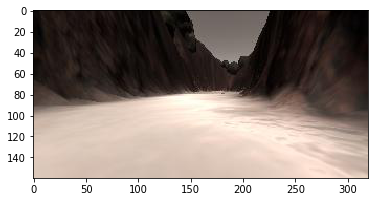

In [3]:
# path = '../test_dataset/IMG/*'
path = '../test1/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

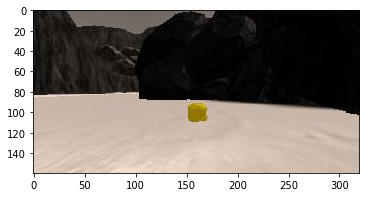

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
# plt.subplot(121)
# plt.imshow(grid_img)
# plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

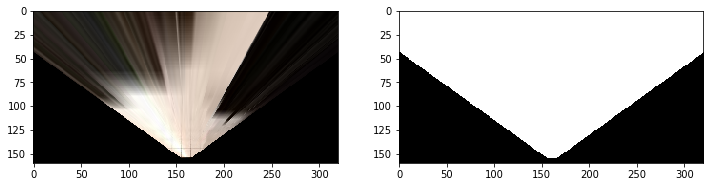

In [20]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    maskImg = np.ones_like(img[:,:,0])
    height, width = int(img.shape[0]), int(img.shape[1])
    mask = cv2.warpPerspective(maskImg, M, (img.shape[1], img.shape[0]))
    return warped, mask


dst_size = 5 
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped, mask = perspect_transform(grid_img, source, destination)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(warped)
plt.subplot(122)
plt.imshow(mask, cmap='gray')
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Hints and Suggestion:** 
* For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!


* For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!).  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  

* **Beware However:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

(160, 320)


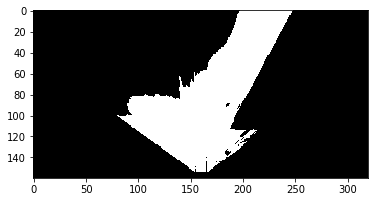

In [17]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh = (160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed  = color_thresh(warped)
print (threshed.shape)
plt.imshow(threshed, cmap='gray')

## Boxing navigable terrain
The idea is to limit the amount of navigable terrain to increase fidelity

**TODO:** Do a series of erosions and dilations to remove any sharp edges or blobs. Create a rectangular mask that comes out of the robot's POV. Use the mask on the dilated (thresholded) image

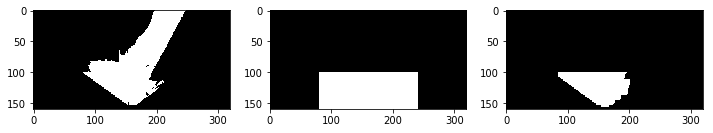

In [19]:
def box_threshed(threshed):
    eroded   = cv2.erode(threshed, None, iterations=2)
    dilated  = cv2.dilate(eroded, None, iterations=4)

    mask_box = np.zeros_like(threshed)
    boxHeight, boxWidth = mask_box.shape[0], mask_box.shape[1]
    up    = int(boxHeight/2+20)
    down  = int(boxHeight)
    left  = int(boxWidth/2-80)
    right = int(boxWidth/2+80)
    mask_box[up:down, left:right] = 1

    final   = cv2.bitwise_and(dilated, dilated, mask = mask_box)
    return final, mask_box

final,mask_box = box_threshed(threshed)

fig = plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(threshed, cmap='gray')
plt.subplot(132)
plt.imshow(mask_box, cmap='gray')
plt.subplot(133)
plt.imshow(final, cmap='gray')

#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Obstacle outlining
Instead of detecting the obstacles, an outline is created along the navigable terrain using contour detection

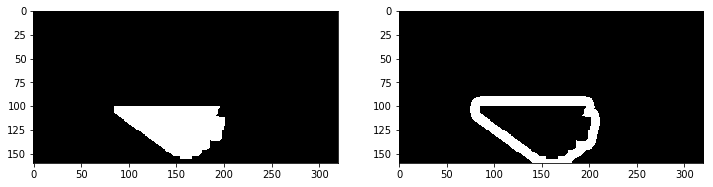

In [8]:
def translate(image, x, y):
    # define the translation matrix and perform the translation
    M = np.float32([[1, 0, x], [0, 1, y]])
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    # return the translated image
    return shifted

# Create obstacle map from navigable terrain map and the mask
def create_obs_map(nav_map):
    _,cnts,_ = cv2.findContours(nav_map.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    obs_map = np.zeros_like(nav_map)
    cv2.drawContours(obs_map, cnts, -1, (255), 20)
    white = nav_map[:,:] > 0
    obs_map[white] = 0
    return obs_map

final,mask_box = box_threshed(color_thresh(warped))
obs_map = create_obs_map(final)

fig = plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(final, cmap='gray')
plt.subplot(122)
plt.imshow(obs_map, cmap='gray')

## Detect Rocks
The `detect_rocks()` function will detect rocks within a certain RGB threshold value. Yellow rocks have a high red and green value with a low blue value. Hence, values above threshold for red and green and value below threshold for blue will signify yellow color.


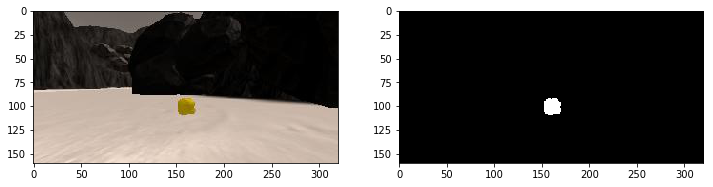

In [9]:
def detect_rocks(img, rock_thresh=(100, 100, 75)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])

    above_thresh = (img[:,:,0] > rock_thresh[0]) \
                & (img[:,:,1] > rock_thresh[1]) \
                & (img[:,:,2] < rock_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

rock_thresh = detect_rocks(rock_img)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(rock_img)
plt.subplot(122)
plt.imshow(rock_thresh, cmap='gray')

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

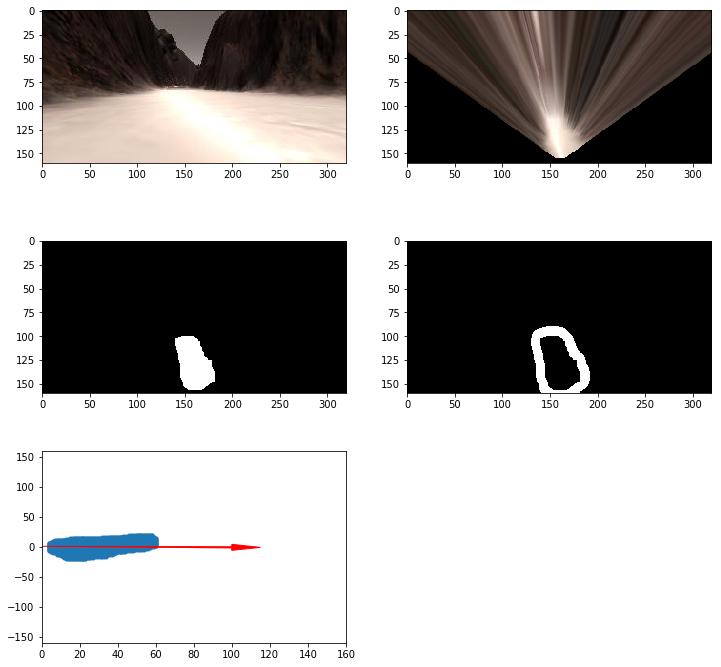

In [10]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])

warped, mask = perspect_transform(image, source, destination)
threshed = color_thresh(warped)
threshed,box = box_threshed(threshed)

obs_map = create_obs_map(threshed)

rock_thresh = detect_rocks(rock_img)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)

# Do some plotting
fig = plt.figure(figsize=(12,12))

plt.subplot(321); plt.imshow(image)

plt.subplot(322); plt.imshow(warped)

plt.subplot(323); plt.imshow(threshed, cmap='gray')
# plt.contour(edgey, 2, colors='b', lw=2)

plt.subplot(324); plt.imshow(obs_map, cmap = 'gray')

plt.subplot(325); plt.plot(xpix, ypix, '.'); plt.ylim(-160, 160); plt.xlim(0, 160)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [11]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you adata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtEAAAKbCAYAAAAzCtYNAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzsvV2sJEl2HvadiPypqvvXPT89Woo/thYLSwIkyDBoCjBk6MWA4RfBb5YBv0ovAmzAMCTIhmE+GLAgS3rySiBhATaxkB9k64USJNmQxF0uKS6Hq+WS3B9qZ3dmdnd6Zvq/771VlZkRcfwQcSJPRmXde3t+dqZ76jSqq25mZGRkZMSJL75z4gQxMw5ykIMc5CAHOchBDnKQg9xczCddgIMc5CAHOchBDnKQgxzkeZMDiD7IQQ5ykIMc5CAHOchBnlEOIPogBznIQQ5ykIMc5CAHeUY5gOiDHOQgBznIQQ5ykIMc5BnlAKIPcpCDHOQgBznIQQ5ykGeUA4g+yEEOcpCDHOQgBznIQZ5RPjEQTUT/KRF9l4i+R0R/7ZMqx0EOcpCDHOR6OejsgxzkIAeZCn0ScaKJyAL4QwD/CYAfAfhtAH+Rmb/1Ey/MQQ5ykIMc5Eo56OyDHOQgB9mVT4qJ/g8BfI+Zv8/MPYD/C8Bf+ITKcpCDHOQgB7laDjr7IAc5yEEKqT6h+/5RAD9Uf/8IwC9cdUFlDVfWIgQGwAAIRPEDAgwRmAFmBslFwrKbeI4IMGQASlnE/2IeKX1gBhHBGAMwY3ADrLEAAcEHAIC18W8OKX8CCAQQpawZHBjMDJDMUzgVh2GMARGBmcEcctliEeIfhmJ+IQRQKqOUS8om5fbep+vG5/LAWIYk1lhYY8DMCMHn6pF8OFYlKmvhQwCHkLJLBSQCh1gHgRmGDMhQqmIDSnmz9yBjQAACB4AR/ybk+mWO9dC2DeqqRkhlIlPnMqvXkm5PuMpyQnvPfEJCuyX6SMqo89X1kY5/qHvMlHlfnvk9WouhH2CtBRnCu+++e20pGCzdL+eVz6m2XRaCQGO7lLvopClbEztN7qOxG1Lsu8yxj47dN+kRSvnRpO3FPhozZnVjqe2cNpUdRRMlQ/A+wIfwqWuizyDPrLMXTcPHq0Wqb+R6z68+Hdd9Wup//B3/y+/oCpGzk3TqetHZPCo+9b7Vb7mOKOn1pH/Hlz69b9LTzjm4wSGEEMckY2BN7BNElMcXZsDIsXQvAk3aoLU2nx+fZ2xr+hllbCjT716vfstzXvF7p751OiWMolrKdLozfQYlj6E3Sct85Ri3L0/e+TEe0H0NSu9O+mKZn8JHPP1vmt/ccXUssOjF8Zj3Ho8ePYZzfqf8qdvNVpcxQIIfCuvoJ90V6cuUysDqWPnYkzEFWZ9fq7M/KRC9ry9OExH9JQB/CQBqa/Ezr7yMvu8xOAcAsHUFay3YEBZ1E4+BYBggAdTMcDYqOWMMFnWDqqrAHIGnIQIQ0DQNKDC6fgMiQtu2YGY8ePAAi8UC1loMwwAAaNt28jdRHJyrqgIRwXuPvu/hnANMk5/He48QHJqmSUqS0fd9LJuNgMR7D2NMKiNjGAbUdY26juDyaNHi+Pg4lqNpYC3h8vIS3Xad8g8IIeCCLLbr+CwGBPiA1XKJ06NjEAMXFxfoug4hBNi6gjEGjmMdvfrSbVxcXGRw3vc9rK1BlUXXdfH5BpfL5b1H3S6xWCwQQkB/fommaWCMQT9s4b3H8ugIZICu61DXNQbnYCvCnTt38Morr+Dk5ARHR0dYhzbXa1XF5umcA4FhrY0DFACDgFIofHDDCpmrFdd1A/hcuvKafefGScP+a/WxD3Pts5TruvNPnjzB0dERuq7DS7dfQbNo8T/8j7+I20dLDMHn8nEyeOnBQdqp5CmgIYQA7z2stTDGoGkaMHMEKM7Be4/V0ubBRsoTQQzgGTg5jv1LjhMR6roGEeX+JtdLX6vrGtba3G6lrQ3DEHXOMKQJ7RTc5Ak3gGEY4JzL95Q0TdPgwcV6p16fM3lmnX20bPEX/uOfB5jh03v1qX70J76TSI5IfRIZGEN5oh4BqYFJ7WSnnTLDJH1uVZr8MQYm/V6v17HtJELCWhv1d/o21sa01sDWNYw1qKoa1pqRxFCjOBGhqio8evQI9+7dw/379zE4h0UbdfXx8QmqKrZH5z023QaLdoGqqmCsyc9sjUVVV6iqCm3b4uTkZPL8RGZSBiFjIhnR5meZ+873KP7WxIyuN/lbnk/SloA9EjJh55wxNk8UYlqC9+6jaIe6te2b839g0WDvo5JMcl13b8TxMXh/bbphGEYSD4m4KybwQuYNbojEA8djwQcEDuDACByyPgye8zUhEQf5dxDCL04EvfOZBAySLgSE4OGcB4PhA7AJNMEl3nv883/+/+EPHj1ASKBYimwIqOp4LHjA2PQ+GGgXBkPP8GCQnYJs5hEga6LDGKCqAGMsBhfgPcOaCNKNie26HxheVZuaY2LYhRiz8kmB6B8B+Bn1908DeKdMxMy/BOCXAGDVttzYCt76yJKmzgvESneUlGFVgQKDfcistLw8ZoY3PnXqVENEGIYBVVWhsVGByQsX5ah/C9Bl5gykjTCwaVDXiskVAyoR5YG2aap8rYiwezKAhxBQ13X+2zAyWI8gY4HVagX2AduwznmI0quqCm3dwHV9bsyLpsVisciDvk331o1dyq+BvU3Pv91u83kZBD2PYMJ7H4FvmlC4xNIYSxkwgQgMj/Pz81y/t2/fxsV6bLlxkgNYQwhhfN+fVvk4gGp57MNc+1GX6+WXX8bZ2RnW6zUuztd4//49VCayaEOYDhzlICJ9RQNhPSGQ/iR9wHsf2ycDw+CTIoyT3aOjIxwdHWGxiMBku91is9nkSaLkI3mIaCAifc45N+nPcn3uUzB760QDQ33cOXejQfRTLs+ss1+5dRLpKiJYoya4bgqmjDFgBHAYQVk0thkEBJgQv4GYl+iZKeNMMUXSXUBBVoUATu+6XSywWa/jMQAhMaeeFBtsDBAYwXmQSRZBYbWJ828k8OJ9wMnJKbbbLbbbLZ4+fYqu61DVNeq6gTGRiLHGoK5q+OBBwWSWOoKTEAGOGSdvbdsmYMAg4tQukY8BNOpFHplMDgzO6XnSp+b6Xnp3O33xWWTKSDMYlN8BfcTA9OOTj7ac+X3dQIL31wJoIOqZEkAjtYnpzce0jBFU63Yg6DOm4am1SKURyx3L/eWf6EkO6TOm7QLgQzqW+vW/+Te/i2996zsRPKtiGwJsFf/wDrAWGRC3jYF3DOcZpnpWAG3gPE8ANCXL0jBEoD8HoJ9lcvZJgejfBvAFIvp3AfwYwH8B4L+86gLN9gLx5bB6aAAjg0QhNsgQ4EIAVyYPhhpE68HSe49A09k9EFlnAZuaHbbWYrlcThqkBgGSB/up0gLGwbaqTC43K2Y1p2UCB+SB3zmHLQC7pvw8bdOgbVt0XQfrGxA8QAEW8VnqusZiscDWBwyJUVs0Ldq2xWazyWAXGDuNABepa81CjKxFBEt5MpMmFkSEQMAQYj2H9Myi8DXrYW0DU1ms12vcu3cPdV2jOXk1K1wOHmzGOpq0hxli7KZs8Zxcd+mz5P1pBLwfR97OObz55pswxuDW2Us4vXWGtm3w+OkF2kWd018FpucGbenrIQR0XTdOBhPbdufVl9D3Pfq+j9eZCjAVqmaBtm1RNQu4AHSDhzGxnL3r0PcDVqvVTlk8A94FAAHWCzud2nIAYCoYSkxiMkFmhk0AFwCqqmjZSiA6sy94ISzZz6yz46AWkgtdBNKRk4zvRKSqKsA5BCS2TBEkxiQgzWYyiRadVNwOIU3s43VIlkZMdLQ1JurE7TYBzgCm6CYU0ntlIhBzBNo+6qFo2dVkCQDIBMyjaRqcnZ2h67o8ieu7Dl1do2nqrPuaqkbn+sTsmcn44IOPk4ZETrRtu1P+BIeSC4jqm9pEjWl/mrLEUyb6WT9zda91XsmUy+ejnkh+GH2/Tz7qMsa2KK3++ns3TXNtumEYcruW6/S3vne07lT5vJ7oj9hn+vdIHpjpt0n9kjm5zzICEQxH91FSny5Qsg5F107PjHfeeQe/8Ru/MQJoHgF0ZeP3MCQAjXQ+Taz7fj+Ajn/sA9CAc6EA0MAwMNwVADq2rZu1hU8ERDOzI6K/AuCfAbAA/j4z/8E1FwGI7hpeAKo8uGJL0aROXlVwabYWB7ERLMdOHc+ZlJf3HgNHE0JVVXkQb9s2M6vC1Iq7AbBrWi+BNHPI5+TYHGM1NoDR9F23Ddxmg8H5yTWbfsCw3YCZU1lP8rXBBIRAyD55yUQJJDDR9+iqbuKKkXx/dszSpbKcsNSMPAmZMy9qxqME4cLEt20sg/MDHj98BNcP+MKfvoO6rvP9SsUw58bxaZKrFPuHBcEf5tqPA5yHEPCzP/uzeO+992CthfcRSLTtApfbDYBx8jT+Rv6tB1h9XreVxWKBuq7Rti2apkFd19kUpxlm5xw2mw2stWjbFhcXF9hut9Fknszd8VqTyy7felCRQUxAXgnuZUJbtneiyIoL6yy6ZhiGDHyeZ/lAOhtjPZfkBDDWsbjUiF5I95sCaQHGM5Y9EW1R2GfdkHxE9+l76jw18AuDh1EWSUmnv+V5Tk5OsiXk4cOH2X1N3IWkPcp4JXlqICTn+r5H13UZSMt5Pc7o7+s+MvZo64t8Pwt41HWq67YkYz4ss/1Zk5tYWrUbnJayfkcgPN8+ymP6urmPvn95rjzmGOjDmDZOCAd85StfRd/7CQsdLc0ROA/DCGIlTV0Tuo5BFSampX1gmijmFfsY4IaAZPieAGQX+BoAfXP5pJhoMPM/AfBPbpwejOAHhOAABICiq4YXPx0fENhhuWjQVNGPTVio4KfMUFRcqSGpQdUz0gK4cRCvqioPrHqwFdPvzHPtPRYB56ioRaHpNNolQvuJMlNktW1y9QiMruuwXq/R1Da7mDjnoinQjOy7TADk9+XlJZbLZfYB3fbRz5mSv534n2q/uFjHPpooq2qnzHPghJlh7fisFtHH1TmHruvA7DMwCiFgs9lg6DZYLpdpkEMGIfvY3aACzJgPQUxc12+etWN9FtjoYRgwDAOICI8fP8b/8Sv/Z/IfdqDKTq6dU9RzAFpEXKyOj49R13V2YWJmvPvue7kMAlC0q9X5+Xn2fS59oqXPSpvUfR3ApB2LG4n23fZJl+i+sQ9cTfvCTnU+d/LMOlsNssB+IC1/XwekpY3o91FO9Ikiiyy6dZ8+ZmYsFgus1+uJTh9JlrFtlu49JRjVAN05h9PT0a3j8vIS2+02WtmSvz1RXDguYFny1/nIp2SjdbvVelHyugoklcf3gd+Pg+HN7+ZF6AjPIDd93jnCaF+6m+Zf+mLfZKJ11Ufntw9IA5GFLrHSv/pXv4Z33nl3AqCBBKJt9PBijr8ljbWEuo6Al2gEyvq7BNBVBVhrEALQ7wHQg7shgL5hN/jEQPQHEaLkWxcAD4ZnxSYBQPJ5pLaFNaOrgQXlBjAqwqnS0sySpJWBu2maDBpCCHnw7Lpu1vyiG+4uOzL1HdZKWLO4cl7yICI4jubmuk7MWlKu/eDzohnvPTabDdZEIEZkdQNnsMMcfZpDCDg6OkJd17jcrKOyXi0nftDa1UPK0/d99hOX8sszC4MNDuhdBL81WVgCyHsYH+9f13VKG91L2qpGRQYcGO/86Id4+eWX8dJLL8V3gmgqknrQEj6lG25+FgA0ALz66qt444038NM//dMg2LyY1lo7sReUilx/zw3gAnqFtQOm/vrHx8c7LIsGzbJ4KltaUl+Ok9iplUSOiWhWRSaTGsgBI+jWIFv3c3muqQ/2Zws8APGJs4UwSTlpAabAoATSwBSMy/vTE5cdi5mMuJP3Nop+nwKk9T1KIM3MYOfB9XTiVep5pOdtmiYDaVmUKqyytOumbtANPfaBJ02ADMOQF9jqdqv/lvRzbHAJjufAdfmR4/tEj1klk16WT9fPZ01uCqKfBWxr2Tcx0XqoPF9OnnS70OfKNqPT7mv/gHaRiGm+853v4tvf/g6srWEMIXCM0hW8g7WMEGJXTYGTwBwBbdMkFtpcD6CBKYDu+gigzQyAlqAgVwFoIrqxH/9zA6KJCI2tMBAl/9vI7ggzVCX3Cwl+RaR9c+1OJy5nWMIsGaN9lmP1aBZMMxHDMExMbZKvzr88rgdh74fZBi6fbvBgJlTVOHAEMKyJ0QRWq9W4iMYYEFdgJjgXsPUDaltFEOHjwFAlZlsmA0dHR9m06JxDI51GDSi602r2vWSIOIyLYaqUZxz0xuc3PkYSOTo6iub/ntFvtuB6NKue/+htEAKWiwbtYhWvQ/JtNGZHiTyvct2gctX5D3PtR5n3gwcP8FM/9VMwxuBv/62/g812wO1bJ9hstpgDjc/CQt2+fXvSP+Xe8f4GPkSriEz0xFRurcXF5RrL5TL5xKWwlFU9cSXKCxULECO/xzRjCEoGg8gAaRAwzKAQEDiWTwC7BtnOiz648aO/UFKyYXpRYMn+i2ggvQ9Ai96SvMrvAAAcozPNTdhKIC3Eguj2EkgH5wFjYOzoglEy0nIf7dax3W7x5MmTbMETl6LKVnCp/WkWuWSjfbL+aRA999FWl6vSAZjU5b70JYgq5YOeO8i83HRcK3XonE4VnanPzblh3PTzLNcPYezzzIz3338fv/ZrX0nscgpDDAZ7B2ukv0QAzOO8F21rMAwxEshOKDve1afRBzrm3w/RB7oE0C4BaMb1ALpcp3aVPFcgOrLHjLqxoEBgF1Abi7peoHMDrK3R91uce4flconKWLRtjRBMNg+v2kViay/hvceibQFU2Z2gbmz2wxRGrOs6AMBqtUJVVXj69GnOr2RudTi66Ds9VVLecwbnWgnL/eRl1nWN3g8wVQWXfIqEbQ5g1KbG+fl5BMJs8iIrHwJ8Uqbee6zXa7R1DPnlnEPgGGKvqir0fQ9jTAbjAq7ZDTg+Pk4NzyV3C4Ad4/T0FH3f52fU0Q7k+ma1QjcMgDFgE8uxXC7BwWcgYzECDWsMTF1js9ng+OgYl5eXeP311/ELv/ALWK1WMV9mwDuQSSb0GLivaCMfpoV9OJQzx9SWs/gPcu1111937Vzaq5hmfW6xWODi4mLiP6otL8YYHB8f4xd/8RcBNnjl5VsZnJq6GsHLjF2saZrszyw+8MzRxH56eroDZgVUhRBwebmGTWsXNCPc9z2AuOBVzPTyTLIYuGTjdB3rwUdcMHTVxzQjAyqgRfyg59537tP+xZj8PZtM3S9ESiAtoFnLPiAt15dAWr9byTsAoJlrSuBorc3WsdKSoJlzdg6c4tjvY6TleY0xGUhLW+z7HtvtNuvfuqqw6bbX+kYLOVEC6fKa0qXjKnA8xzrO9Qf993XAeK4P6GP7WNPPutzUlWOfzLU/Xf/l7+l7neZRfgOjFbDMY9ST6TdHVw597qu//pvYbDqEEAFuQHQLJYqurTsLCRlYLAjeMwY3XUwo5/XfgDDQ0crf9QGGJITdFEAPfjrKXwWggwS4voE8NyAaHF1U4uSFYCm6K4DHxYI2bcbiOa7q7xBZgdPj25OwdJFZ5uyb2zRp0QiQGWYAE7Arik4UpPaHlDTyrT9yHSANEJN0crz0sYu/XVY8ccDg0awNBpiST2EDpHJL2Y0xIIZSkOk5Uj2VJtaqqsApooZEG9Cz2RLgg0a2mTmu1pXFM+Xzw0gEktSBfYAXRY7pYBpCgOs61Mbgh2++iZ/7Y38Mq9UK9+7dw+nZbTAHMH063TiAj5dB/jDXfpByycRMrDLi0yn++nVd45vf/CZOTk7QbQc8efIEi8UCy+US2yEC2th+poOn/Jb2LhPP0ULjs2vQZrPJZfBpobApfddUvgJ+yme7bqAqB5p43W76qyxaB5kX0UFleEE5J7pUnwf2A+kSqJWuHfq+wZiJW4fWZ1rvyr4AehIlJEfWoWF06yjLU+pz7z1Wq1V263j06FF27RBmuaY6hQAb3ZDKfOQeAqK17ANP+4CTTl9OAsp7lsB6DgDvA8VzAP0g++Wm9TPX9oFdwkVPWqUN67/n3kt5fF97mLsOiH2r8wRGgKEYleu3/vXX8KMfv4OqaiL4RVqj5gbYGJAng9gYwja6cADYicaxD0DbBKCJzCyABqYMdCzz9QC61EVXyXMDoglpARtzDD8EGXATU5U2CmEC2CU2DOOLl8Vro9vGIoYh2m5zvGbDAPO4ol7Aq/hT9n2fAQSAvGBPmyX14pnoGzouftFKKV6jF6yMymoMiD+CXWHjehdQpw1YAhjdts9Avdv2mTWvqgrsR/COxAbKJEIvxMrpg4TWG9l1zf7IIFTXNQKPz8/MgAk5EggT8io/CYMnIHpiQled0VIM/QRLYPZYLhr88Ic/xJ07d3Dr5AREhKa26Pr5gP08t4XRT1jmWOGbnHuW8x/m2mctFzNPIk5Ya+Piz+TGdHZ2hq9+9avxWD9urrLZrPPCQmbO4ba08hXfaWnrYup2zmG9XqOqqtzmgRTBweq1AxZE0UdZXLvi73EQj88jIJohmwWUoCc9feqL4zWiaEcQEgP3S12NIG7049N1KfeP5fyoN5p4DoSnvpT7gHTpzqHlKtcO7Zaw6/KThCj6SIfpgsBJMVO+TdOMYe9k4pYImnzMxZBdsnhRA219f2becesQ14yqqrIrXV3V2HSbiTuG6EwpgxA7svGWBjYlsNrHRuu6krTyXTLz5UfnXwK2A8u8X54FHH+QdGX+ehKor5mbSIk+G3/vdxPS+ZftUv7uAzDIhivMeOON7+P13/l61KcJQHsfMPQdrAVEDVgbWWdmoK4I1hK22xA3VMn3LS2Cci1QKQBNkMANI4D2PgLovNHhxI1jF0BLuL9n4bOeGxANMKoUb5EJsGRhG4uu79ENPfrNFs71uWIaW6FdrbBarfDkwZO8S6Aoo7jys4YhyjGgI8Nqcyg4WUQn/pVyrXa/ELcOHcUCwLiwiUMOlxcb3+g3KcfjTl5+AsKttVislnFw8IQK406Im86grj0AxnboYdKOjJfbTTZby4wqN3wgR+NYLmL0i4uLi2hqRGK603ddTBIkPJgAb2stiMdQgLIAS9Ivjlfohh4GsVMIw89h3BmSky87MeAHBzYBFBjepR0cEWB4wO9+4+v44Q9fxZ/9s38W792/j8XyCIQ4kYqtIilxfEh3jg/JEs+B3OcdSHddh1u3buHy8nICWl599VWEEPDFL34R9+/fx/HxMbrtORarJdbrDRaL6F51VRkESFRVNYmrK0DD+QBrKLuSEMUQcm3b4unlRXQVIkqbZWiWgWDtOEEMyk85WllGGiIasqYDguQxWayWtHicLCa/XHVdSAuciXeVMgG5/33mJFffFIxpP3YhG/Rv7a8upEXp0lOCP+0vrV3j5J15ZnCIS5ElvQabwgQvl8u8mE+DhpF8MUCfdoCrR30IjCFFtfWDiPBTP/VTaJoG9+7dw5MnT3B5eYnj4+MY09xaHC+PsOm2k8gxAqS1S4lcJ4RQrmbFEkp6serJeWBk+nXeMgZpi+lk0lBMEOaAYcmOapZf9/nSd/xFl5uA49Kv/6p01+UnfUOkBM1aylcwl66MxiHfZTm2bDGEEC3ZAP7pP/1neOONt2BtG9eYMaPfbOCHLoeyq6ronutczHe5NOg7xrYLgArsJABaA2ljYui7iL8YzD76QBvVDwLgHO8Bz9OxVMDzMLhEmhCqysLwzdjo5whEq5iuYBhhUxHD3C0WiwlzNZCfKGMJpVTn8GwRtNaLBbbbdTrGMGYEt6Lsy10JRfkIWybX6nN6EJYXJYpK0lq7G4JJK26tLI0xMFUNk57PpQHBWpuBpChOZp7sfsRkdra4nbAPiSEeQnquupqUJz7TuGsjABAoM4cA4HlcIa4je5heKWUpLyf3G2NBacctkriNIaCta7gQozA8ePQED+6/j8vLy5gfMXiya5wGLh+icX1EILr8+yfJHH/UeeuJIVHcMlve5fe+9z386J17eOnWUXL7kHeLnQF+ZHbH/IVdk34m0TVEbp2d5gW9AmhyuMnLscy6/+g+N8ekaHepOdY9hNgn5wZ6DcokXz1IlaLP3ZRpetGlBFk65rYcn2OJBeACmLDSAHber4wRAhQ1wCwXG2pWWv+tow/pSZZuA8ElhrqI2DHnd+29n8SP9t5PYpgTEeqqQu92d7+V6+XZ9HqUsi1KHe7zX51nI/eb8PU7K99fKXN9Sq65Tne+iHKVbtBpbqIbdF+Rv+fkKtZZl+m6dqHz0teV7DMA9BxD0IWQdv9kxve//yZkEWFgoO86OA2gbZpkevGBjosIPU+39NbfswDayQR3CqDDBwDQnNhnDoSmidhuO7xgIJp5jHfsiVEZg1qBwta02G63E8Wz7rYIqdIkxNvyqIW1Fn0fzWsmAcOsfFKFa0XY9/3EX038jheLRV7MpJWZTisvdmQ+9MIOtTmJUnzSWOtFncEFUXJJcdEpP4S4y9aiqVOjMFm5StQCYXvZTBk2bdaLf4/huJgZXE1N1nkQMbGuhmHILJ6IDEZ6F0NmjuHtFCjRHdDK8zOyyZ+IsFqtEkNOWC0awBj823/7b/GFP/7HnwtA8iIAaACZBRZQItu9P336FF/5ylfQVHEx6Xrdw9C4ecYwDNmdQ0B0mb+0U5nY6QmZTEJlIdYOKJ+ZfEp/k+uAXfCqmbYJ05yv3zVX67yJCMEX4CVvbrzL1E3KeM2A+mLKPHjSwErHSgbmgbQwrNp3uiQvNAgWfanzFAlA3omw9JHWhEXp2lFG6yCKETvITl075vqRDnsnLoGyWFDGr6Zu4i68atKg85Ny6N1z99WpnkiUdVQC531/a32tJwZyTD/jvjY/N1H9rMhNnvWm9VFOPucmPdo6sy/v8dyUMyrbrbx/3Zd0mtyumeBAAI+hcN999z1UVZuBb9ThmxwL2hgCGcD7uBCxbeOzzC0ilG/5TRQXERIRUiTdAkBH17rhWQE0R9zHTGiaCray8D7u9ngT+fSu0CqEmcHOz8ZunQyIZoy1LAsHBfgKkyYLpIQB0yBah6mSPOWeImP4NjMpX2bKi1lcWU5JO9cwdV5zLiLlMa1sS1/nkqEkx7LGAAAgAElEQVSYDACp/nRoMHm28hptJpKFX8I2S4SFcuDSz1EOVFeBGWGwQwi4vLzMmxR85zvfwaIet5J+3uU6duaq8x/m2mfJW4CuRNBomgZHR0cAgDff/DFWqyW6rsfRUYvj42OcX27hGTmyS9m2dftbLBb53S+XS5ydneHs7AwnJyc4OTnJoSP7wSWFhqRsx/BJZbmlPQ2Dm0TM0BNr56ah7fTAUw4WJSAogcZcvc0NRsyfTXcOQ7TT1uYm0yXDJe+xdPMgoskxkfL6OT0sQhR9pEf3uimzpn9LNAzJKy/qVnmHwe/cc+6+3nscHx/j+Pg4RxzKZEdKWyfLph6HNIiXc5q4mfvI/fad3weW5/LU58rfc3+X5+b6yqdVftLlvOn9SjJg7ro564NOO35P85n77Juglkx3z5Td5ZDw1pd/7SsQH+jAjIuL87yBCpA2UxEf6JpAhBgL+hoGGgTU9biVdwgMY7gA0HQjAA0kHOMSgI5HEoCWPigbmV8vzw0THQg4Dx1AQNu2IEtYr9cRFFcVQh/QcAW4AGtrUBV9nd2lw7bZwtQGZAIeb55iMWzRGIujtolvyQVYiqHjvI8ML1kLw4xhE3ebqoyFHxyC86hMVOhiWgshRZugaDLshiG6WxiDGi6u6maGNUBTVRi8Qxh6mKaGoQrWGgzCsvsA8jHyeL0acNpUwDZg6Dos2hZNY7HpHMg7NFWLrutwcnKCy8tL9D66rDSrFayLm6os6hrLdongHSh4EBwGt4mAuwa6wcPaCsfHt8DW4tGTc3SeMWyjokbVwMHAEqGtajAIVd3g8vISIYTs0xpC3FnLANhuPdp6ETtXiHGe19sebV0DkAggsb6RwHdVRyDf0BKXawcyC9SVwdA7WPL43Kuv4Wtf/Rr+vT/5J3D75Zfw3qNHODk7w8b12HYdXn31VfSPzz9EC7u5yXEOMLWLVfajJ5LJjTBh4wTC58mLcvdBuDLvm5zbd35O4WZwyeq+celuioWcJo+ecXx8DIbBk8sNmqZFszrG//w3/ibqZYPLPgBVi40DmHvUbQQd55ttfl5jDJrkOyrWoKZpYJsat45WeZ3CRdrwRyaD4uahFaKtqhyDXMzuesIsLJ+Z2boys5Ih+cOSyQwyAyCKzw5Z4JuO5boJHFNSZCjIiKNezGECk2mqwG/KaLxoQgBWdY3NzOYpmsHcF7VjbsGhMNIagOtvyWMuhnS+J8WoHVSw0SIlI62tgZqRZk7hugaCqcdtwcvJmORpzBj27smTJ3kDlrzY21ZwflysXhIpAmQkUocQJuVH+t514Fn30ZLl1KKBWMmCTt73zLUfJM2LINc9o7zP66T0c96XTznR2TcZuu4z127mjvWB4NIivKQZ8eUvfwWPHj0Bp4AJF+dPwcmvOIS4cFAY6LjehbDZxEWEY9nH76xeAdTVuJW39wz7AQF01OsE5+Kasqj8DerajlZ25rh4+IWLE43RzCuh1ExguLTiXgZVPYuStANHsBaQ/JsDYOoGi6pGZQnri8s4IFcWCDRxVZBFKpN4pHaMmCEMswEmVS6Nv9HKhqMpo7FNnvFZa0bf7mIxjShlvUhEypUVX1KqXddhO/R5gKmrNjPTdV3DU4RIIYQcYqk0bUj96g5eMu7ZB9rvMoJyTV0rBsf5XDO7pr9pDFcigl22qI34pPs0gHkwRR+qt99+G7ausFqtQEQ5vuvDhw9xbD5+pnofgL24uMiDrrwDYZlKYKAHWV0f1zHIH6Rcc+fLtPvO6QVaEl7rr/61/x6LNrapfZFSJB/Jq7RGyLG49fvoQw+MbltiHRLRylziSs+xf1c9p+Sj2+1VdbEvj+vkQ7zGF0qEOV4RYetcnkDOSam39QLrUmTyLnq5HOTn3DrKCaYwZUKRlYA966MEcCVfAZ4Tq17h1lH6NWtLyHK5xOnpaY56I4BYdG9Tt9j221k2W/cBHalDzs3VUxmRY44Z1mXV36VuL62MWq6zOOwD3i+izNXxXJqb5nWV7JuUlO8yfo+6qZwwaevb3G9JY4zBEGKsIYZPm7wxvvXt7+CNN36Aum7gGbg4P0ffdzBGNlNJOxWGWIZ2EQE0YoCldL/xW/ETmYH2IRI7GkAD8wCagExmlACajAGCAxDJvDoReH0/xDTGIDxDtK/nBkQDI4gelSIDPiCkXcXGoPmju0VVVbDBx7jSSBsjDB7sPGgJWJMiaNBoftT+uVVimgUgVlWVGOtx4aKYGG3hrhHNHIQ8VUsiA8Bms0FVNflv8fkWIC1gommaWRBtjAFCTJ93C0y+ck29mJpECbCIjU8WSupFNQLW9TH5aBcPSaNXkovIc7eLcSMWz+OuknFgc6pR7zf3xbLHsjjnwAQYqnB+fo7Ly0usUnSRdrnA0dERtl33sRN+VwG0tm3zuxcz7Wq1Qtu22Gw2k+cSGd1ars5bH7vq3Nz5feco9YfpOUqsbAK6HHeceu211xAoRgd46fYpjDE4Pz8HmZupj9JkLvUk7kDSV3XbEzchqZ8SWOk+ot2D5piyuQF+3yByk4H+KjZNX/5ZAQ1XibhhLAB0zsHtMU0LIJZ3C+BKIK2v14BNA+hSdhYtSroQdt6/zks23JJjmo2WfMPg4uCrzsvzS76iE4+Pj9E0TfaNlrB3xhhYE3cz1JNDvSfBHBstxzR4B0bWXoPiOYZSX1um3QeOr2rbnyXAPCc3Acg3BdHXuXKUTPW+d7zv/ZftpUy7M0FlRh/ijrGCeu8/eIAvf+WriDQdYbvd4Pzp0xgLepCNUEY3juXCoOsSyiqaiQDo+Ef8im0zLhYsATTzMwBoE8PhOecToRkZ6AigU2Q3km3Jw43xxHMFoqNldDQLh6B9dQgmsa5RL44z+aZp8uYsvgd618H3A4L38E0MMxQHdYZnl8y9UXmL+Zf0YiYV01nMcbJhhDUmmwuZo6vIRDGDYbHr3xxZiBpIinboewxDE4PyJ7ZVmyg1u1KG2CsX1OT8K4u6Gs+VTKHOVwOTXPbC7wrYjY2t87LWIjg/SetUfWgQLce22y18XaM2NgNpl8phqzjQnp+f49YrL6NLAGyRXEeov3mA9A8jcwDt/Pwcy+Uyhq1KA9swDNhut1itVpN6kcFUriczD/huCohvev5G+dP4u23akel/8gS//Mu/DGMMLtdd3N5bXH72iORfxvDlpClLRS5thojw9OnT7EcnEXNK9nGf3/9Vz0vKErC3DpTMMW5ThgcThmfvfT+jLh2l5aV3DkNBCGh5ViA9x0iXgFKYY61nMtlBBCqukfO6DCWw0Gw0M4MDIwwOtqmvvKew6GdnZ9kao0OnVlWFtm6w6bY7bVvqTLPReoFhSUiU5Zj76HP6nZTf+nnLd3cdoL4KlL+Ich1A1mPpVTI3BpekVUkGaJnqqnkWWsbtuTjrc2OF4+TyB+RN2f71b/4WmrpJbhyEJ3fvwljAuwhcjSE4FxA47kY4OIYLDNkzTYquAbR8y3bgEUCnRYR534EPCKDBMNbGMHbG5AXuIJNCl3IOW3oTeW4WFooiZWa4YcDQ93kzEQAZZOqFcgGM3o07+I0uEITeO2y7DhebNeqmAQPohwF95yYKY/AOZM0kTrLeoEQD0cmixxBAzDCVhaksbB3dRTTgjCbyAOd6hODQNBUWi+miR2aehMzTQFfu1TRNXiwpdZVBvQrXB4yxonUH1YBEnkVY9hKYzAGVzMSnT8kOXsVqlDNecU3R5ZW41ADQb9d4/PARVqsVXrp1CgPC9nKdN5n5uGUfCF0tljAg9NsO64tLuH5AWzdoquhPT4wYN5sMKmNhQDAg1La6Nu+rynCTazWI0Z/rzl1eXuL09BQhBNy6dQtnZ2cxDnhb4fLyEleJft960JD2UL5fYBw0YpvdLb+0FQEe2lxfRjPYVyd6Ydpcu55jaPbJWIfzx8vfn0XRA7W1Fk1VobE6csuYTmRuAR8w1TPZja5YgCj6TIPduQmX3J+I4Ikmcb/nGDxxnSjz0+mD8/Ez42akRdjo5XKZ/TBlAa/UV60YZl0ena+MeXOsob6Xfg4unlPOlZbOOUB+1Tsuwf5V17zIfeImeuO68yIlwzx3nzkWet/vfZOl8v2XbUQ+AxOGMF3D8Ju/+Vt4//37EL+MwAxmHwExohuHdwGcdiNkjtEzbgKgZTfCwUkYu9HFg3FDAE0R7BNGAA0Q6iquWeq65AJLMZZ8BtDPwHk8N0w0IS5sGxgYfAAbtV0sEZgHBOcQkh9wACP0ibVO7IdRu/al4T0qRIyDPTPDO4ap/EQhy0Ag6eRvvV2xBqSS12pxpABwAFGAMeO1ogh1fpGZwMTUrQG04dH8ov2ytSITP7s6bcQyDAMGa7BoRx9vGYBkm8sSRGtQouuhZCOkXDLJ2KaY3OXGA+X1QntOFa+HcwG9MVjU0VzZU5cnAm3bou+3uPfe+zg6O0FgB+8Yi0UL8j85tq8ESotl9NN1ziGwAyiA4TG4DsNFHCCrKvpyx9je8X1VdWTnr8r7pueuOj/3m2bqX/8+Pj7G3bt3YYzB3/vlX8b5eQTOd+68gouLC7gr6luedy7vEAKGtAhW2oMo7XF3xGhpkst1CMboHrRrkblJnelFaXNgWQ9Kc4yM/L2P+dn794uLG64UqV/trkMUW17nx90A9Tewa8Z+FtcOAQFXuXWU7zbEm86+W2GPhUCR/Pe6ddjd0GBaRzPHBbtd12G73eZJoYS8q6oKdVXDdeMiQz3Jk3sbE8M5LpfLHaBUgm5p93OfkuiYOyb1q+vnKjA8R5ocJMpNQPQcGJ9rlzrt/Ee5R+xJe10kFyDFew4E78d1MG+88X38/u//AaKjaATQjx89BFF042gaA+/SQsK0G+FmE0AF6pyWL35bK/GkCdaM4wA48uDDwBnnXgmgE1p3XhYSEmxlAaLk/hp3lQ7M4BB3W3xWo+HHykQT0c8Q0b8kom8T0R8Q0X+djv9PRPRjIvpG+vxnN8nPkkFtI8tcG4tasZQSjkhHAMih6zzDDR7D4DAEDxiCrSqYugEZg812i0AG9aKFbWo4Dui6IfpWI25s0os/XwKLMvBrlqW2VWYdg/Nw/YBt16EfhhwDNH5oMrDEhYnR3YQYqG2FRdPuMA0yiIgy1uyLbvB6FypdVs30yf3FF09Arj4mDI/eFEAPQHoGq+sBQM5Hm1vLAWHukwH/0IF5tCwADPYBbRvjfL/xxhu4PL9AW9WoG4u2+cnNB+eA4f3799H3PRaL6KNNRPjud7+L119/HW+//Tbu3r2LJ0+e5Bjj5UTkqrxvcm7feT3Iz/2+6tx2u8XJyQnu3LmTtvqucXS0xPvv37/WHFmaIssJmQYEwOiS5L3HZrNJ7Wk6YRvb0HRhpq7Dm9RZCUbEtzrHoZ9hGefqaO77qvs+D/JR6mytL7T+inGR6xyyUtePrmvNiJWMtLQXrUNLt7aSSdPHynKCogveHAMnHx0NRrefHb/Rwc2WXZMITdPg5OQEZ2dnaNsW3sdF1GLFIyI0dbPz7Lo/MPPE6qePlxPDuYmjTnfV3/vqbu4a/X1Vmk+bfFTlui6fsh1cNQ6WUvaTucnMrn6/md7Sacp7EhEcVbncxhh0fY/f+q2voW5a1MnltO86PH36BM4BdR13TPYh+jC3zbiddyz/Lvssv42NDDYwstBE6ZkVgGbcDEB7H2S1D6oqunHEhbkVApR1RwNowo2Jj48beTgA/y0zf52ITgD8DhH9v+nc32Hm//XmWcVaJqK8SQcRgZIiq+txoUbdLnJUimEYQHbcShZIDcMk8wMM1l3cPWrRLmKhZdW0rVC11QRgGhNXYUNtdV1VVTTbK/80udd226OuI3CWTVIAcS9JG46kqUxI4WBsZdBQjctuM1Gi5aDUti0CpkyBDCYSfo+omnROYYel3FVVYQhTEFKnkGTCjAPIbIYAdFGqmgHPdasGy5DuNzIiChiFKTghIrjg4QenJgrjDmJEwPriEqvjI/TbNdq6wdnJKR49eYxuvYEtp7gfs2ilc+fOHYQQ8P777+Ott97CgwcP8iD3ox/9KLvQnJyc5N96AdJVeT/LuX3nPwg4lwgu/91f/etYLJts0iaKoLe/YkcnUfK6vcrxEAKqplass815x8WGPilNCaY/9bnX0RL0oFQuHNv3jBoUxA/vkA8GuwPUXJ7XMW7PE4BO8pHpbMY4oZ+z6NWI49RmmG4RPwekRXRbKDccAcZdW7WO2ie6vRClLeSB2YWGoutkkaGeJO6EvXMxagGqUbfphXvA6NIhbLRM5GSNjUkLDJ2a0Glrp9xX2Oirwt3psIBXsY36e67dluC47FP7JpTX5fsiyU1A9E3ymGu3Zf3r3/MfAadXv/er8xA3DlUmInz5y7+OvvcAxUV/Xd/j3bt3o77ObTzmv2gjgJZIHGUVTAC0iaHwiCJYluYSy/rBATQnAC2W96qq4JjjWgapCwWgjTHADS3bHysTzcx3mfnr6fc5gG8D+KMfJC/nPC4uLuCdw8nxMV555RXUtsq7FPbbLseJffz4MdbrdZ7tgzlPKkII6H1kpV3wKUxghfP1ZbymXeL4+BRA8rPmaHp2wefrh2HAkBTYcrlEU43RKJg5+74SA7AGvXc4X1/i8nKDIQXnl9WgmZk1gGGAAoMCw4LQtm2ORlHXdfaVBiLAcc5lvzphaIVNE6C2Xq8RQtwWHQA2m00GIsLat22LEEJW5iEEHB0dwVqLy8vLHE5JwHfpxiK7za3X69wx67rOK8jrusZ2u82syRzbpwehxWKRJwIhBByfrHB8fIwQAuo6vnM/OHzzG18HB4fKWLAfTZza5CsDrd75TvvHC+AvXWbkmLxvDQBiOeLmI48ePULbtnj88AH+ze+8jt/49a/gnR/9EMQBwQ1o6you6LQGjx8+wPf+8Lu4//57ODla4ezkGNv15YTdL8HGHGsBTAfn8qOPz10jv+W9StsSy8fR0VFecOGcw51XbmO77bFarXB+sUmbrHR7B0RmziHxpL2W/voaAAsLJ0xczCMqQ+0SJM+lN/fJPvM0Ltgs60ZbVNbrDTabLbquh3MeQceFBmAofuQ5ysHmqk2MSp9dDQI/pQTcjnyUOjvlMfF7l3rL1jtl5boKfM0x0pp91qy03oxljknVv7UQUY71v8Muq3sLsTBXtuwSdw0bLXJ8fIzT09Osr/W6GqKbs9H7wJGINv2X9aKfZe78VaB73/32AfQXWeZ0Qvm5ST1oVyAt5XvXx/TvufuW5wHsjC+lxP5g4DBarq21+L1v/j7ef/8emrZFUzeo6grvv/cuQIwQAGP1QkKDrk++ywWAHkG+3C9uwCIMNBFgTQpF+QEAdMgA2qDOls6AEHzaqjx+OIwAOo8bVBT2CvmJLSwkon8HwL8P4LfSob9CRN8kor9PRLevu95Q3B56SGCZELfdXiwWaBMI0ANXXsHPAQQLwnQL1EBAjGAcFZ3zjM6Nq6SXyyPUdTsNO8chMqUq5Jtu0JWJLh0CSoAYQo8Q2ZghpJBcxazd2PhsUVk6AAHGYGI+1PcERmZYs2H6b9ketvyI750wGwIKNfiYG2D0YCB56zB/mvkpFYZmULQLjFYKYzoGU4hvRiliMowqsVpNigdORHjjjTfQNlVk9e30HUt5mqbB2dnZGF/cjFtN6xjccq1YNAQsyy59soseEMHh5eUlPv/5z+Mf/aN/hG984xv48Y9/nCdHGgRLvQ/DgIuLC7z77ru4e/cunHN4+eWX8+RIAIcGgHqnTNWXrjx20/MyuQkhhsx66aWXsFwu8ejRIxhjcHR0hC9+8Yt4+PARjAHefe8+Tk9W2Yqxb4As36uu23IAKBX9TeSqQUpAetl3ZAvxZ5E5Zu2q+5bAS6d/HuXD6mxNXJSTnZR/1LVVldmrsu3cFEhr8KwBtb62zKPUqXJ/NmZnoaE8hwYTZV76HsyM0O8H0kCckC0Wi7yLoZARQgYxM6wxsMbOlkXfW9dVeS89flwFistr9gHtOdkHpq+65kWT655zblzdl+6m99n/Tq9noOfaSZmm5xS5I2GMd997D9/4xu+CyALJl/juO3ex3cYwrhwAN0TSoG3j5irOM2CuB9BNEwG0rFsUtUlqEeGNADRHAA0B0LWFsSb1gQBjbfaB1nUZ9RHBECUf6pvJTwREE9ExgP8bwH/DzE8B/F0AnwfwZwDcBfC39lz3l4jodSJ63TMi4+sDfB/Nf01Vo6nqCSMhitN7j95FsJdX7sMCXGwmQtGFIAIJl6M8HC9jjF/HAYEANruzwBK0yQDeVnV0BaEUGo8ADgTvGEOYrt7WTCgQYsSRENlsAeN6UqAnCXMgWkCxMHsC3gQ8b7fbDJzEnUNMiTLg60WGmk0TwKwBut72W9LIOyjNkOV27TrvaT0kMAuPwE7VrYWX98kMBMZb3/8BLAjLxSIvphSALGyrRDkRpqfrusx6yqAo8bjbtp1MgqQOVqsVzs/PwcxYLiMTe3p6ii996UtgZty7dy8PihqYC4ATUN73Pe7fv4+33noL9+/fBxHlSc1qtcJyucR6vcbFxQWstZMttEtWYd+xm56XSYG4PVVVZPkvLy+zVePBo6c4OYmWHyBOXDVoKBW+XkA1J/tAtK7r66Rk3efYHj2Jiu07wPuRySg/+v772JvrPvJ88+mvfaxPlXwUOnvT97kfiR7WfRwYQfCyrlEpa8VcO7gOSOv8y/Fg7tp9DC9R8o9WbagEHnptim5rE1ASQg7xWfpOi4jVTzZgkYmzDml6FRtd5qm/S7Cl2eh9oGnud/mMHwZkf1YA9Zx8FABa5zOnN/fppauOlyKTWwcr0Xwj1iHCb3z1N9G2i8hAVzXOz5/i8aOHAGJIu6aJ19Q1gQD0w3RL71j+9FH3FAY6BlyL4eyI4vbeQ1qcqAE0XQWgi628Y5/yAAPG2MRCh1QGPaGPeTnnbsxCAz+B6BxEVCMq4y8x8/8DAMz8njr/ywB+de5aZv4lAL8EAKeLBa/aGA/YkgEFzmY3AZQyqPYugkKTF3GNUQKYGQEEQ9FMQAAcx22/fQjY9APqOvpV13Udt3QVVsOmnQltDFNW13VUjs7nEGyGAZIV1nUNxwBAYGUids6Bk/ncNDVaWyMQgGAxGAfm6ORepfjHAlj14JMX6ZlxBboAH7kmhJCnSUxACB4Ek10w2raFVXUodVQyNHqA0MBXA+D0Lifvr2R7ovuAzaBYs1LAOBjGm07vbUAJ8Hfouw51XaHfbuAZePToEU5PTzHwaM4XdkpYHVnFrgGglFlcRwTI68mIAF9rbXaJubi4wMsvv4x/8A/+AZxzuHXrFnxnMiiVScrR0VGsp1gZsBQXFA3DgMcPH6IyBq7v8YU/8Sfxzjvv4MmTJ1itVnmTFmMM7t+/H12Sxv4y+V3W+XWAVB9jHv2R27bFer3GdrvF5z73OVRVhf/ti38PL906wZMn56j7HmenRzg/P8+7rXm3GwtX7lEq+p2B1prZ8txE5u6l7ymTJsnzqmyvwrZXTUiuS1/6Zw/u+sHx0yIflc5+7aUzlrqQCazuWwKqhIxYEKFzDkPBAun2pcEgMPWRFiktSyXw0/pSgKqUQbenQDS7NbjoPL1NsL7nBIynTViIxshNUm7Jq6oqHB0dZfcpvXGWsN6VrSaRmLQeFh21WCxmAa4G3NdF6Qgh7EwO9Du4CiTr577pdS+SXPeMN6mDuTRl29PH5z/z7jRXTviKj2OgD9MY/1/99a9iu+1BZMEANtsN3n7rbRgbdyVsGgMfAqwhVBVhvScSRwbQ6bGaRix5sZziThejM6XIGZgCaMwA6Jh3yGi7risQJZxlCCADFxjMajKadi00lNZEPAMDLfJxR+cgAP87gG8z899Wxz+nkv3nAH7/urwY0Rn8aLHMPpW+H8A+xBi8DBCPLhCeR/8yUgvnkFf8m8gwc5rlmNEk23VRiREj7aG+3w9JTMdaSTJH14O2aTBkwEYga2CoygOKDm+n4zpTCtwP7DK2UgbN6GolPpd2ji0rTUtzLIlOq0OMlSCYeRrCao65kGeeY5JUuwClRQUwpAaa0dWhqipsNpeobdy9cLFs8f3vvYHHDx9N6lUmHYvFIvqtN01mfEvGfrvdghMAl3BTACZsU9/3OD09BXNc0Pkrv/IrMMbg9u3baaGRg3M9tts11usLdN0mLrIwQNvWiItKHawlNE2FEBwePLiHt976Ae7evYsQAk5PT3F6epqecYPtdpuB+z4mYd+5m5yX99B1HY6Pj/Mui6+++irefPNNvPPuvThBYGCziROJzTaCBqmj62TfZKxsm8/CVJV5lvkK6+w9J8U8Mhe5ToCC0YiB/K+ry6tE+1/v+qnfKItPXD5SnZ1NtSMRoQGsrleptzbFkS7rfF87Khnp0qVDRxYCpnruOkYalGJIq3PltXqR6xzTzRx1+VXWG+89Vqu47mOxWGS/f+3W0VT1Tv7yEUviVaBI0s1NKOaeb1/d678/aLoXUa57xrnxbi6PEiTPpdkHjPelnUt3nVWiD2oDFmPw7W9/B2+9+TayG0dgvPn9H8AYwHugSqSIdxy39C4icch3CaDregTQIQFoY0YAPbgPAqANGgWgZQM8HwICx4Xk8Vpx30gY6gMAaODjZ6L/IwD/FYDfI6JvpGN/HcBfJKI/g/jIbwL4y9dlFGco46Kk4Dy8HxdhySrmtq5RVQMGP7oOBAIoFD53JpobPKLfGTACNwHSTTXGVB60guUYkHsYhhjOjBHZbUb2HxLQF0KfHOM1c0hg9mAvCszDoEJVG7Cv0BkP74cJa6GZYF0nAkA0uyrn5J7Wxm2/icZoB0BaJMUjUIh5SGOlSd7lJEKDZimjiJRTTwBK5sR7Dw4+A3C5LjIl43ML2CNyMKbJbHsIAf22AwXGO3d/DDLAn/4PXsuuCXojGmGcuq7LrGvJ2gi7Km4XWikZY3BycoK7d+/izp07+If/8B/m9ysLW/Vz6kWgzip4tqkAACAASURBVLnMSEv+YmpmZqzXa7z++uv4I3/kj0wAmFhX7ty5g8ePH0/a7hzb/CwMtPxu0uLPzWaTN1Kp2wa/93u/h3/8j/8xXnv1pcjyHy8RKG5Tv2ircQGtmbdA7JtwauVPYep+sW9iNSfloFEOALo4WoEDI2sw4qT9ps1nBdP70j5nIOIj09ngqduZ9GWpD3El0/oCAFoiGOfQqUFtrg73MdJ6YbG8h5IEKJljrWsnhANixA65RusqSa8jFom+nEwOQ0AYPKiZMr2lzjw6OsrAWRZiC3svOxmK6+Gcq4pzLod6lTz14jF9TK7b7Ttj9I99AEyn1e9FkzS7TWH+mk+DfBTluQlAvkkeug71mDJ3XkTX6b60kkbGlqt03gCbo34ZY/DkyRN84xu/i7ZdAiB4Zrz1xhvo+i2Y43o1WxH6ziMwsN3yTiSOfQDaGNlmWwA0wfsAJAAdhADBDQA0kLfyBiRqjU0eC2kRIXOK1RHZZyKDEHbXRjyLfKwgmpl/HfMW03/yrHkRRjDpvQc7gpdNQiDsk89+vuhGMDe6FBgYw/DgvJAFYFCVtqdGYpbJwA0O7AOqZZXvaROzQcbkaBACpipjAT/dMAIAjKnAPMAxwzAAE9CaOi6UNOPCM4PYUqJSJjAbdGkBl4DAOQajUUBXyqM7Xx5YTPTLtGoBnnMOjJG16fsenglNNbJGWiHrgUFAtPfT2VsIAaBx4Z6BAhaq3Myj2UYPdKYxYJPqzkZzS/AS8ozBLr5jiUxycXGBxla4f/8+Hj16hLOzs+xXLIsfmeMud7dv387Ms5hRBcw+ffoUTdNgsVjk+pZnq6oKT58+xdnZGb70pS9htVrh5ZdfxqNHj0BEODo6Ql2p0F1poiftQKKgSL3rgUye/91338UPfvAD3LlzB3/qT/0prFYrPH36FMxjNIBnAc83AdLyEZZe2tOv/uqv4u0fvYdbZ8d49OQCTUWwTYPNdsDZ6VG+XjYM1QpIMxxzZcgDcmEmFyBwE11W9oN47ei2Ya6wr0mJ5gCvAAhdV/r7OgCgB61dkH/9c30a5KPU2Qye6EjRRfKuBWCLntETbwAARfeO+HMeUMwBaQ2ii2ebteYBYyi+uUkVYwpI5ZwG/yU43w1750B2uuZE3yuEcRGzuHXI+pMy5J2emOg1MzqK0hwglnvvC4c3B3JL8Cx5lu5Kcl7qZl9f2acXnnf5KEC01p37rtn33sbz0+vLNFe5cQCAR9yVMPhxA7ivfOWrMKYC0kLCd+/exYP79yNIDkC7MOgSgF4uCNueJwsJBUDHP+JXVSkAHXYBtFN+0AZzAHpqwQQAQwZVbcFM6PsOTVPDpxB2OwDamHS/Dweggedox0Lx483bo5oIop1zGLzLO8BpnzGRDPTSSzBKOTLHWX3fD2BjYKsKtbHoh7hKenm62gmpZQzgOTqfhxBQGQtrDMR8MAXRBiFYMMcNV5B8kkswa0AwdmQ2mBl+8BNzZH7ZitXRz1ia5UQyy8PjTm+5Xmg8H0IAY7pYC9jdbbBUhKXSJaN8izECeVG7udy02xkMjXZ3YwyQ/KQ49b6+79FWNbxzOD09xb0H9/GzP/uzePDgAb773e/i85//PF577bXsWy2xjgXIPnz4EG+99RYeP34M5tEc65zDa6+9hp/5mZ/BrVu3crlkMgAA/+Jf/Au0bZvjxJ6enmIYhugOot6dnmg0TYOLiwscHR1l1wzdcYkiw/vqq6+CiHDv3j18/etfR9d1WK1W+Pmf//mdTn4TgHyT85vNBsyMk5MTPH36FESExWKBH7z1Du68coan55c4OVok335GUw/YbDbZrWO5XOwdeEvZUdjF4Dx+di7dkV0Qjcl1uXllVw2leGdik5eKuaynZxn05wAIlwX8jAgzwfkAm55dM9Ia/AkjLaLZYEOE7UyEmul9yvj7+2dRmmyQa/X1ugzA+O5DCLlh6XPaPaWMgKEth8bE3QyNiuoh+kXfY7VaZZ/ozWaTXTUESDd1g8EPmY3Wk4qSjZ4DWVIHMsboOijBVslY634+18fLflKm+awC6Ju6cojoMXZnbFXvW6eV32Xafd+z9wTg2IJ5bG+vv/476LoebbsAM/D4yRP88O23AYoLCRcLi74PCGlb7wRxZgG0fFdp90Lm2KUmABojgI7lGj8o9PQEQJu4iUoIDOfixmCDF/A8LiIkUM5vLvLVB5HnBkQHEJ50Dj4QXNWgdw7rvsPWOXRDZBerqkJ/7x6W7QKnxyfYbDY4f/IUq6NknmAgBErgzSb3GQvXRf9ZD8b5+imaysLYgEABbuNxvDiBrzzOz8/htlucnpygSguxnl5scXp0DNPU6P0AzwZULxCSSY7Yg9ihopifIQazR2CDy24TWcuqhicPCwtjLFAvwcajdRsY50EVsKhrNNZicA69G4DgwQjouy2atoVH3E6ckruDAVBXdY7TzMxwMAgwIKrRLFbYbDZwbsiDWvTHDoBpsO0DmAkBFTyPYH7TpUWctgJZQt+tQcQwCYxuuh4nRwH9+hyLFPt0tWhgMMahXi6XcaBIPri2quOkZXC4s3gZAw9pcIorgo2tUgcnbAMDwcU41JsN2naBBw8eomladE8e4ltff4jvKNOu9kWUjicD9nK5xKKObPpl7/D4/Xdx8fA+AMWWp0FZInM0YNSWwH6Adz0MgJYAa2NXko4tkwjmuMUvgBxbuQRnSwpYP7yHyhjcWtQw/QZLAnhzga99+V/iz//5Pw/x367rGk0dB8mu62CXsZ0zIYfiW6/X+W/xXfbYBdJMBnW7QO88Alssj1f4X/7G3wQDGBwD1sIxw/U9AhNslQZnAItFOy5uTWBAJiMAZgdg7SMcaMqKyDXMPoPgfawKhak7Bgh5ksUsbktjzGC5PoQANrJQRvKIShZIjEhhzgcY3o8uPnMbfOi0cp/4Uc9xlXJ7QYXB2AZCjBg+MtK6jjWY1AyZZpSXRNikSfAcqCiBYhkBZE6kf5fgGRjf5wQsR0dN0Awo1Yx0me9kwA8cI0s19SyzLc+zXC5xfHw8WaOho484T5O+J/c1xmQ2WupnH0Det8BQ121ZvyUAmwPN103mP4tyE6ZzzhVz34R8/zvbtRzo7+t85ns2cGrce/vtH+J73/s+rI3bInn2+M63vwMQEHxaSOjjroRVRbAG2HQ8BjNQjy2/rR0BtA+AIZ4AaO9HAI2JG8d+AG2NhU0A2juHpq4SgA7jRipAAtCUGeir5Fla7vMDokPcOMSHEN030sJB7z0QpqZAUVCWTAaREg8aacvtgAADEzeFN9MXFCV+b7fbrLwWi0VmMrQSFKCi/X2zKwGlgTmHPRsXlmj/OnmnzJxdPfSiFTkHAAZx5ficsjbJVEFh7BzSeUTBa0UvClX87nTM0bkZtAxuMuhp06lYC8SXT3yD9eYal5eXaJomvyuJOSwDx/r8YuKzJcp+wuiEMV6rHIvvYvqc8tHvS9qHjp0tEwQA2YpQRvDYN3svZd/AXkrJGpRWBX3uy1/+ctz05M4dfO5zn8Pt27czULi8vMTJyQmYgPPzc1RVhdu3b8N7jwePHmK1Wk3up+8rYfuapsFyucTlZg3vPV556Qz3Hz7BctWqZ76a3b7JQLGvvj6o7EwKFCABphYUOS6B+OeunWPa5sDF3DPo9hE/cu4DP95zL8wpxCOiX2LDu2yz9v8v2dwMtr3HCsDWOeyLcUJKH+q8rxKt6+RazS6XE95gTCQZVPk1QLmRf7QP4KRb5JzWoSGEHDtaFkLLGCN11NQNetdP2rt+BtG943uYtmHdL+bAVNkPynSSx1wfuq4/l330RZCbPPNVzzs3kSp1ikip58Z0BID35ifHSzdNSedh8qRfos587Wu/jcViCSILHwK+9c1vYXA9QgCqKkVCGzwMRRb6ch2jcXDBPstvYyILzZmB1gAa0T33mQA0ocpriCKWqeoKvZeFvaMFWwPo696X1OZN5bkB0d57PEk+okxxsaAnxLjKUBuT+IDNsIm7BlqLVbvAen0JIDUxUcymAgyD0spMawhxi+nkP4wAw4zLoUf/1OFoscyApOs6gDn7kp6vL1GbCLIZjG0fzf1t3WDbRfN3JRFF/JBjEjOiH9u2H0CEcQFJildcLU027Tke2Y6qqlIFBAwYsDo6QtM0WSmboLYSD2NUDO3nu91usdlsMAwDmqZB0zRYrVbxXmEajknykXuXZkopo+zix77L8Zg1m9O2Lf7cn/tzuHfvHt544w1sNpsc3UTqlSnuGsYAXAhwYXy/1pjMtLsUAoqI4EIADwMsjQOGZpKlbXRdl0MPWmsxDNE9oW3buDOTTMowHSTF5Cz1Xw4WYgorRQ84kq4c4IkoP/8+RSuA/t1338X3v/99EBF+7ud+Dl/4whdg6yW22y3qusbZySl6N+DRo0ew1uL22S0MfvQpDcU9Li8v8bnPfQ6PHz/Gtlvj7/69v4vlconz8/PItu8Bj3MD4dxALGnKD/O41erVE43d+xERpLbn6ktY6N3ju1svzz2b+GWHMLLHoseJ9rNEcg8B0PqxiJBDYH6WhDASC44IvTGwgdG6HpUdLQWiU+Td5NChqu/LJ4SArXPJNW7+fUjMex0lRa8r0X/7AtCKzpDJu3bRIorkRQgB1u8uitaEhOSpy5fZ3y5a7kqfbLmH93FL8Kqq8OTJEzx9+hTOuRxFqG1bLJsFNv120q/kucXiJeQFoEiWpH9E7+uJg540aJZcl1NPUMuFkSWzXr6XfeDueZbrdNh1jKeMLze5j7yn3QkOMGfr0un0ey4nRD3VGJwDI7o//sHv/wH+8A+/h6PVCRjA/fsP8Nu//dvRhcMDR6sKm41DPwCrZdyRcL0NgB1Bs9aBREDbxgWAPgAEhrVxTY33IX5LE6OpvsVk3EiTNxDqqgIoxn9m9nE/DiZ0w0wQBIph7IIPGbCX8qzAWctzA6KJCFUyvccd/xBBkwHi2wVMWkvNPinZ8P+z926xth3ZddioqvXYaz/OOfdBUlS3utkdvdzWI4YFJ4okOLaEAEFgGwhix3/5COAfI19GEMNAfgR96CdBfhTDshDAcRC3giCKDOWBROqouyW1pBalyJFFNskWKarJe0nec+957cdaq6pmPqpmrblqr33OvSS7xdvdBRzsfdZez1pVs0aNGnNOA12WKCLo5j3Cn4PyJsxUlIdSITlKMDJx5qJ10sCud9sEfvPZHFFgxiVoA4CiLFFRXHYD9hovHxuM7zipSgD2w/K3cQRHY2dBYDBepTZohRZcC0aFxHF8LCcA6boOwNiIy/ipY3Z+0AHmGkR5bqICRGFphs/HSUhefvkVGGNw9+6z+OQnP4WTkxNsNhu89dZbePToAVaL5SgJCt+b1gWUMukv3ItkcACtpxlred9yaZQHk/V6jcXqaDQISNZ6n2XcZ6NvYhpypmY0aAnpg3xPfF7OLDifz3H37l20bYsHDx4EsLs4xvd93/eleuzbDovlkLK9mg1ZFg0AEuc9Pj7G+fk5vPf42Z/9WXgA1gNHyxAS0I2YjcNM/BSQkfvkzzRVl3n9SQC93wYxeUx+XamPzUG+LOPfDrPHU5cbnh2YGsjSYPAtCKLlI7OdA4Cd1kEWJaLwSIdDXh0Cxqwp99kZgNZaWCHRkteRn9IBL99HFr7OIXnH6HgVHKwgbCDvJ+3iddIO31uoqhwx1dKXx7mQuKnv++QHJPXRZVmiFLGjkx9NZPXZzsm6l9fnaxxyMpT1lPdb2e8P/TZVpljWP+9yEyv5QY9/kt8PTdDl9v13hMnf8rHm0O9EBBuZW20M3n33Xbz8lVdQFBUQx8cXX3wxAehmVmDXBsndrA4RNBxRIO0k+yyesarGAFrrECIPRDcDaIxXORQUijI4OYYwtmF1MaQZF88dMRyHLb1uovJBADTwtIHoImhjiaM1xDAsCoOxLE2BgisYCoqAo9UCzofG1HuC8x6OojZZDHBahyQqQYGtEoDheM7brgVplRzkXGZEZTQHLuxMRslIm6QbLUqdjBuzpZIxLnQxknW4GN4ISqHQBo48iAZNYaGCrjvUyRjgSGaGjSyDYTa47NldZPpeYJzyVm7n++bzGmOAIiZX8B6u70Fdh13XJca70hrOWmxOT/Hw7CwY/rLEC5/+NLbrdcq22LZt0gSWZRlSvNc1rAvLlaQGw6yNBnm5POrSEo9zXbw/TlWtUJZVNOQKfT9mrqSB4TqaYqCnypRRnPpdDiT5sJ1PlNq2TQMkD9Q82Xrn0WVivm7fvo2jo6PRkq4WiX7k9ZQKTpa3b9/G1dUVZrMZjk6OcXV1hc1mg6aZw/bdYz/bIYA6BaDl/ofKoTFWRUQ6dU55XzkoGVZW9kESR/YgkgB9MKzyMlOgwfv95xidR6lvUV3HsCrBA2GKlkMaHgo1BhDIfVACacmeyXeqlEJnLXoBenNwxuB1CkhPtR1JOkjgKfXHad9wwI0a6dyWJLa5t1DxvqbOz/XVNE1aSeSoHczKV2WFbbfbA8hSVijHorzP5c/Lx8r7lgBmCpxN6brzOv6gQPWbueQTi3ySMlWm9su/81gtpZFTttlDgcjDxJXe3/3dL6NpFtA6EGl/8Du/G2IrO6CuDFyMwV+WKvnOyIyECUDH/+uayT7ECGvBXoaIGTcDaCgVbXNQDZSFARHQW4uiCKRoz5NVgd4TgMb1qwEfRqKUpwZEA8OM2pJPMx2edbCubDabQQPo26AZK7XBYtYkDbWxHp3zUM7D0WAEDYSBJhUDfCuQp2TMnXMpe51BZGQFsNz1HYw3qIvgyNf3PVQZl+rBgBNwXYjgoXTUFSud9MMcasxai7IIum4UQ5i9XiwZkge09YmxBkLSGSfqCthPQmCMSenNAYwMrtYhQgkbZunFDYyZaO6wDL4lYJERSphNKcsSH//4x9E0TXJ27PseV1dX6T5v376NrutS6uvdbhfD1QXnhaOjIyilhmyANDgrtRFsl8aEAcqL9OoU5DfeOTiKs2dEQGkM2r4bnJ5iWD3W30MruOh8RhmlmGbK2fIyfx9A/bAtZ3hUMZ605Aa1KIrktb/dblM7D2npLf70T17H9mqNH/w3fxjPPfccrq6Crnx1HKKHKGAEpE38fP7557Hb7fBzP/dzuNzscLHZ4ePf+RzOL9ZQu13KKjj1XHyunCWRv0uGboq1zp/1pjLF+ufnlfXN7V+yjLnSQzI6zLezIZ8CWlOTAcbIw2/DvaS/x1iy/WYrTERInTK/h1DvBp40tB5nDWQyQaYKl6tK3K6m4kmnawtbxOeWIJyJDPmOZMKSXGohJwNcHkcjLUGoBLvGGLiuhxJMGY8jcvWkLMvU99lOy3qpigqOhlVDvjZPWHKmmc8r30VOEExJPA6B6CnQdwi0HZpkP83lg0wQnsTm5fsfIhByQC73HdmjuM2pAsYEwuVLX/pt1NUMxpTwRHjppZdw+vAUPmmggdaGAAbGKGxbvw+geakfgYEG4oKNCq5nHK/Z0+Mx0GD7oTTKskgR2fi78x4cvo4LyzeAgeicKh9WpsGnCEQPsZCdd6A4yPGsh+UQs6oKDoUqzKSM1kHfDA8DBacIhQJIB40HaR0NKg0xjZngJ6B3FrowI8MOADAGOs6QTFHAxzidrIsjImy7FtqFyB9l0vVp9H5Iy+29R1EMSTYYkDnnQCbKQ5SBzQydUsGJkIsWxk4TYuMaQEQuuQD2l1EZkMp74WvJwoaciEbSCD7P5eVFOhfLX/iPtdvsjCllE23bomkaFABqIljvMWtbbNsWpDoorfHo/DxcM046gMj8aw0bnW/C6xm8z7keWPMsHYo4be92u01MeQ7SeEbPx8jfeJtkdfIil1VTaxbvMs96NgVIud2tVisURYHdbofT01Mc3XoWbdvi9PQUr778FRARnnnmGQDAdr1BUQUHoylGerPZoO97XFxc4uPPP4dH52d46+13sJjXABR6vw9OrjP873eQlAPxTcdJJnrqNwYhko0L9xX24eW9qWdR2blyCcChwYmBdH7v4wHr6QYL76cwEcHysJyd5XfTi21T8Y+lhpn3y+3TLuqBc6DItgUYS9Y41vzofjNwKGUYua8EF6f1EFMR4wyy+eRRbvfeQwNB1qHGbHROSNR1nfxVQkSlIQFLWZawMSOiBLxS/sGEBZ9PAi0J3uX9HQLdsh/kvx0C03n9frOUD/o8j3P81ORlOC6wyNO/YdRf2B7KyWgPAxvzLrz26mt48OAURVGBAHztrbfwla+8EuI0K4Wy1NhuQ39paoUr4UQYrjuWcYRU3iFuQwLQ9OQAOnBYGmVVwDlC39sYvs7BOxpF3wCCfddK7W3Py40AmoRE4YbyFIHoMBvSRYXCe1jOMmMGozafL7BoZjBKAU0N14cMcSAP13WA0pGVBjbbLXxRoJ7NUvKNrusAVWBWBb2ZtRYzE2M/U4ipXOhhyb/3HlXcT2udwhLJZB42Dh6sPy4KjSoacDngs4NbVVVwnDmvqJKcY1bVYf/oZGj7HioO8szkcj0ECcp2ZIjl0iQPaDwwyAx7cvDKf2MP8bIs0TQNuq7DxcUFdrtdivBQliWUKXBxvsbzzwcwp4mgTEhlfbneYLEImt2uCzKLJuqgH51foKxnuHfvHrbbLe7evYuPf+KTODq5hbfffhtnZ2eoqgrWOVyuN5jNZoGRbeaYz+fYWAdrQ3bDAIZZ1uESq1NVQV7TdZ3QFxbQhRqxPPnEguuSQTrXIw/wHJUEGMt7cm99KQ/hCchms9lzYOLzMEPG29u2Te2rqiqcnp7i+PgYXdfhtddeQ9/3OPnRH8Xq5BiPHj3CqihQzUI2xqPVCg8ePIApC7Rti9snt/AzP/MzcA44PT0FKaAsQvKV8/NLlLMqDY6FGdLVcz3sx0/XyakpZ7emDJqc1DGwCMfsOzLxOYgIVVGMzpsPMrvdbu8aSjEY8jBmzByGiS/iOxuz0BIQjBzM/Fire10hSc98i5XUfkR2Qsm0eu+xcxoVESqMNdKyHbE9lT4jfF6lwsC5PRD3VQJLCdLz+NTJUdkO2W6lHZBANWekkYFTYOj/uS5/ZA+sG8k6JFMtJwks6yCipJFmW1UXVSJvZJvmP/ku8oluPjnM98klG/nnlNaa71leI28P3wzlJhB83bMeOjafnEydiyfl1+3D70WedzQ5g4IjDSBgj1dffQ3zZgGlNS6vrvA7v/3bwcPMActlgc2mhydgMdfYbAcnwnDdsYwjpfKmASATIYLewwB69HwRQBN5VHUFa8PYM5tVwXnQXwOgRVSOyTrGYUojPMOTtc+nBkQrpVDWgcUk55IeFkYneUK/a/Go7VEag/mswayqMatqtNsreG2CoxQ5wFFafud86anBxSyIiiKbRcMA6n2QgJAdmBBLHmCDKAbcnBUZjDDBVHWIlWwD4ODAiHsGzjpAaZAJ24yKMXlpiLSgoaA8xWcLz5U7suSDFhe5fJh3vpxB4UGobdvgiLdYJIaENdaXl5foe48XPv0J3Lp1K2ltHz58mJifvu/xzjvvwBiT4ho/ePAgMSavv/46iqJIso3Ly0us1+tkzHmA4wFUMuEqrkZ4UOgHKrCv1kf2Wau0guHIhzakEMIfxuNCffFKRIwabzSgouwl6q51YWCMTvIi44bBKGf3+V3IupSSFxnLWJZ8BSG1C3Ge1XKJrm1hnUNd13jw4AG+/OUv4zOf+Qz+je/5bjx8+BDb9QabXUiscnJyguVyiaurKzx48ADL5RJl2cJZCvImxY6gNXo/sPbajGUZ+aCZ91X5OWXsDx3HgDcv+QAxBaKvO/dwjfH18nvTOji+SBY6f6Yp1k3u8+0yLlxHbEOnWNOkkY6JHoBx0hWpkwamHQ7nSmETV5YO3QdPfHOn07xIIJ2D0XyySwC8UiNpBzBI33ibtL+S8XVdB21m6d6kpprPwT4hU9kMmViQ98XPymD7OgdCeS9cH1Ogeao/39Tf8vqXxz/tgPqmZ5dt5kmOPUQQ5Pjgun3ySWC+ytmhhLUdtFL40m/9NsqyhtIhTvSvf+7XY5ZOYN4U2O0svA/ZCNuWYpAGvv4YQAMBzPJtMoB2zr8vAK21Qd+HFcVZXaHtbGK0ZWEAfZ18A0jZyA/UO6759XB5akA01KCV46K1ho4gajFrQETYXFyCeotKF9BljcoUcEahNDqk2CEP8iEsivMO1I2BJhCXznWYpXk1AC8gGmIQ4IVkQCGw3wBU1BQrZnt5wE/AySfD57dxCRKDYeVrMDOhtYZxBpzdLwEu0Ch1uCeh/xXhlySrIzuhZA/lYDLFnnBd8/m32x5KbRI7tIgh9pi1hlZ45pln8PDhQ1xeXqKN+vTlcjkakGR8bb5GNauT3pfTcN++eweL1RLvvPMOLi4u4Psejjw628NtPXZdC3NlUMVzMbjmUHYSfMsZOktXlFKwzo5Ylxy4cl3IAY7rpO97EIdKNBw5ZNAUToFhOTGBANH5O5LnHHWH7DxNrLPziwt89atfTQPv0a0THB8f49atW3h49ghnZ2c4Pz/HfD7HL/zCL+D+u48wqxTqqkFVVrDWYrvdYr1tsVg26R5le5oy5vl9yTqbGnDzZ5QTvnwQzwdv2U/GAw5iOxozMPn3qXfL242Zjuoh95H38O1yfZGACRjApJQvyEmRI425SMwimWPuaywJk2QB95E5gE20K1NtVAIMfs85I82FJ7mpnwKH+zOPTRkDCOwTE3vbfPCTUbUIUyrGI74m5ynw3qfVKAbIbP8lg52z0VMgmfeT8repiekhpvqQLZD9O98u+/zTCqSfZPLwOMfLPjL1fVxXhyRlw3vPxzHZ/qwq4Hs3yC2NQVlUcJ7w5d/9Ms4vLuB9cCS0jmAtoaoUnAMsUcKZOYAmDHGggSDhICBG/7gOQEM8SwTQ8DCmgDEabRcyELb9PoBWSkGLVcbrirmmmQ2nfPL3+vSAaADeOxB5EEJUCiDM/pVSWK2W4cX0ollNbQAAIABJREFUFrbv4W2P9eYK241CXSoYRSBtAKXhDUIkC3LwfYdy1sRGFtnEBCYHPayjLLMaxst1pLOl6ci6QDiwaAbmEeCw8aYDgdKlrpPPa5QG6QCa5YBOQv8kl9nlXw5icgZaDjC8D/8vAekP/dDHk5MlZyGUy/xHx7dAXuHk+DZOHzzCdz7/MZyengKk8eC9h2iaBoDHxfl7UCo4CZZljXbX4+Jyne59NpthtVqhLMugBew9tCqgFQGk4SzB9j2cC/FTZybcc13XCURzzFkelHNQlUB2b0fPLetEglkezGWkDO99ysAnDZecjEjGbIoZmNIiSkPI5+BP/t5GNorb6ayuobXG6ekpPv/5z+M/+Jt/A9vtFhcXF/jN3/xNXK6vsFwu8WM/9mO4urrCfGZQ1zV22w6+I8xmMxwfH+PZZytcbtZQKsadFZMGeb+y5PcpS85s5W1dnoMnPfx/DqT5FPk5mfU4xCLH//auL+tUTjzz/iBBvpzQTz3bt8s4mUkODJLtIxoBayLCmjQas8/8JhldjCbERAOfP0X4iE7Buc3jMgWkp4q8J/4u25KcMAMDkFZ+7FQIjOMq52y81hreOjizr4+W9kOpEGt/NpulVT1OGGVKM5KryPtP0Z4yNlqC50NAWtqkHEjnv+V1J5//W61vPCkLPWUX+ft44jK9IinfqfyejzMOGn1cNS3KEm+/9TaKogQR8Nprr+KVV1+FpyidVQrbzqIowupg29NkNkIG0MYoFDEbITcHax8HQEu/EYrnCkEOut6hLAu0vU0SDi4BQIcLXQeglTqsgab8Wd5HeWpAtEIMcacVDCg5znH4ucvLS9QxYYizFmQdbNcH5uJoBgWPQmsoowGjE9DsXHA4JCWWkb0GlAeg04DOg3pVlIO0wzloYSQtjbPfSUA1sMYuaY/Z8FN0EBg9b0QEfB25Xakg6ZDMHFGIMOKFoZYGOD9eTgDyjrfb7dD3fWKK2TBXVQVjDO7du5e2s6RjNpuhqqrATB8d4/T0FFdXV6hmNT75yU/iwcNTnD56GCQcMe1m23dhYPAzlLpCUZXwRiWDbooCF+sQaeLWrVv4vu/6C/jyl78cZBeFgSoMyPvw3ohwdXEZnt0BzcxiVkf2VBUooiRGIT6vVyFdqVFQ2uyxUbJOuF6apkla7rZtk6EsigJwg0e8BNFFUaRY3PmEJgfQ3GbkwMNSmRzgpUFVB63yer2Gcw7z+RxHqxXaqFf/b/6r/xpVEzKgvffee1itVri8vMTnPvc5fP/3fz9WqxXW6zVOHzzCuw/eS3Gzy7J/Pytbe4ybLFOslQQ0h0AP7zcF2vPtSu23d/kpgV0OCOT98/9yeV0CuesmEdPlW4+5vths8Xsvv4Yf+f7vngTS0l+Af+P/tzCo4FHR4HAomWvpXCeBtNYaTVmmONJcppi7Q0Ca95EaaT5eTp5zkAuMZR187ry9yGeVKy+u7aGzsHeS6CAKEYYWi0Uav1jW0TQNdn27x0ZLMMX/59fm58lBdF538lP2G3muvI5ln8jPfX1/+fqXDwLsv57HSruWf05NXPZt4LQtU1rDUQFPPYqyhALwx3/8EppmgUdnZ/it3/pS1DEr1JXBehOSwJWlCslUMgBNgok2WqEqFbwfAHRvh8RV4QauAdAR7xCAwhgopVPo2a53e/pnxlQEAk2EGB32uwZAM4t+6PdrfpPlqQHRUNHJDUG+AaUSgO77Hg8ePMBqucTd41uYFSE+rnMOtu2g0QPGgKABrVEpDVdRWKqgHkQOcBpOBUCtlILKlpWTkRWMMxCiYKjYSCyAGTBKyCKNS2AuBkcxU8RzGQOicYdIHSMDGfypVJCKKCA1ImMMSI87XA7YpAxBxmGVjMvV1dVoBsuAm8tqtULXdWlwY8aXJR2bzSbpp1944YXkVGmMwe3bt7HZbEBEKaYxZza8desWCtvj7OwM6/U6ZSjzPniocxpcridOGMMDG09EHAi9d+ichfIK1od44BxvWumQCCasFPShzhR7D/skwUnME9e11ijKEjZ6n0lQBYxTqee6SLlMKwdA7z38RCzX/N3lJS1f1zNstyEREMckPzs7QxuBO9fxdrtNQKSZNVA0MIJFUeDu3bu4XF/h4cOHWG/DsYtlk0IuaoyZNdmup9rmoUE4bVfjZ+Vjh7bKdnVfDnLT+CUH6etAeXhf+7IR+Ux5X5L9GpjO5jZZnr4V6w+lfPWt+/jqW/fxH//kjx8E0nLVARjqtCUNbxRmsW/JmPTcP6UcQ9rZmVIJSE+1AQlkgesZaWCQnhHRIKHIgDSfx4WH2ANBbEenJtC8X5B1DDYjZ6QBpOyyUtbhvUdZlHurYTkreSjc5hRwzn+X9Sb3kdeU++Z1LY/J28HTVm4Cwu8HKN90jrDv8J33OfRdHgeEcHausyiMwaxp8Btf/A0slyEr4a/8yv8GT4GAOlqVuLzq4AlYzTUu18GRMJx3+GQQymm/fXDUglJA17sEoAl4LAANAGXMBdL1FkX0Rerdfppyfc3YyEWrw2b3GtwNAOhu2kGUpwZEkw/LeLoMy/SIhoXDylFkJ7abDais0NQzLGYNMGtgu0s4FyJ62Fg3RWQfC89Ldh6AhxI6POdciIKhVEqR6r1HT4TSBNCy2+2gaAgn4zCwJgASyOflRWPijCsO4IORHJbVQIODG4MwIHYGxeHKQhpLpVRqpMYYaNKw5EfyCzbg0mhJHWLOdrcxjTQPFNbaBFh5sOGBZLFYYD6fp8gcRVHg1T9+CXVdY7VaYTab4cGDB5jP5yiKApvNJqWv5frhmNVVVeHW3TuJBWfZC0eCeOedd9LAMshJgtew0cBMjwdDufzKbYUBv1IqgfLAim8TYExtjoYwfdaGiB9EtMfQh5jeg8MTX1OG0JLGLR+g5H3KyU5+bM6Oh0lWcE5dzBqowuD8/BzvvvtuiMsd73e5XKKqSqxWK1xcXODy8hLn5+f4gR/6QWw2G9y7dw911eDs7AzWAbeOlyjLCmeXFyMWNgcdh8DJTYMiMUIW/0swMQDbfSAd6iEfXMbnl/rVvA4BCQzkoDCtB51idXJ2Wvajww99bZV805df/LXfwF/5zPfgU88/N9rO4DiP2yztkyONuRliSefyDrZFUh6ilEINQImELIfA3eMA6TTh9YODM0vF+FhpazywF0MawF7/2VvRsIDTdtTWckKEVwDZTrKsYzYLqcB5pZMBO4P33HFR9jl+xikHxOuY0RwQc71OlUNg8WkrHwRA55OSx9ln/Kn2bFQ+mZn6s9DobaCJq6rCV17+CroujGm/8iv/O9brDcgDi3mJzTaMqfNGY729HkArFRKqeE+A0lAgdH1Azk8KoEPb40QqIalKSOs91FVK4Z1OPl2u0z9fVxwB7ob3m5evO4hWSr0B4BIhB4gloh9RSt0G8IsAXgDwBoC/Q0SPrjuP8w6bzQb1vEmyATmgFSYkQDk7O0OpDVaLJY4WS1RVFQ2Ohe8J6C28Co8dDLJHKxhO3g4A5Dz6GPWAgRQDwKooQ7ILa6FinfNMnx3slFIpDrEX4dAGNiUuQ2qdgIAEU2m5DcJZYKjXgRFT2bKNV+hF1Ao5APCxsgPmGj1+DnZk4YGKO+mdO3eglArSgRhF4969e7h37x4uLrc4vnWEs7MzfOpTn8K9e/dQFAWeeeYZvPPOO1BKYblcoihCyDulVIp97JzD5foKi9USzWKO8/NzrNdrKGfhQbDeoe0JReFQK4RVAQOUOk5yNi1CdaiRged650GEZSlyAL26ukph77iOlFIpxioP1JL55kgB1lrU9WxvyZklH9weeIDOnedyOYf8lPtPgeh2t07pgS+i4yBPSvq+x/HxcdCUx2Q3RGEFgHXjbdtiu91iMV+F6yLEjwa20MXg7a+ibORxBoFDZYo5kCA2+CQM4PngefbOe/CCAJiNoMyIh585DBOJPjzFDl03OeD987jD41t5elD0h2Wz8/K7f/wqvvrWffzUj/zwaJLCQFqCVMneEkWdNIb2n4cbzB0OmeWWCVlyuweMHab5/ylNvYygw8fmjLRsI6RUYqT5vFympGIj1ri38MVgr3IJF9GQhMV7n+K9F0WBuqzgMifD3HbIa8ltueRj6h7zY+X5p6IM5QB76tinrXwYIPrQs1/H5iulR2MF78eTOinNlMcRFBwZADaGLz3H/fvvYLFYgAD8yetvwHugrgpY52EtYVYrdB0lEdoUgAaAWa3hHJM+/E6fEEArhbIIyVP63qKuCvTOp0QqXIIk9noHQqUCA32w/q/B3r2n98V1fKOY6L9GRA/E//8QwK8R0c8qpf5h/P+/uO4EhTZY6AbUArAxiYrSgDPoHcFZFRKnKIN11+G8f4R516JuGsyqwCairLG1O/R9jGWrVMzEUwbD5RGWuZ2HhkGtK1jawu826LpdYF7LmGXQ9bCbKxzN6gCsXRecHHvAdRplVaOuCqA3MN5g11kQ9SEmaFWgtRazskLfhhTXlS4wr2eoSgPb9ei6FmsTE7VENrbtOnRtkEXM53PorgcoaJiUHwYURfudMBjhYOSs9SBv0LUhg5ujMmTxs4GxKOuQwW/XtcNg1MyS8bvarHHr1i2UdYUHD09x//59nF9sUZXAya0leuuijIAwn8/Rti3Ozy9Q1zM0TROXIVv0vY3gnFJEju+cB73fw4tzfNfRMfrlEY6Oj3H/vXdxcXWJuQla5suLNWCCFMYrYGctGgC3jo6TZrDb7kIIPq3R7Vp8+pMv4JVXXoE7OcHt27dx99ZtvPXWW/C9xW7rQWTg3cDI1HUNkML6qsd8PsflRYuqIhwfHycmyFqLqlzCWYeuG7Sas9kMzawKKbu9gSlrKKjIsAPGVFAmAC+LDvAhRJ+JTFDnHGzvUCiTloY9YuY0KBSoYLRBuTJ4dHmZJDBy4AUBZ+tLHBfHKOsKvbM4vnUSnDS9w8Vmh3cfnsEpg7ffexemqlCqHmCGr+8xm80CW2+7eE4HaylE/VMmDZxyEpozwTmbSxQcRHhlZhhYx8Y6HMP/D+35JnWxBMojhp/PK88dLbxPvxEsOWg9DHZaaxQqTMQsDeDbxexb/LweU4Ahfr/hnj+C5QPb7Klyen6JX/y138C//2//ZRwtmtFvDBSlXwEwgM4tDCoD1BhYaclId12HshxLGqTzn0zIIsFg7kQ6BaRlfHg5+ZVh9ySwT+Cc6NrU4IcAqms7qFm9VxcSTJdlmewQ+7E0RYPe2cQ+SzZa2oYpoMx1LwmGHLBNgXBJvOSTz/x/Wa777Wkuh0D0TeB7apJ33blkO5Tb5G9EhF6VIRyi1pjVNT7///5hiAmtFO7dux8cCY2G1sBm61CWIcYzR+K4CUCrCKC11mhbez2AViplMuX3X5TFEAe6rkIUjsyJMCSTu96BUAu7P1UOLRQSAf0HmMz9eck5/haAfzd+/2cAfh03GGSiEO83/a8VdBzYoBW6yBBqrVEVZYgPbC38eg1FNYChkYbEzkNtm8hisy5ZzvwrX8ArPzI+8ATHhlwpGBW8pokoRM9wfsRWzmYz6MKgi2yuAVDXNbwdZxRyzoHiM1V1jd4PIeByQOKcSwk+WN8spRty2ZOvYa00yMO+1vkk1wAAZYDFYoGjoyNUVZWczTabDbquS85pZ2dn2G6DDOLkeI5nn30Wd+7cwVde+WqSdhARdrtdkL0I9lY+Cz+7cw5VHQaO1WoFU5UwEfjXdY2679A6ggZQVCHudzguAKs7iyY5K3GRjmTvvPMO6rrGxcUFttttCAF3dITdboeziyvUpUkTFj6W2eX1OkSq6Low6Tk5OcFqtQIR4fz8HLXRKT23ZCZZ8ymXVyUz5H1I285zYN7mvYcjBxUBPaBRFCLRT2exbXdwF12qX2bo5Hvnc0r9O0/MHj16lPTrzOa1nUMRl84/9rGPoY7vg1dUrq6ucHl5GfqaSHTE15H9LB8kRwyvuDcJNqf6vdg9nmd6X/l73l+mjp0awOXAJJ8nZ9rk++Miv+eTgW+C8sQ2+7ryf/z2i/je7/pO/KXv/fRoO4NDmYxK1nNLGo40GhpirEvdsJR28PmeJCHLISAtnfUkkGYbKvvWCEgjph7OGHZ5XA6miQje+UDsCKZc3g/36YGU2CW5Wl2GCfNNbDSfZzRB9dNROuS+1/2fM6xT9mHqHp4mMH0T03zTpGGKZZaf078P+8jz5J/5Ob0u4RyhMAZN0+DFF38fR6sjFEWJ3lp89l98FooUZrMCV+sO2igYA2xbAvT1AJr7J0AwRmO7C33rOgCNEYAOqby7PgRbWMxrbHYdAsQaLqYN44TD9W6GKpqo+MMA2oJu1EffVL4RIJoA/F9KKQLwT4jo5wE8R0T3AICI7imlnp06UCn19wD8PQAoOaKGCo5jhQoaGl0YaBg0sxl6a+FaBxWNJhujvuuAaHCnGqj3PoZKIRANWf2MMdAmGC6jNIyKQncVne6cg4uOLXVZARgMbJJ5xPvkRCDbto3OXCV6iJSrMRV4T4F1N8ZAY3BA4/tmQ9r3fQDikQ3JmRtdDsuAbDx5YCmKAsTbQOhjI05e7oSkObbWhkQ28XohOUcIOceguq5rHB8fJw10s1ygamZQhUHnLNa7LTZt0FmrLsgKtNHQKKAosDX8Xk/PHoX3DMLu8hymDA6Fbd/h8jJG31CAotAzPIWQ3oVWODo6GupejZ34gKC5Xq1WeOutt5L++WMf+xi01jheLRITw8vyRJSSG3jvcXx8DK11crwsy5BSu+s6dLbHcrlEXdcJbPNAx/puaSwlQOOAmnJQ8t6DlBqW6UCoEABD3zlsdlus12vY6JHPgyxPpvidcx3w9t1uh9lshvl8jrfffZCcOqsqtN+5D/FoJavGwJzBCE+4poBy6vTy+bL+BoTVk+FZ5e98/Pj7k4Do60rOMOb2gPXyEuzwcUqFcH9TwIGXMfl+n/Lyodjsm8orf/Y2Xvmzt/F3f+on9t6DzE4o3wfbKE8GiwMOh7xtKvzdPAJpeb188jcFpHkbkwDSETv3KZHst1JqL4a0ZHwHp+h92YTrLXRh4NR0ZB5+ztlslp6XgbRWYxvAzyBtRQ6Up0BZvp3ra4o1lUA/B4TX2YinCURfB6Cv+31qu6zDJN2cAMdh3yGkZiIDo22X/ikjHICweqlgUc9m+NrX3oK1Dk0zh/Me//O/+CwcAatVhYvLFoSQ0nu99dcC6Lrie90H0D5EHj4AoJEcAgORU2DXBtwxAOiJ8YAOkyxA8Ic6+D78YXvcfUiG+hsBon+MiN6ORvf/Vkq9/LgHRuP98wAwr0oiTSkjX+88SHmYCCzm86AL9Y7Z1MHgeGuhrIe3cdlDIYjglYIGQJ5AJuSyCQ6KkWVSgEZwWqQYM7rQGiYaQUVAaQqYCHoVBac/Fr0751IWODaQDHr7vo/Hh9jVFD1Qu8ggcHpxPoYbHm9jRxIZpo6L1jpoPeMfZzqUA0pnbQCuLqTKBpCy/5migFYFdttulO57Vs+xXCzxta99LTq0WBijAdLYblq8/dZ9vP3WfSxvncSlnTZpbvk5OC10XdcJmMln6ylkhazrGrurS1Ta4PzyAtAKbW9j5ryYAcmHNNWLxQL1vEHTNIkZl5nN+JkZ0DL7ulgscP/+fXRdhxdeeAHb7Rbn5+dRE4ykIVYqyDB4kqCUwna7xdnZGRaLBRaLBc5PAyDl68j6LMSkTpak1fbt3vuDLuISlgrtUYWJU9cHR8yrqytsNhtURQmQhlbhD6SjJIXgnIdWhPXVFkaXSQNdrCp4h6Q5Z+dJZqH4flknzs/CLPswwE7rh2Pf3Z8s7PfvSQM3Zov3jeBNti8cs8/O5OB3/Bn2sbY7eF7W2+fHANez6U9h+VBsdgThN5Y/vf8uPvHcM3vbmfTgiSSX5MdAGk3hAdjRCgyD76nwdwDQIMi/goRnv51OAWl5fQmkGThK5luCSbbNTqkEonNgLh39+Bx8rN11UHM9IkokUGLmvqqqke2rZ3VIRuXGSW0YvF8HpOX9yz7D/x8CeocmJnm5bvL9jSo3geEP+7jrzpWz9fIv/D5Ouy4nLSPSJTvWqgp9JK12ux3efPNNNM0CRIQvfuELeP2NN0EeWMeU3su5xtVmcCQM1wvgmZ+6KnW6J5ZwSAAdecNpAK01yIcshGVZYhtBc9MEAO392IYqFRJnHWKgFWJOvAPFe3HjWfmwADTwDQDRRPR2/HxXKfVLAP4KgHeUUs9HRuN5AO/edB6lFExZQAlQKRk+NqKLZj7y0jbGgKIxlfE+fWwAymgUZYglzKAyMB066G378KKhgmyjKkoghhJSSqE00SHGBS1yoUMc6rQkb4NTXNDHeZQRbNsuRP0IoDxcS3mKs66QgllnQDo3wGwgmdHg/8uyRNe3ydkEGNhtpcLyZhdngCEGdowzXRQoyhKmHNJpV6hTnOz1doOrzRrn6y0UgMIARRX25/TaXFeb7RZt26LrugCiiWCdg+u61CkD2I/P6z2sc7AwYW2m0AE4Ohu02cbAxlml1jHNpw4yj6ZpMG/mowEwZ7FiGwQRYbVa4e13TzGbOdy/fz/EXj0+SRFGNpvNiKE1xoQ45HWNuq5x+/ZtrNfr1C6Pjo5AfZcmCd6HmNIcdYAnCpK94ndpTMgKJY2z1gWKIgyoxhhYH3TQu7ZPMaoZ3JKKRo4I3rsQowiDge1dcIZt+y61E+tdSrqS9wsGBDwYKzXEyWUGOrQHgtJ+b0CXA2s+4AubIP6m+7q0fpKRfpwiwW2+nTV1jwPEZeFU4OEdjo//JgLPAD48m/245Ut/9BW88mdv46d+5If3fmOQKEGkBA1bmDDppsHhkEGidDbk9s02sFEhBJ6bAIlSFgcgrfDIKDo5Iw3sRzmSQBrAKGKHlJ2lkKeZFpn7CIe9kwBYjgU8wfV+kOWVZQmjhzjcORstSw6UpwDZFIjLf5NSEH5314HOqYnuR73c9DzXlcMs82GpBrBvU/Nz8qfcz6kSzgbJ52KxwOc//wUcHR3DGINXX30NX/jib8J7YFYX2O4s5jMdYkGLSBzpL16rLFQEreGaxmjscgDN4FnHveL9GW3gvENhArbY7joAhLousdt1EQfI57oeQGt12IGQrpFvAB9M/zxVvq4gWim1AKCJ6DJ+//cA/DSAfwngPwHws/Hzlx/nfLowMKoYjJUfOvFuEzSu83qWgIH3HmQd5k2F1nsoaFCcuVjyYLqWNOCoh6OYTQ5hu4MOCUyIEstcFEXQPcfGWhQFbNuhsy7NwrQO2X4corGMeu0AVA2KuNzXdR2gDRDPaVjbJ8CHZGNyUCi1z9I4aq2hKEQE6fyQHbG0HtAqeZQz8HbOh47CoNoHECXlAQBSvOdFUyWDIUPUsXPg2eUFNpsNttvtIG/xgEPQL7vdDr0fYk8rpWBiXGfrQszjbd9h23foug22vQd1HpyPRgNoZrN0fwqA7XtY4WgkWRdg8KRfrVZYLpc4OzsD4vuZz+e4f/8+nnvuOZycnKSwfBzPumkaHB8fp8gcTdPg7t27acA0xuDOnTvYbrfY7XajZdc0EApZSc46S8PokcWF1QZGDUlwdrtdArUM0iWo4Prk83L74BUApRTW6zWICEe3bqX64ffMKwQSRHCyF9Z3h0E5ONYptR+O7zrwzJ/hfqf7eT7AhP8H5vomAkvuIydQkQy8trDxlhpYYHhPIeTS4WPze+NzWPd0AIUP22Y/bmGHw7/1E/8WmjpIixj8MZCWzK/sV6yTnmMAvdLZkHX9ElBy++ycQ59F7oj1MGKYuR/J37lI0JnrnPk+Dumj2abLBFw5ePXWwRsHJ/aT5wWQtNFypXOxWIwSsORA+jpJxxSQlveW36ec3EgWO68rLrKPPy0gWt7zVMknJ49TcpJn/7d9mQdfKz8utTtl4LyKK/RzvPzyyzg+PkFVVej6Hv/9P/vncC5mJdQKVaXQ2wOROOK2wkQncEQAqxV2bcA8EkADGYAmxNVWh6IoYYzGZtvCaA1TGOzabo+U4BW/QwA6hI+efg+eCHTgNRA+fAANfP2Z6OcA/FJ82QWA/5GI/k+l1JcB/E9Kqf8UwJsA/vZNJyIApBRMUaBirasdNLwAABfYh8IYVNFL23uPUmk4raGKwFQ4UlBxqcs7D1BIyBEC84cpTgBiFnMOY6dCym2NAeBoAlSM9VyJ9NLc2MuyhFNIrIiLTG1dhmQsFoFJd70FjAGnGVcJWNEI0OSdBRjLFaSR1DrERVbeQwlZQYTLIV03x8xVQ/Dytu/EgBM6i3S2k2HerONOZnG1aVEVga1tQXEfH8HP8MdAZrfroXWfAAvrkH1j0BiNvt1BlwXctkXTlOi6HkRB12zUELEkOdr1PTo3JF9gzTMbdv6fpQu3b9/G6ekpjDEp/jUzsLwUzIDz4uICd+/eTXINDpvIjkx936M2Om2TjBSzv5J95kGTJ3tKG/gYvos9+YkIjgAVs2A6SyGqRoxmQjpM7pwdpyuX4JOv1TRN0vJKicr9+/dHzySZLfb4Z6DO9crtrSgMbOeSlpuvyWVKezwCBtd4ShMBjFemBpnrBjLZJ+S+ki2bOpy3ec9SGJvariwcTUQWCX7G5xzuwfnD4e8+YuVDs9nvp/zyF38Hf+GFj+OHv/tTAMY6W+7vOSvN/euKDJYYVue4D3DUDgaHwDjKhVIKvWCQgaEvydCY/H9emIyQxELOEPJ36EGrLMkQpVRizqeAtG27oI9244y3XDiGvbU2+apUVZVWSnMAJscpft7HZaNl/Uyx0fK+DjHNU+d8msv7ZaGnJhwD63xYqzBlEyULTS5EVnr06BG6rk8Rq/7xf/uP0Ufbu2gqnF/sAoh2lHTQ6S9eyxiFolAJDyQAHe34CEAnPXTYvygMrHMoixJKa2w2HcrSQCmg7fp4fHwGMNN9eEJSXKPfcNcQFZbo65Yz9usKoonoTwDsrdER0SmAn3zCc4HgYQqN0hQoCgOikmtRAAAgAElEQVRv4pI9wrL+br3BZn2FxawJzhbRWcp1LbQHlDYoixLQwvjCozDBAJGKOujIyjkizKoaHcbLKUQEHRuZcyHcnpZL39YFaYQx6LRLHcX1FpYITT1DUQQvagaszjn0SoG0QkncIjEaEKQxlPpoZiUl46mhYhSRKNVgXV/cf9P2QRZRaBgTHB+DLMVF8BuAEl/bWnY+9AhJYDSqcj9u6G7XYu0D61cUKi2DWu+hDGC0hnM+RNTwgFEE8kMEjfa8T5OO2WyGq63FsinQh6STuHPnDlxvsdu16T0wg88RSwCMEqcwyJ7P50mf/YlPfAKXl5dp4Ln7Hc/DOYdHjx6hKAosl0s0TYPT01O89957ODs7S3IO70MGQGk4XWuTNpGdMRHbJX/nGOKSFfPepygXo0HTD8u6RpfobAC1Pr57YqZdTOpyA6yUxm7XRh130LCVZRWXeyuotkVd18kxKcU0F4xdDhpywMBSkhzYyv/zwXcfbMp+Pj5HPiAD+wB9qhxiwo0Zs435vtJJDRhYO37GPIGO7J+73W7vvMPnn5/+80nKh2mz32956Y2v4ZU338Z/9Nf+HQADMOP6LstyiCQkGFAAuCSNIxXekXSOZb+OfFLLsaQVgG4CSPN5GMwfAtKAkAJGNpj7urwPIKQGn1pVBJCOy53IAAR9dFMPk29RJwBStA5eMWzbFsvlEq3tRvfBNi9nviU7nYPrnHHOwfHUNrn9m6FcB5RvAtGPM1nIJxZyzJfn4LYxNcGxHM4uTjhff/0NLJdLEHn88i//S7z5tXuAB46PZzg/3wEa2PVjAC2LFum8Oflb210DoLUE0AWcs6jKEgSF7bZFXZVw5NH37iCAnqorBQVzMAA0Ieu6o/Jh6p+nytOTsZA8Li8v0W13KfkJO98hztSrqgK5EHz+6uoqAIS6Rh2zHCZDAY2mDoDHIzjzSXCgtYYpDUpdouu6CCiHxBrB+AzATcffE1juBiNWLufJeFemCKHIrAMKj7ooYaHQYRiYvffoaPAwZyMkNXjMCvK9jKJuUFjCLKohGD8bzeSESARjmBkOwGC3dSgLhaKu0LUWCgQ4C6VsWl5RSkEVOsZvHKarSoUsQlwnqutRlgMAGxgaXkLSqKohrjUbb2MMnG2TZGC322E1L7HZ9LFThtWA3nuUehyjmIGPzH4IDFIEBrMMhAHgfL3Dd9y9hUePHmF5ciuBdyLCYrFA0zRYLBbhPUZd5nq9hvd+xBgppTArhmc1xqTrSSdHzvzI9cHvrrVtSiBkbXCa5WfreodHZ+8GZh8ISYXi6oTUHxJRSleuoFAoDW00yCv03gEmAG+vgNXJcWK9+r7HdrtN+m9+JwwcuM6qqkpacblykORLGTOWD7D8nnmFjneVhjsSdQAGp86cfc6B7xRrNwWyJeC9rjBjKVd25LndAaBFRGmCJf/Entde99tlXJz3+MVf+w38+A99Bh9/9k7azuCTJ6sSvLGt21mFGcYh8AY9+3TkjlqF1bhWTBBl4fb+uECaJ+4MiGX/0FoHZ3c/DnvH4JvtO29L4Ns5uN6O2rKcQDOIZh8WDsdZVcOqrHS4zvsof04B4UNscw6qJcCTv3OZAuc5O/u0lqn7vw485+OjPA+z0LK+8jof9uXJmYljbIHVconfe/FF3Do5gTEFXvz9P8AXvhB00KtlhaurDh7AaqZx2fqRHY7DOpQKkThCZmWejHo4R6N9gLEOegDQDmVZwROhbTvMZhX6PhBxniYAtNgmi459c6pcJ9/wRPhGrP+px5khfRTKqpnRD37iO0I8zIxl1BT0uBohi15ZllAxTXjf9yj0kEmwrKowQKtgVHsXYjN3XYdt18L2Lsk5SAG7zXY4NkoIONoFF4OhoXNLZMPdR/AaHD0C27u9WgejHMPeeQrL81prQCv4KLMooPeMmtQyA0jMK1+TQRAPMESUIpUQQkpwD8K27fHug/fQdYQyxlwGEBwE20FDx9cLWqhBbyyLBDRKKahKp3ucStHsXKimshyidDB7Mi/C710gmnB8FBK0zGYzHB0d4fzsMsoaBmaFB5SS9pcS5XceSO/cuQPvPebzOd577z3cv38f9WIJIHR+rlMehHkg5GgjUnvIoG1elSlSB0tpmBmXjk4ylGAq5TAZ4GsWZZ2Oeffd91JbsX14f3yfWrQ9vi8e5BnsMjjmCUJK5+66EZCQjoR8HNcJEAACx0M/OzvDdteN2LBDg+AUiCYBorldhL+BEU59KnufEjjkgzIQbAFfU7L+UwBh6l7z55kC6Dk7BGDEDsr7BRCYFw5E/y1S1GNG53jc8h/+1R9FVRaj98Pvg304gEFLbYzBshz6ggQt3vuUkXUEVGOb2Qr7KcEeS78kq8v9mc/F/ivAYJO5D/L/vK/xQyxnvge+11n0++D+ycdro1HNg+NyFcczOQ4AIevo2dkZuq5Lq2qWXJqs871x5lK+vqwrdi7nsUx+z9+B/C4jpUj7kEto5LZcc/445f2C7veDea6zHTfZlanJinxWOQEEkAB03v5kG5MrmUQEqyvs2g6zukZvLf7szT/DYrGAdQ7/4B/853jv9AKl0ZjNClxedSEjYR9AZg6eAWDeGPS9T9KLvvforZ8Ez8xZMAMdCJkSbWfR9xar5RxXmy3II8lJgSGBCl0TqLkoJlYdCbCHkq4Q0B8825MXegyb/dQw0QBhVhgsjo/SQL/ZbHB5GUAVaxWd6wemuipQzkpQ30XjMwTmB3fiyBjAEwxC1jgAYVoFoFnMR4aBnQo5qoSGguUZlXB0pMhc8IDedx2sUjAYWOuu6xAk2CrOBAnkCR4ER4Qygi/pJS4NB3cm6VjILIbreviYhlNzmk2EBDVEYQABQl7fElG7G4MqOgBheqdAKniVp46jFbQeB+P3IpemUgozqtLMVmFYDg3pQYPGCkDMtBic05QnwIUOabSCNoTZrMTdW3dCtBHbY3O1Ds6gfuzAMlXyWTsbIM7Ax/W6Xq/Rtj101aeBUko2gCDJODo6SsC4bds0cPIAJpkYCdiZWZoCg0PLHgymUgognQB313VwIGgiRPk+QvD4AcQD+yBauyG5i/YmypN8chwN9T/tdS8Hbf6Tzow5CzI1cXmSgUpWx17diGvJbVNLx7yPdLZ8chA9gPkpgD7FtsuJwNRzeO+/zUN/COV/+fyX8AOf/gR+4NOf3GND85TfUt4xL4GShugd3D93u11alcpBbwNgJ1hlbkNSSsLnYomI9BthIC39U6Q/Av95pUaMNDBIO9gpku+P7Yh3HrbtRqCegTDXB8eCtzZE5ynLEtAYrUiyTZwCdFyHbENyVjwHhjkbnQPifNKZM6wfdTLvcUHy45yD3/11NmkKQB/6c6pA1wffmeVqhRd/70UcHR/DE+Hn/8k/xYOHF1AELJcVHp3tUJYqOPiPrjcA6GY2AGgA6O3jA+iiMCiKErs2jF/vF0CHfjXB7HuCO3BMhBDf8PLUgGgFBI2vj2wPgPmsQVWUcEcO622I7evIo+0jOC0MyrKAc20ygo48ihQZIsR8biM7yAANAOAtAAWqDEiFtMAgAtFgWIPmWC4VB16QfAxt54fQS+RD2HOvooOiVrCIDn06eL1aNQBoYDA0kvmVLAgzi1z4OxvkAioxzHy+AKXVaHU5xMMWLKAZJ2rRehxYXxpWed0EYvi+KGixTdTwMqguBePZdx1c7IlaAYaA5559FqvVKrxPR1hvNvDOoZ436MkGCQGmI0Ck5xSGij+7rkPTNLi4uMDJyQkA4Pj4OESuiLE0Wa7BKXWbpsFyuUwh7dgBj0Euvx9SeqSDZraHBznJHuT36NTAnimYIDFqYybCqG8Lxw+RBaT0RLaTKVCcErYImYHWOgWpl+0rxQo3QwguGQaPB/ipSYy8l8ct0iDn73OqbeeDuLwmf8pEMPmy9U1s11SbksdPO7yM2aU9AP0RBwhPU/mjP3kTL73xNfztv/5jAMbtUEYd4j5CRFgToS5CfGhgDH5ZbiXbO4PSRinsMqYawEEgLXXMAIYIUTRINdgu8JghI3bItsf780pYzoiHRCyDHWWmm20dhzbjEKNt22K1WqFz/UheImNqA/usqgTv8ncJfCUglN+55IA5Pw///zSWx7lvOQ4B+3ZC1iMTVFNF2p5k87SBp2DLV6sVXn7pJdy5cwdFUeBzn/t/8KXf+T2QB26fNHh0toXWAfjuOgrhUWkMoGczA2sdqop9rAILvQeg9RBiTgJoImCzbeE9YblocLXejsPXqZDlGTgswzDReTEv1h4mQT5M9vlJy1MEokOcZu9D8hNg3Pg4MoJSETgqFRKXdAAigxiM4SDNCIxwkb6HJBVj5mrdd4nNlWxB2DYYmYJMyhJoTJCCKBvj7calsVKHGNG9iAABreAVYHmZJqqCUtpyvx9pgAGuNFY528kDCryPKTQpdYCgHY7Lkjo6tHBKda0TaJaSEB/oUjjvJoGEvMd8WY+/F4VLGmVgSJhS1yq+E8IzizmOF8swOXIOWgO1KbDue7SbLRQNoaMOSQhyhpTrhXVa6/UaR0dHKIoCx8fH2O12eHB2vgcQefDabrdJN7xYLNLge3l5mTzhqSqhtU511jTNJDMqB+qkh9QASCeJg+36GC6vhSWf7kM+W8isGVl80S5kexjJcYj23pscmHMgzUw61wXLcziEn3znfK6c/b+pEE2zt9cdP8XcyHc9xfA8yX3lco38e65jlL9NgQ2SA8i3y4dSnPf47K9+EX/9L/8Qnrt9MrKR3AcloPTeo7WAI8KiHPxN2E4xWJVOh4mRVkEnHZa9h3c6BaSnVsaktEMCfGm7fPxtSiPdxgy3U+3a7lpoo9M1cnvI+mj2z6nrGqYMNlAy17Lv87nlPUvSJAfLeZ+Sxx/qKzmQ/qgD6Jvu7zriYMpW5WN3PnYeOg/b85HdNTV822I+n+Phw4domgbNfI5333kXP/9P/zs4Bxwta1xetfAAFrXGeucTgAYGAF1XGs56VFUJojA2t51L+xwC0EAA0ABQ1xV6u8O8qbDebBFTX8R9OTmvQO1ZKYzGVBX0/TTiJuAbonu+rjw1IBpAYnCBsDRgrYW3Fp21wYkOQVtcxLdFRLDeQSGktw5yBZ+mLcHw+BT7GRrwZgh4DwA6eqI68ilqBbOgXikoEjolEEojUo6D4HubtMTBoWQA6YG1JnhFUZ/dh4QlKshKWmeTNm1qcJeGnDsmX7swRhh+n6acSitAIYV9glawHujaAFh1ASCmPvcUGr1MJc0635zpk4Z4VpjAQMeQgPCEuiihygqbKJtxzkF5YFYaHK+OUpzTo6KAdoTN+SUcCKvVMYrFMoDWzRpV3YTQgpnGccpY5YWXfOu6xnq9Tsudzz33HN58+17SFwJIKc850sZ8Pk+JVzi193a7TfUtNfrOuZGHtATQU4yOVgW8DkJxlovsdjt0cbBzzgGkoRTXtwrhGJVKkoxcJ5xPMiRLxtd23o0Mt5S5SLZbvv/dbpfqyXdDevQnLfkh+UAyBYSvY7oOgZhDg/yhIt/jTftOAekp8ByJl2+XD7l87sV/hefv3MJf/Us/MOrvdV2n1QgpWyAiXBKwqpCANE/wue2zjQBC22GwuZmYhFZVlZIe5UBa3o8kZqQ0j/+AAKRz2R4DpvV6nVbmchDLsg4Zho+PLcsSy+USfd/j/Pwcu90OJ7OTxEZLx2wmdabAsmSj836Z908u18ntpsD0R7m83/ubYuDlSoQ8d1jNKPZBckZOjFa5dIm+69PKJ5ND1lr8/b//n6G3QDMr0FuHznqsFhqXa59yZYTzh88qpvIODLSHJ4VdG+07rgPQgTVWKhBh5xcbNE2Fza6F7C4JQF9TleWU/hmHAbTFR8OsPlUg2scwaz7GT66qCvP5HIjL67suREOom1kCQwGAuFGj5cyEwSg69G0nZBKBLVaIDPe8AdzgzEdEKakKAFA0YIjLb5Zn+FG3WymT7oOsg+16IBrwLmbv68mh6/sQiogCONKFAVnaS48tk3awQx4wpJflYowJcYQZFDiP4Ocz6O7KsoQuDOy2BVFw6IP2qIqgw1NxUGmaZhSHlB3tGGTyHw8UXe9ghNaOiFJH5/cS2KLAlpycnGA+D5kmN/ffSf+zQSHvURUljhZL7LrBS14adj8BVHJDxYPF8fExzs/PE0j83u/9Xvz+v/r/EhPF0g0GzvzsDDDZOZANR1EU0N4lCQgPyhIQcpGDTwK2pYKiIS0vZx1DXFbebrfQJuiuQ5bO0O601vBuPyyVLDISAddJGgi9Hw/ksX5km+p6D6I+ORTy+w9ZMacjGTxpUSOjfHN53EkTsC+nyB2wrjv/FFi3lkH21HH72Qwf85G+Xd5nuXf6CJ/91S/i7/7UTwzkROyX3JZl+waAi5YwLwcJjpzstm2bGFw+V1EUqLxHh/22wRFuWFssZRK5dEjKo0aT6Hh/jijE9Regic+z3W7DWIdx+/fWpXExd/xjG79arVKipt1uh3pWJzZaAumpCSpfL/+cYqOljeFnlXbpEBM9BTaf9nJohfQQC31odY9XAXMWmpSG86Gd3759Gy+99BJu374NAPjpn/4Z7LrA6lalwflli0UzBtBspwgRvBKhLA2IPAgqZSKUAFrr3FYHAM2So7PzNeqqiBkI5XNfD6C1mtY/A4C10wD6z1O+kZenBkRrBSxLBasUnPMg34N2AWgopbAoSyzKAlQH4+l2u2CAvEcPjVlRQ1VNAgLOOZAO4vbNLmTJK0wJrRwIg3F7Tjfw8LDKwamQMtlFSQEp4GJ9laZnyhg4IpiiRFEXKLVG51p4AzgTmfSqRrfrsbUepA0IGkQFUFYozAywFtYRbOcxK0uANPpOwVOYqSptoBWB4OCJUFQlrO3hegdtYtg0eNDWhFjARRFSUitAwWBztcHp+RmKuoKpCrS7HTY7C69ih6o0lAUUIbDqFAD40XKF+Xyeko+QDxkfOZMjrxIQEagOSuydDd4LRQEo7dH1W5SmQLvdwXjg9vEKJycnWBQFVN+jIII9KrDRO/gYSmdmbEjHjQKPTs9BilDMDKzrAPKY1TWIVGCElAJUDLeno3zFeYB6kPeY1Q12uw7nD98Jsgzf4c7xDG+89q/xF//id+PNN9/E2dkOTRMmVCGk2wZHR3Nst5coyyMURQWlOpQl4fbtBYw5Cg2UhkkOTypCwo7oeV6VISNkDJloqjKCMouubWGKAroswwqL0WiVDqsUvYWuajgP+K4HvIYBoElBeQVrAMCPJlZac+IeBed4vi4NdwSEPoQBkpQBxT8fs3mWUaJknYOKhn4b4yGT1giHR0db7wE/LFcPqyeD00cyyryUSMP9SL0/L8lPDeAG4T2n50GUWwVXVZCnFGpJxX3Dcyu4rh+xgPkKj7UWiM/Cg0y4BgB1vTSDvBr2FRUajvkocCbfvOWzv/pF/PB3v4DPfOoTI0kGh5rk9sVAewPAeqCZkHdst9uRA7JSClXMjNoJSRYQ2g2vCEomOXc2lPsD49jXEkjnjoYMSFmWwRFzJHjtdy3srB6BeDlxmM/nOD4+TqtcHKkj10Lz/5Pa24wFlfcuf5OfcoUsP99UedpA9JMSCDIkaX4OzkzI2w5NXLg4VcL7HkdHR3jjjTdwK2af/aVf+l/xB3/4rzGrK9y+1eD00RarVY3tth8BaKmo0Frem8Z2GyDqdQCa/8IktMDZ+RrNrAqyVPGIOprfQ1V1SP8MTDPQgfb8aJWnBkQrDA4fzLLKl1kUBeIYNjJQ3nsoHeUQwkGOf/NAMqBSP4q43ZJNWlWtNQqtQI5SJIuqqgJAoKA/dgCgB+bbew9NgCUFUjqK6uVsfPycpBAAICk4ChnhFHloIvjoVMkld2QBRIIOVSR2lhipxGeoyhJnF5doY8bB+dygqKsY19ijipkTebmz73s8fPgwRrJoU6xjBo3OOVg3uDBSSMCIZhYzJWoD23XodhY9hbjTi3mIwcwsLxvQqpqliY61NmSorCp4L9LRepWAFxFHNlGI7pEgr0AxuhYpQCkDwMf0vho8rrUxaovRJTaX5/ie7/ke9H2PP/3TP8XDhxvUNWCMxqNHGzzzzFFipoEhy1haprXjzGpyHx5Mpe5SMkcsHJPstNRnhrYc37NSYeKihnTI3AbkgJwPeql9icE31zpyCeByrA/O9yEikJ5mhfk55LW8H9J850ytvNd8OfNxi2xD1x3PIJ2PkfKNqcJneorG9m/Z8oevvYE/+pM38Xd+8sdTe9Baj2JKS3lHSwRLhKVgpRkAc2z4wblaB4do59BivJLEQDoPbSedDQFeybDJvh3qrx5ImUtlv2B9tGQz+XdpU+Q52ZlxuVyibVtcXV0FedpiHuP9Y2QHpu4nl4rlwPoQoH7c1SL+7cNY1bqpPOk13s89TT1/zkJLuymjXR26/mgFU1fo2uAkv16vQ4bmqsLrr7+Of/4/fBZlUePkuMbZ+Q7z+Qxtu0Of2mo8bzy/TiCWoJTGetMn0KtUXJHfA9AhqHOYgClcXm2xmNdouw4ya+BNAPqQfMN7wlT2wY8S+yzLUwOiw+RJRSZWwWA867UxzBobt5AVL7AGne0GdqwYwIz3Hr13g2GlIXoBA6QeNgFwpcOyhwEQMHSQKThPQ+gwInjr4AiBqQWBlIcnB6U8lNLQ0EDMEDgwXgJ0KAVVIKQkx5CUAxyqTrFhDp+FkUk3XGAEzb6GmicbdV3jGMD51RWggdvHJ5gvl7jarPHo0SPAWrjeotCAMSWs7bC+bGG7IPMwSsGTD5pa8jCKUJQiqQEsinjP242FJ+BoUWG1aIImuShT7FIA6JxFqU0EhGXSI/d9D20KFEWIC14oHbXABG0KKDVoGb33oMIEFpU8tNcotYZSIcGIUgGUKq2hVfAi5kQ6TdOgKmewvYeCwcc/9gl818dVCi/VdR02m03SRDsXdOtcv87aFLdaxlzl9injMzPTw21MOhLZvg+hCb2H0gRN0ujyOyQYXUTmXwPl/jJg6jM56BWGOAeucuKZA03uUzkgkMfwNgalHM7w0GQx7M9GfMwIPymQzpeEcydbOXGWA5lcVucy9pyfAAHfgIH+2+X9F+c9Hpyd4+7JcZrIMSEg9f5yondJwEokZ2Ewzf4A3Oe11giwIYS/k/4O3L9zIC0BqMxKSERJaiIZW2NMyGjoXALSsm9sNhssFotRP1FKBRskVldY88zPUVVVCtPJbDQ0EvssCQHJmMp+mIPp/PccXEs7M9Wf823fCBD9pOWD3JOsg0MstKwr3iZXK+Q9BOLCoLNBptM0Dd57773wXrsO/+gf/ZcwRY3joxLbbY9m3sD2W6x3QTYqV/+YZQ5ZhzEG0AB4AY//+Hm4vVZlCU/AdtdiMa+x2e5ANAQ3M0HtEUjAibqZjP8MwFk/YrL5tv+8nQevK08PiKYhVWkKdB+XAQgD4JTOUYPT2zDLNt6jiEvpzjmQczBVjN/pxw1aaw2nghOjIgwDqNYwKiQoKZWCcTG4PzsYUoh/7L2FrhQ0KSBqjZwK8Z/DeBzZcng4Inh4eBVBgAKctSDyATN7AikTGELRLDUUtBGaPxeiMSbDy4wtQmMutPn/2XvTaFuSq0zsi4icznTvm2qSSipZEoMaJMTQICRhBmGjxgghMEN7oFu4G/tHL9tr+Uezetnutdz+wcI0btF0txcsGxqw0WDUplGLSUJqNAESowakkqqkklRPr8ZXdzjn5BQR/hGxI3fGyTznvqFevVvc/dZ955w8OUTmydzxxRff3huTLMdsNsOdd96JxrggOGksLi72kQqJxx+7CgOgrJqeYyTtE8/aAbgAm9lshvl8jqIoMPelaY+OjvDkk0+iKSs89+7nYD6fu3LZpst+QmnhZC4hEgVTudQ3SiYw0kI3Lh84IKFUCokWgEQilZvSNwJGA7ASQia9fRN4lkJAy8YH4jmnYQA02kBqg7TVmPlRvTEmMORUrEcIgYnXOtP9Bu78pISQLgd3KLwD55iEEGiF9HmwDRIhAUWZUyys8cGDcCC6LEsnTTGOGQislf9NlZChWqMSCUzSz/zB7116HdM7xuwzf+XrdPumdYendvn67n50oB/YBqJZlhIGSLaloos7nfjcxgKaaH0C0MbYvlwDfcA9dNxt0H4r8L8NAcKz1X7vw3/RCzjkrHSadlVogU2ddMbYWSIv+PND9+pECKxZFUMOpHncSgxqOdgGELJm0Lr0qq2F8bE29HzRPrk+mpa1ZQ2pVI+NJtBDz+90OkVZljg8PMRqtQpBaDzmhj4D/RkoejZjNpXWG3omycaA6EnXO0025gNiUoL7qiEWOgbV9Lm1CoDG3t4ePv3pT+PChQswxuB//J/+MepWIM8UmtYVkEtEgytXj0NtAYIwdKQiV+GePl4yAI0xAK1gjEaeZ2hbi6pufRq7VS8LB6VOHVKwORxxcvkGcHsDaOBUgWj41HUdg9V9Z8O0No80Do5Nqp5jE9axlYGZMM5pSOlZYtnd8DTVohkTJ708JGG6N6UUbEJZPGyXns4IBuw8G2wVjCQpgoWD6Z3Sh6QI2pXZ8LS3cUAM0oPBzrmm0geHuKWunZIePg1irK3VEBLIUoVWt8jzDFmqsDYabdtAKon9yQS4IPHYY4+h8UErFIAmrAtkqdZlD+zkaYZJXmA2mWIymSC3LbLJBPtFgfPTKVarFYo8QwKLSxfPY7VaYblc+iA54wc0Deq6DNHujvV1WsO6bAApkKgMUiSAEJDSl9I2neSBOh9rrdOaQ0JJBYMWQqSQFrDwswQQSIT7bddVhbqxmM/nUErh8PAQjz7yeOh0AVc0h7yEbt2QRPrBUKIkkqRzAO7aGEivS86LNEhelFLI8iRk8NBaQ8nMpSI0GnVVoSkbQDlJDIREXTdQ0qcBVAkylQRAbVLRK+zAO3ouK6F20X1Nn+PpW95h9t/3QS8FNXKmibNmnLWOjTvmMZbqWizuxHndBRkAACAASURBVGnfQwOGjn3u+3ghNjvAoQHFLoB+ZreH8YBDoC99S9O0p5umQVXQSfv7PpA1vn/h8iqlVCjIwsElgeUYSNPMJ4FsHrhIRVXiWRQjBGyUvo4HH3MpHOBT3nnmOdb9N40LDl4sFkGS17YtZNLPj23ZuZMNMc+7ZB1k3B/Fdrsz0bvaM3ZO8XZjhIDbXsDazi9vZaGtI1pm8zkeuXIl6KDf/Oa34IuXH8WkyDEpFFalwXym8eDnHuvRwNQsAZcP2hgLpRyAlsJVShZ+hQCiXUMZgM5RNxq6NZhP8w0A3bsk0eWRcrh8t/XyjaFeoB68creXnRoQLQRc8JWUTlYRTRmxntlN2YNrOt1XPOhCSglM3DbL5TLoqek7l0fRQigFozW0cQDZWusD6QBpvObZO1UppQuOEwbSp3Gz1sAaF6ikvT669ow3lPQlvuksnVTBWpceT0jrwLAwsFajtRKJIc20d3oeCri0ez64T0h/Y/usFUp6kEZ6aQkrLdarFfI8x/mFm+Y7PDyEtRaXLl4CrMFqtQoOWwiBtqlD6jYHHJ1eOc9zpImCbhuUa4t2vYaZTJym0AKpVI5VNwZ5lsE0LeCzSvDo8LIsg1IlSRKkhfuurlvY1kIkwuuwCMRZwADCCiipoNLUDReMA7mC7gWRghRVRvvqiAouRzcEmqbF+XMXsVwuw7lS+rskSTCZTLBarXr5WjkAlVL2ZgM4m0lAnEsmOLjVWkNYN0OQqcSx5BaQGq6NXhcPIIBoKjtPMw58qpA6QJ4WkQPbbSnchgA0f/7oXIPcQ286/+54pjfYdbNBm+zG5nGuD1SflMkZqnYlou22TkFv5aK3NfD6NjuzG7M3v+t9+NovfyG+4vnP3Rhg8meSgLTTSQNz20mwhBCBMY6BdAGgggvQ5WA63j+XdgCbWXM4kOYDWw3AMP00Aem6rnvgzFrrwEjdhLZRG+h5pYqt+/v7uHr1KsqyxPnz59GYjlEHnJ+Is9iMgeQhMM3fx8/ltcg7TrvFs1qbLPRwYRUOoHuMv0yQZRJat7CwyPMMf/VXn8Tvveu9yLMci3mKw6MGs6nCpz9z2WEYAF1ws7OiUNDaIkk8HhLCJVMAOpKS5BhwfavWGnmRo6oaWAjkeYJjlgdaoO/bY0vo3o9OV2uDgUsAjdsvgHDMTg2IhpAQSeqm8D2AcMuddML9GPGv4Z2Obvyn7sYUQiBNUp/dwo32W9t3eMYYtALujpLCaSP0ZtCU2y8A5dK1pFJBJQJWJah1DSskrNdJW9igywNsAOsODbobygU8Wq/pdQU1DJxGTgsL5Z8OY9w2WgtQmXIAUBBoBbycoe98yTnnaeZyjLYGiRVI0xw6K1CWJWzbYFbkmGSOCaZCI9ZaHOsW5/b3mCNwwZbSGkhrIIzG3nQScklrrWGES2UnEgWrWwgYl0kEAgjTjRaQQCKTwNAWaYosK1DXTh8Na5Ekjn2RQsGKfhCo8tOZ1v9U0sse6DcyxpfgFhawfT3j3Xc/B5/5zGdw9eoBptOpj+pvcHh4jCxzOaWFoI7JXfum0UgSAuv9dFW8Q+DAMy5AQAA7zXNM8gKTLEdV1eG+cPcZBdVKJEq6GQyv95d+aow6TTo2BwucwSIQTe0ChostwN/Tgt1DMRCInTwd2/11emdn/cEF3wfdl7xN18JKDe03bt/Q/sjx07k6kLUJCGhfbtl4u6wZZ9/P7JmzP7v/QfzlZz6HH/yOV21IM5Ik2UiDZ63FkVWY2yYASillyK3P/X8A2WxwypldPnDlzw8fSNP9SUCanrUw8AOcRprdk9ZalGWJ6XTau8d100KmyUbKO5KmJEmC2WyGqqqwWq1c3vci72mjOaM+BJ75zBUwzESPfb/LAil2m9hQW8Z809C621joeKZsjAjwW6C1AufO7eNzn/sc9vb2UFU13vSmn0Oa5phPExwe15jNC3z2sw9Bi26qzQJB0pHnCm1rkGWuXU4HTazGCIA2BnmRY72uoZIEiXRaaHJ3fQC9eQ2SkewbY+nrTgP7zO0UgWgAQoTqewACOAIcOLWwrhBH9NDSCJ+m0Ndeh0v5bikvqGwaJ6BgjFvNSisHuQAD0lJKGK5RlhJKJFDKX1oFl2daEHtKuaYdELLhhvXtNhrWahcc5+bz+5fB2lDxx1p/TYzpgR0hXJqvoZEwtIGAQNu6zBS6afHUk1cxn89x8fwFrFYrfP7Jx5HneQhgybIspEKiKn917cpSE+Cla5ZlGUxZwRATbIHEClRlCWMt9i+cD1OdrdEuUNAzPipNkFgVphqNMchUEqZSjTFIVAINAwmfMs32qxfyqcPe9fC/W1gG0evcLn/xYZzfP4dEKly5cgWr4yUuXryIc3v7ODw8DGn8Eqmg0brfDoD2MwKwhgUlqU5WQzox4SpZKuEHDa2GhOuE12UNNcmh8hxFliNP1miMS7XYGBegp1QHiK010LrpAiVjhhhdZ05Tvrzjo06eBznGTDEB4RhAD7Eq7s+fpyIw3G0z1DHGADVuIwf72yzuiOK2xcsB7vTZuYzsP27nmZ1OoyqH3/3NX4+92bTnI0JBI3TgRmuNYyhMrPPXRVEEWQSBU3qOlFLI4ea6Gj8g3Aak46wdXeyO2QDSYR305Vd0f5dlGQpVUdvb9aasg54rknWQHrquazfr5mVxfJA/xjqf5I+vfy12u4HoG7UxFpqntOPrjmULMiqHrio88MADOHfuPIw2+Cf/y/8KlU4wyyTKssFib4HLD38BR6s1ICINtHUFVdpWI88TWAus1i0oLS1El00Dws24SX+f5nmG5apCnmWwVqOsWrDbF1J6gjLCKo57HB6EDGXfsLh9M3Bss6cVRAshvgLAW9iiFwL4nwGcA/D3ATzml/8ja+07d+3v8PgI6/XaTaMVRagOCAAp5btkLEEHGjrWNFRbM64cdtu2EGUFoSQmk0mXQs8zgaaug6Shm8rr55gVunOESqlAb1lrIVIBJAqZZ0SN35e1LsOEEU4RLa1LwWaEhYaBsK5EOdDd3MLfrKRPDlMx1m2j4JP2C6D1GUmI8ZYSgLZo2wZVpVHkuZNWJBLlcoW6XGE2yTGb5FjMfdCKdh1GkXeVEc/tL9C2NZQEJoXTVFtrXTCB1bCmhW0ayCTBpCiQZSnKskTVNkjSBNV6BakkiiLHuiphrQESz5bqFrP5AkZrrNZrz/xYFGnWy3GqtEKjWwgLZB4IrtdrGOkKpEwLJ78wRiNNXQaQqlxhf3/fSXeaFto2gHEDrDzPcXj0FO67cB+uPHIZ++cWePLJJ7HYm+Gxxx7DfDF1AZAiQ5opCJmh1a6UrpAWaZLDWoO21fDxQqDKhlJKHzxpwu/u5BbUWfkqaXWD1hpkuUtHdbRaoqwbWA2kuVu3qqqQlYMkG+u2DDMbxDzzjpNkKDw1H6XXMsa12asyoCSQpknYB7FZxJJprZFlWQAGFIwUa7HdAMhNF/J16JngOaBJb01sNGe/hkCxW8YGhZHRs98FF+8GvkIISHQ+AtiU5XC2hpaRcb3t6DFOiZ7jZvvs283e+aE/wXPvuIhv+Zq/EYAnPTd0PwYw2rZYWYXMAEnS9ip3Epjlfl8IAaE1SyfWl3jEQDq+h2j9pmmQpmkv7zMAn789St8qnKY6jmtoq6b3DNP31I7JxKUYPT4+dkB8OuntmwPqMYDM7aSs8xjgHtrnzbbrmd066fKhto9fg35OaLJYBx2WywRlVaIoJtjHPqQUeNuv/xusKo3ZNIc1Bov9KZ54/AouP/K4A9AWPelEmkq0rcFkksJoi3XZQkkRMnFsAGipYI1FlmY4XpaYTAq0bYO21R2Apu28U+RnK8Xw+Wvv72PCurUUuXX67GkF0dbaTwF4OQAIhwgfBvBvALwRwP9urf3pE+8LcMVREgWhFKzshPASAk3bIlEKMk1chgrWAdKEio2CEYmBstZpjLkTdZ2pS3NGgCFNU+imRdv2MyHQceim6aXKk0nQL+dJBpW7lGqurLYPFrAGrWkdU2kkUuODIg1lwUDI8AGlICxjXoXX/foRp/aIaL63gG6cDCKkXVISRVKE7Wh6n6bxaIAyK7qKXalUECpxEpHWMbBt1Tltab2uCdppnVUCazXapsLSun1UTQMtLExrXNuRuKqTErBKAIocN1DXLrflfD5FXdc4ODzGer1GlmW4dOmSB8fEnBKoslDCaQeN1zEXRQ4lJfLM/W6TIoO0QLJwv1VT1Vguj5y8xDrpyXK5xGtf+1q8/e1vxx133IHLly9jsVjg+PgYRVH0Uu+VZcmCIn3J9CiAZrVawVqL2WwWQJ21NsyAAOQ4HcjVxuCJp65ieXyIsnI5zPPc5eS0EG6GQgjAuKqWyvYrhvGOle5N6ozpO9ehO42yEC6wxI37utzgtA0xYm3rMqRQRgG6BirLe1PbxHQZ09fGDTEuG8+3RW9fPHftxrZ2cz9jHffGokiiErepr0ek71gKPWnDvdoBh37O3kE7JeTazfTZt6s9/NgTePO73ocffs2re6CRngGaWQMQdNIFS1NJoJiqd/IgxRTup6bqhkB3T3EAHoNoej7pmFyGEWZnhABYQCIHxRywA4DVGrrVaGXbS9tHz2iapoGNbtvWBWCLThpH58qvC/+L81HHrzFIHltO535a2Odtg4NtwDvGCkMzaIPbCoFGWyc9TZxP/vjHP4GPf+J+7C8WUMoCIkVdHeKT93+WKGG3rd9Hoty9NZ2kaLVBVWknW/NEoWQEHYR0IB8WSZpiuaowmxaoqtqlDA4+kWQfAxKWsKh/XsQ+x1tUp4NfGLVbKed4DYAHrLUPXd8DI5DlE0iVdqNqn6JKKQWrDSAU0iSDdtQwAB7kxJjpqIOn31CKfnEJIQSyxAGsLEnRJimapAka3aBn8/lwKeARkF5c4gAWSTga1WCSpZj6oDsh4LN5aDQmgTYG2gNPDYtMisAcUsYPawwa6+UoSQ4jBFIpYaVwSTx87s9ytXZXTXSlqa11QXXWWqSZK65irat6CADLco08SXH+rkuhsAqshpQKaeJqwhljMCmyXgooAleJEhAwmO8twrENgCTLcFyuUDcNpvkMWVG4NE9GoyFQ2jhmt5jmMC5nnSsSMJtAKtexNOUa8/nUT3u2rsALd0BKIlECeZbAelnI8vAIaeZZYZVgNilQFAVWK8e+m7aBsDkunT8H2zZYHR3i/N4CT119EpcuXUJVVbiwv4erV6+Gst5FmqBI591Ayho0VRVAKHW0FExRegBKAULWs1WOCW7R1NprxlNAG6QqgRQ1kkSgKJxOXYLY3NanK1Qh8IJ31gHs+fu3KIrwWxGAd2XFDdrWBJkIbU+/Je+oh5hW6kzDb+9ngmIAHT9PfFm3T2JlfKVEDAPSAFoH9jHWOcfHpbfx+rQvGoRyv26tk1EBrrN5tk05b7Eb9Nm3t73l3e/HN3zli/Hie+/p3e88LzTd/8eNxYxppAlEEiDtAWkhINoWFQe1jKDhIJmMniN61iidKwemgMvYYZoGgt2DPICRz0rpqoZUfQkKzx1dFAX29vZweHiIsiwxX8x7oJl00dzGWOldy+nz0L64XQtbfLsb17UDnfRwGwsdL9cihbUN9vb3cPnyZRR5jre//TeQ5wXyFKhaAZga733fH/s4mk7G4drgBvyTSYam0ahr30cIFwwr0AFoB54lhHApZsuyxnSae/0zJxWchOOkzEDn1/um7e2fvu4kditB9I8A+DX2+R8IIX4UwEcA/A/W2qvxBkKIHwfw4wAwyTNkkwIpOQ/tOnzSlSohgsQhTVNI8BFg/0GWQJBrCCGQ+CA4/hcAiXaKZwEgERJCJZCpywfcJp5dNAx0KAkhFGTip8GNC6zTVY26XqEsnfTEaewEpJUubRm8TtimIQtInnaaVWIMmqZBa3x5aV1DuGhGKJVAKgkpnahD1yTP9+ctnQ4Yyk++CIs0SwAkgW20wqKBxmw6AaXVc0DRQMAiUS6Xs4vxszDalUhWkoqF1GjqCtM8h5VdYReVpEhaiarVKKsVRCKQpgppqgBpYWwLUWuYtkbduJLSRVFgNl1gb2+B1WqFpw4PsF6XSFvlp32MK38uO0DXNA2UsJhPC0wmE1dYYF2iKDLs7+/j6OAAk0mB2WyGIkuhqwraNJjPZ8iLGdq2xRcf/jy+9uu+Bu95z3sAYfDIo1/C3Xffjb39uWefGpTVKqQ2LIrC6ceTImgMq6qElBL7+/vIsgwHBwfI82wDrLpZAIW9eQEIl/dc+tmU9OApXD04xuHBCnnR6RSdztqCYpcF64g5Kx13qnTvdwVfaliLIAuhaeS21WGGgsolc+aEOligX3yBBmmA00WPRZjHbY2BLDHAW9nrHgDf7MSHsovwY8bLYhvqxmkG0tpB8uUEbNqpBAc35LNPg33kk5/BX3zmc/j+b31FWMYlGACCfzy2CoXtZpO47ClOgZdQdUNjNvZJAHUMSNO9S5mCOBMshM/Y4fPX07NJWmoAEZBuevpoPkggWYfzWRV0qyGSvlSLP+MnBc9j6++y0zpQ28VO9wkDRhUPGAfYRqaoyxqz+QxXrlzB3mIPP/W//TTyYoo0cZKMSZHgHe94NwzfK5upEwKYTFLUtUbTdLFT2pouNgQEoAWUFBBCom40ijzDuiwRuhwgsNZDAFogZAcOxsE3t9POPnMTt2LkJ4TIAFwG8FXW2keEEHcBeBzu5/4nAO6x1v7Ytn2cm0/tq176ZWE0DWNhfZW4PM2QJYmbbi9d/szUTwc7x9RX29CN3Xqw6kp3d9pOABDKBwJiM1uAJcZaOiZCtwZ123TBKbIbm9TWl4dutdO9Ng3Oz+eYTSeQXuYhFUIFPGNd5UNjDHRTd1NxiQLgKvZprdEai4ODAxgroOGq2NFUvEwU9otJqE5VVVVoG+2vbVsUnhGmoiKAc/Z3Xbqj1yG0bYuqqnpMZ5gG9AVYhHDavLqukZiOnZxOp5jMpoCSqNvGAcrJxA0iEq/fTbrf6soXL2M6nWLv3D7m8zmMcbKIuq5hIXF0dAQK5uRT/0opLJcui8aFCxfcVGVdY7k8DsGQB1efQpa7NummxcHBVUjptPBpMesBv4ceeghPPPEEXvnKV+Luu+/G/fffj7ZtsV6vcXBwgOVyCSEE5vM55vN5AG/EzJPkg+4vCs6kfRhjUBSOFb/6xIGbLUhTN0hpDZ5aHuGpwwMcLZegGAwBlqPY38OKYgGi6UJ6JdBM8gi6J/hvRx0mDxINuc9ZJ9DpjElEnYRiNBRnsF5XSHxHTFkN+L1E+xkC0fz53KYzlgxk831wPTP9Eeh1v48dZKKHGKHYLdJ2Vg7LQXZZ3RgYY08NSrgZPltsS2VyG9rrv+UbUWTZ4KCMDxyzRKJQ3QwfZ235rAtJLSqmd6Z7v1dfgPojP7Dmzwv5Jx6kS8+hYHpn2heBe3rmlVJIigypT0Wa53kv/eVs5siDg4ODIPHQMCGeg6q00rlzachJpBwchMfZPmh5PEjgA4ttdq2g+6RY51oxUexD+OCD7y8OJuR+NSbxLCTWrb+njIWxBkoq/LOf/VdQ0qIsa8wWM7zn99+LL3zpEb+/jokGXDB6UaSo6xa69XPjsiM4hCRQLGGMQJpIGJ/5S0qBsq46AC3Gdc4A4MSvfRtKJ2oB1KfIK1i722ffKib6bwH4U2vtIwBArwAghPgFAO/YtQNjLSqfGzOnhy5NkCUpsjTrNKatZ96khLQuOEISEBZxkFIXQOJuXPZQ+2wM0q8TYLj0lfM8AGyyDHXTQtYKVVM7lpHpdddtjSxJXWETH0BGzEGmEgg4GYqSFkJJWKt8VTughgngWKZUXMSi0RpKWwcUtcWqriCEhEgTiDSB8g6UQKwxJqQ0Wi6XqOoas9kMUimoJHGSmCSBUI5VOTo6QpZlmM/nYfvVahXkHxxoUXYTpVQA0dJUwdFXpoYpLeZ7C0yzwk0DKQesSl8cYDqdYjqZIElmyBMVZCRWG8zmMywWMwf0W4Pp1EXJl40D9lRS28LgzksXURQFzp8/h8ViAWut040lLu/zxXP7EMKGcuNNdSfS1Ek9kok71yeeeAJPPvkknvvcV6Cua3zf930fmqbBd33Xf4QrV67gU5/6FB588EGsVivcc889eOlLX4oXvehFWK1KPPzww/jUpz6Fz3/+86jrGi9/+ctx55134oEHHghAtSxLlGWJJElw4cIFnDt3Dv/uN96J2WKOvb09iDRBo1u0EEjzDGme4y1veyuEUHDCfe+wI2ccM77k7Mqy7KW/4wC11yGzjow6SaArURx3fFJKNGy6lwIP3TYGsof3N+Uc/P0YK81fe75gKNez6OvDu+WcMR9w6tH+OwZykwkXQqC15Ak2ZSe3gpC4hXbDPvu02W+874/x/LvuwDd/9VcEIBTft1pr1AC0VZhaFyg8FnAIONKiED4FHhvkxesE9tofi6e+owwcMTgz6FLf0bHjGSgppWOjlerJOuh+rusak8kEU18Uq65rJHkaBgU0GB7yAfS67Y+vE9tpZZ658XOMB/ZDs2GxcRkHtxYuve10MsHVp57CdDrFX/7FX2JSZGiaGnfdcw/+8IPvxxe3AOg8SxyA1j5zmZTQEYAGBIwBskyhbW2YRSyrqssBLRhxMNDWeMhjMeyjG3t6gwe32a0C0X8bbFpQCHGPtfZL/uMbAHxs1w6EkEgSl2HAWCeDcJ0aoIyF1BZSJEjTHFa7HL4KrrJdolhgEAPSqXXFSOhGNhGbJ4QAjIARNmgiIfqdZpIkToyvpMs5bQwa3U3XK+GygNRti0S6whvSsw0qyyHQVUJUQiBRLse0lBKTIu3YO+uZQKu9HMUFrGljIOsURjgpALF/qDXSSYHpdOrAu9ZYLpc48CVftdaoGpePODDSRkPqBGa5grUu1V6SSBTFFLNZF2x4dHTUY0qoE5hOCzcVqLoRdtM0aHQbWJD5/h4AB7rWnqnN8zwwtS962cvw2GOP4ejoCNPpFJfuuANFUWC9rnB8fIzWaEiRoGxqrFYrrNfrELBwz6U7URQFFnsz7O3tYTqdOrY3y5FlCY6PjyEBZJnrrJqmcbMYWYaDqsTdd9+Ny5dneOnLvip0No8+dgVXrlzBer1Gmqa4cPEcLt3xDQGArsslPv6Jj8Jodz++4AUvwH333RfO/fj4GM9//vN7wUjUmc1mM0wmE7z+9a93jE+aoGlbHFdrNFojnUwCiA6duc//yZ00/cXBrmQ8PzQ5RerEKfCUs0Ccbaag1Dj1VZIkLno7y5xm9PgYxjicwPsFDoZjsMw7mfi7MTBtrWOi2RF62wPduXGwELfnWkD7LouB+7PEbthnn0b7/COP4fOPPIYffs2rezNvZARUrbVYWoUZnE6astbQPR2D5BxAPaB75evEgck8YweV+qZ9B5YcfVBOmW8ISAcJSFl3kreBIMPpdOqqw3pQrSM991AFwzH2eReopn3wfT2bbMgfjLHQQ5+NytCUFeaLBR57/HHsLRZYLpf40B99GEkisNi7Aw9+5lP484/+VQDNfHdKSWSpk2RQqlulJFptGKMMQAhI4eJ46toVU3HxMk0PQO9ioGMbAtDPJvlGbE+7nEMIMQXwBQAvtNYe+GW/AhcBbgF8DsB/zRz0oF3Ym9vXfP3LwuehdnONGU0fKaWQ2Sa8jxk5ckocaJAz1FrjcL2Oz6f34BNo7XL4dvmoaZ8EVohdIOaC/mjqLe7slQcvcZQ2LSNpQ57nYWoxTO8VWW/fvH2AA85f+MIX8NBDD6GqKpw7dw4XLlxAmqY4OD4MEgReJISWXbhwodcOflwhRMipGqYTvTZaCBGuF2c9+bbExnAHzTsXYlji7YQQQVN4PXajjvxGnqNd7a7r8fTzlc95Tm2IHTXNHtB9yaUObdtF9cd/1trA8tMyfj9ba3HUdiXH27bFz/zMm1DXjm1QAsgyoKqAJHHA2hhgNpNYLg1k2jn+wKIwgj3L4Gc3XOYTYkLKqpsV6hiSfqeslEJVNZAS0BrIc3f/rddriCTtnSNtw3X1W02PcyljhRUAoGo1zAmmBm8Hu1k+W5wyOceQpUkS9NLc73NGWCmFVEkUCj2JB4FPLs+w1s0k1uxZBBAGqrx/4pmVuE+cTqfB79FzDQ+OqT1c0sH7hnRaIE1TFEXR8+8U27FcLqG1dvEckzycJ5d1cAkJPW90TU7CSI8tHxr0brNr8dlPB84ZGoDHbXLLNqUdQ7OH1lpURsJYi9TnLhdS4nd/53exXNeAaWCsxT/9mX+OFhH7bAGpJJTyKX096ZYkCnWrN3ylEJTyLkOeT3BweOQzhtG5+RzPA9dYjFxLG4HnijHjp9VOIue4JZrom2EX9hb2ta/4ukGABSAEQQHdzUwd4yLrA7bA7vqONKSci3SYxhgsfW7foZseQMjRyYEu76RjAMKZhMzr77hD5NsoFnzCH046h8Vi0TtP7pyy2SQ4UGJ5+TS9MSYEohweHuKJJ55AXdeYz+fIvaPl7Arp4yiAhh83BvqUqSEeKNCybUwG5TPexWgMaejofK7HnkkQPTald5J9x448fk/FVmg5/1Mq2XDi/DNP/D+k29PKZQ6hgdVHP/pR3H333SjLEt/3fT+Ade2YijsuzfDY40sYAHszicOlgaUqsBxIs/OaTRNUVYssc8/s0XE3kHCyKzr/7o+uhzGuJG7TNOHef+pgCcAx5dYCMVlC7MyunzFNxvWaTTP+O7bAqQHRN8ueDSCa7Idf82oAwzIGoNMLT1WXwnIbkF77WT3e75CfHQLS9EzS96STDuutVj0QTiCafC89B1JKpNMizAySjwcQ+pPlcok8zzFdzIL/oJSXdO5D2uhdDPQYmKZlpx1Eb1lzY7048BoAtMxQViX2Fns4ODjAZDrFxz72MTz44OdhrUa5rvB//Pwv4GC5AhVbs/Czc4rKd6MD0GmCumkHAXTTuixb63UNIT1miQD04PUdOle7WleCMgAAIABJREFUGTxYPkue/JOA6NNTsRC250yATbAQP5RdGrYmOCigz1hzRzb0MJAejINbeg/4ctYRqOO2XC57n/kInpwW/cXT8s1q1Vuft115jZuU0hWe8WwDMbnERJNDj5P3C+GC4haLRQg0BBwQTYss7IuuEYFj3pYxtnibc9vl+ChQLV4/dlhDTngni3ib2jYGE7i26xnfw7wSG712937/c7y/XZ2DlilWqR+YWY2XfOWXYzJxhW7e9wfvxv7+PgDg8ccfh5QSX/2yl+GPPvQhvO51b0DVk3z0wTQArFbuflyvNRLpJExpAsznExwcUfpGhFf+Ps2zALpnE4GDgyUSAbzwhc/DZx/6ovMF7Ji8g+HXYshMM15JMd2y6RYC+8xOgf3RJ+7HN77ky3pAGOhYWfLZKySY2DpIPEhXTICaWOVMSjTMl3FGmvcnvEgS73uo8FQgRYoCxqfZjI/FCyxJKWGaFk1EKknpikLt7e3BGNPLDEL9AIANgiQOFjwJgKbXbQD7dif3Tg7gN/sy+l14X2aEwrpcYzqZ4upVV0H48PAQjzzyGPYWc6zXKzz33uc5AA2KyPA+nOp0CwEYqlSboKo7AE05nYWQaBqDokixWlXY31/gqcOj4AtdoKEIBVR6NhQoOPA7PVsA9Ent1DDRl87t2e/9D79pkBXmo3Qurwjsa1P1Rs8xUKAIaTL+vYzYzSHmjls8Kl95IEyglEsbOKPLnRHZhAUI8ik0+kw5gGezWWAW6PyNEr19DwF8Kh6SZRmm0ynSNHVabvTTL3GGXimFsixHnSNdA7o+Y9cp/p6sKIqN9bhtkz7sYnSfjbbtupKN/VZN025dJ56ZiQc3RrkOPssyLJdLzGaz0Pnu7e3hypUrSJIEd955Jy5fvoyDgwPce++9AICKlX0duw+klHjFK16BRx9f4u47F2jbFo8/uUae8XPrtx8AVqXFYpbgaNni0oUZtNa4elC6FEyqD9r5foQAdoxnoMT1MdFrA+gzJvrU2w99x6t6nzngpc9KKeQSSJUI2TC4cXBb276cqpsl6ks7KHCXp8YjWQbJEY3WsF7WEft+ytwUyJZJ3pN1EPlCfclqtcK5c+dgJQKQJ0kfgN6+4/PfBqLjdeJlfFZ2lz2TTPTJyYZNkmOzXxRYtxT4p5FnOZqmwQc++CFkWY71eok773oOfvPf/gbe9v+9o5NxeBLEwlUktNpCG4M8T1FWDSMHfHtZ6rqyrLFYzHC8XEGbLl+0HPNvf00B9LNKzkEgGhieDlqv1xsgmtjXWZ5s3PSc8SVnNfTQ163ujbrjKScONIZ0vjzlEGeFyWFxZxfvv8jSnpabSyN4m2NnJsLQE71z4Q8vZajgwWUhIptXaIsGKkJ0kgtu/D6KByVj6w1ZzCaPAcIYmPOZhmebbRsc7DrnmOXuX89N/3At/mC1XiNJEkwmEzz55JO44447sFqtkKYplsslLl68iKMjp7WbzWbhXJ566ilks3NbjzudTvHZz34W8/kcd911V9jPnXfeiScPDjbawp/vo6Mj3HXXXSG942q1wotf/GI8+OCDeMUrX9Mdc+AqqB230Lavt7HNJc5A9LPFXvXSr8Rz77gYPpO/5nEnpJPOpQ0yOGKs6RVAANJDM6Jc2gEgpColNpxALSdlTNvC+qqt1LfQe5J1UJ+UTh2ApplM6kdoBkkpBZUlPT00LzQzJOXbxjTTwHyo/6Z1bjcQPXYM3sZrAdFcxkHWIEHd1CjyAtpoCAj88R9/GEmaYb0+xt7eeXzqk3+Fn/zpN4WAP9raWKDIE+jWQBvHMK/LTQBt4TTQWZZAazdLsi5Ll0zBOpmbGOpLzJCweXOZxulKXXdSe1bJOaSUmM0m4XN8c1PqM/4wE/jUvvgFMcHkCMgZ8NE937+UEnfcdfcGk8xZXS7n4GCZnEtRFBtsM23PC2HEDDYAtHUV1gfQc66xdi42bbsePb5WQggcHR31mAlaRykV9Kq079hZcKC7y5HETpTkBXG7+PGHjE+fxsek1xthom90MHktDj22Xe0+6b6HrieXQMUMSJKkg8vJ+PMQXx9rLS5eOO/vBYs0UcjSBKUA1qsl6qpEoiSMbqHbFomSIcjxOffcjeN1hb71z1GhxR0X9nB8fIz18VMo0gRIE6yOriIdvB5d++66eB6TVOGJR55ElmW46+J5PPHIl/Dcu+7Apz724RNfwyHTW2ZCYsaR23f/0H+5db9ndnrsAx/9JIosxfe++ht7z44L5EoCM2ythUkSWH/fU79Az1lgrY1BHUk7eNAh9Rt5nveANBEgpFcWwpUG1/47Ohb1byTroP5D1w1a2c/YYa1LqbdYLNA0DabJNFQFJuOzpnG/RucQ+316T+e9jY2OSZ/bzYb60+G29s+bS4FoH1oo1GWF6WyGqqxQFAU++9nP4vyFC6jKNSaTS1ivlvipf/qmIN/gAHpSJGgbDW0sJpMMq7LuwLOkY0to7YIMBZykY12uAyBXUkDGVVIAVwV69CJ0b0tz+gMIb8RODYi2xgQZwRArzP/4TWqtxb3Pe25v1M6lD5yxjqUeSilIxZLWD2TR4A5kaGS+DYikaTby8PmS43naO6fgWIXLi1zVDswOjfrjEW/MsO/tLXwaPqeVS30e6qqqACV7gCpmf2MmOmaEh45J77cBDZq25NvGNgTgybbt+3a2mwXA484KQMifHv9Gfost3w2Dcm6r1cqVJPf3OgUZWmtRFEUYJM5mrpANSZvatoWQ23UTrgCtxQue/zykaYrHH3/c5bBNEuST6cb6vN2mrXHl8hPYm0+xt+eCdOqqwpFuAF8IKT6fk3bYmRq/x9o6Hhgw+2soNXo2W1k3eOvvfwA/9B2v6rOKTdPLztE0DWySwNadTprIGB5onhmDOpLckb/nLLdL97nuzabScxdAbJ6jLctermfqE7g2WkoJ3Wo0sun1W1VVhSDCuq6RFZkfdHeByHwmFOiTQHx5vOxmzhbyfv7psGtluq+F7LDWwkKgrBpkmZPPzGYzHDz1FNpWQ3mdczEp8MY3/v1QcIsD6OnEFVIxxmI6zbFcV10Zb0E4gPCQRJ5nWK1KWBgYD3ylwLUDaGbrM7d2ekB0MSnw0pd9FfI8D8nhp9NpT3PGp656oHckmwQHqLQ+B+FJksDYTjLBp+s6Ni8Z7JDpj4MYziQD6E3d8YcwsLZtV6qVnC2tR+/jfdMrOUFytLHFqdGIociyDI3ps8X8OtG04xDo2AZEYqY5lolwppmvH19bfi63K1NxrbbL+V7L1Gb8GgcW8vXbdnhWgCwuGR7vWwmLwk/3AkBVrhxIkECWKlx94jE0TYP5tEDbVEiVwGIxx3K5hGRVPQeP3TbYW8xRrlc4PmohYLG/t/D3c8cGhwEbPzdIXDy3B601nnj0CmazGRbTfX/c4fvqxLeS3sJEb/kZn8a+/syeQXvr738AL3ru3fi6L39hWEa+lPqGtm2xVgraahhT9mNXWJrV3Fo0xgBRBqmYkZ5MJlj71Kvx7FFgiSeTEJjO+w/KHR0Y6aaFSVxgOSeJ1us1zp07B601UpUCQvR8M2ejeX86FKQc+xA6H85cx/0fndvNsJPu5yQgeGgdnk+8a/vm+pzcEEKgsRJSulLc8/kcdVXj6OgY++f2cXBwgK94yVfi+9/wn4JoI9qnscB8lmG9dgkT5rMcR6sqMNAu05BEqx1A1tri/Pk5rl49BIQN4/kOQLNzshb2BAP+xgLts6P7vWE7NSD63Lnz+J7v+Z5RsEA6Y3qQeaef3VD2gxsbOQ8x0TGY5qwCd4pp6kb+hgFOSze5LxvL9wd0I9VdjO6YM3Bf9kETP8YYuB3cDzadSPx+aOaA29DnsTbscoInlXsMtZOD0SFgOQRWT3Kt+LYnYYRj2zbo4B1WvE8+3cu/468xa7Qx4BEI6bsANxNAHUpd16GsOd2LaZqGCop2YL/chOiyrQRZFuVx53WvBi6NgIFu3CBxNskB06IuW6RKoLVd0ZnrsW2eZGtnfdbhPGvtgYev4IGHr+AHv/2VYRmlNCWGWGuNykoYIWF9xVLqq8jvCyGQSl+tiD17Q0CaKgxSv3F8fByyPYXZ0ukUrY8V4nKTmI0WZY0mIoratkWapqEASz4pegw0+QdOsnCZ45gfJJ805rs5s/1MB4oP+V0OhMdsCEDH+9QiQeMrUQJupv3RRx/F3t4erj51FS992cvw3/23/z2+9NgTYZ8WDkDvzXMslxWsBRZ7BY6Oy5CiUwhASImmsS5HdK1x910X8cijT/QBtPT4g/fxrdlwjENdz+qMfe7ZqQHRSaJw4cJ5AMOAgRdKoe/CA7mj2OT2zu/Gej/DWN0YhPQdzeao0EKDMtdI0X0XAzdwgO17a6lE2MuQbYN1u7T0Jw1m28aUjwHGXbYtHdyNMBe7nPoYIKZjjskqgN3XaxdY3XZecbqkbfuOmZBtQP0krMyN2K5ncvvxr79t4mlEs0PTouzAZ/Yst7e954P4tq/9atxxbi8sq6qql+qubpxOOmXLOcglIC2MgWYDZJ5PmmfSoBSq1locHx9jb88dOzDF0ym0B+10DM5EE3A2vkAYl3W0ras06yrvynBssiEp40kIDt5H71r3drIh4ieerdu2LpmBwLp0MxIkj7x69Sk85znPwZNPPoGXvOQl+JVf/lX89rve4zYgl2WB/YUDzdYC+3sFDo/LDjwLd23LyqLIE5RVgxfc9xw89IUvdQDaM9VxPzqUujP+GQyc/vnM+nZqQLSUApNJPsps8oC1DTM3wFDa7QBo96h0OwACxoFa3Wyyyfw9SUXiQhgnadc2R3WjSQQ4qxy3q3+cawfST5eD3cWYDwHdMQY1tl3nFs9WDDneMRtrB303pskf27+MGLAzO7ndrp3/md06e++ffQxFluJ1r/qb4Rmr6zrE3gBO7lGhDQWvuBwxAGmlILWG8NppoPPz2s9CEpAmRpqAdMxIizyH8Vpt/tyTRjpJEiS6nyEEQCi6opSrSTDNXNlx2g+1mbPR8QwmGV9GAwpaPkQC3Opn6VqA/LY+li8aIzdqbcNvnmUZVqsVzp8/h+PjY9x55524/1P346d+5k3Is8xllvMsdGsEDo8caN5bbAJopRRWa43ZNMNqXeO+59/jADQcgCaiLu7LYgA9dOqlwQ7a46+vnRoQTTYGGHjUc7zezh9/C1ModgDw3bvuZ9bg72MgEz+40/l8A4jyc2z0JstNT4DcAea2OomBnJDcdoGrbXrtXazsSQYl1yN72PX9LhlGLL3hx+bTnEPb38g57bpmQ456jG3ebHefPY/B+41cz11mtiaL25KvFDc2s3SjnfO2rc8GHWcGuKDDt73ngyHo0EkYNKpK+1gVidImMK2BtWUA0nHWJqWUq1vvwTAB3DFGOgbSIeOULxhGcg7+SrITYwxUo2ESE2JemqbBer3GfD5367UaVnQMNIF5Oi5JxHbZkFRjzFdts2d60DqkhY7fx6ZlCl27QNAsy1BVVajP0DQNVqsV/osf/TGkWe4kHP5PW2AxSfHYYzXmswxHy00AvS41Fl7qcdddl/CFh6/432YcQMd9/Zl849rt9IBoIaCiyJ3+g2bdDRAASffdjUQED1buGW3D+PdDgIpPjQ05EAr+GwPSnA3gxxBCQA5IKrijuhHpw65thxzkELAcer91RoHt70bav2vf/DVeHtsYgzIEwMeMO+Ox6zJm1zoTcr0ymiHbBoTtmQj4zP6a21t//wP48uc9By//sv8ALsO4RVXVyLIUWguvkVawZRdsSOC5B5S1RutlFpTPnzPSXItMzzRle+CZorTvT8gf5XneK/IipYSw6H1er9eYTCYdG52mAYRz4Bz3K0Oyt10Ssnjdp9PPX6vF1/ckLPTG98IVKsvzPOjkaTbiqaeewsVLl/Da1/4nmMznPQBtrECeKXzuoS9iNk2xXFU9DbT0AHpvUeDoqMS5c3t47PEnYIwD0FSFcANAtwYBNw1YY93fmW23UwOiBTZZ3SGNJ73ym3wXiNkG3HaOdXcByiiTBX8I9Y58y2VT9tsS3e2UFSGeRhNCQBjKS0n7ZMIqbAdQdoeEZVcqudiR9vRgN5gTmZiOOIXfNlkD2UkGU9cqpwDgmabNUq70elINOW/D0OuQDWmxhyLkaT8nmTrlndhW2/r9Du9rr59NvhGA/nQy0VtnDG7oqGd2Wu3+L1zG/V+4jB9+zav9c+UYXsfGAk3bwCYpbFnCWhuydtBsHs1yCWPQSle8Ky4BLoTAfD7vsdHWWlRVFSoahvzVPk0s+YGUsdTWWih0wY4EvtfrddBat20LJfvykzjj0kkIhyGSYsgvPRMgepckj193vn5MgMRWNm2Q9CilsF6vURQFDg8P8fwXvABv/DtvRD5bILdgRVUEkkTgE5+4H1KKfh5oD6BLBqAn0wkODg/D9hRA6JrFzqHd7n/P2OeT26kB0WRDwGKo079ZUz0nYRF32RjYHyo8ws/j3LlzG9/z93FWh941MZsDg5MATeDaA+GGjjO2bJtsATj573azWHV+/NgZnkQWsA2UnlTOMTY4PMm1iKttxn88jWLcFnq77fd6uszuhJVnsPPMnj32lne/H6/9pq/F/nwGIYiRzgBItG0DJClQVSGXNB9YEyucWouWST44kJZSbgBp7YMFifkUwqW+M16jTcaLsgCA1BZIEVjxtm1Dth1jDFLr/ErqWWk6fjxDeiPyuV3b30y7luOM+XpjNv019+GtSCClDgMaysW9Xq9x6Y478C9/7l/i6vEai8XC5XC2FoCAVBIf+cifQEmBLJMoa9MBaKFQVgbzWY7j4woqSVCW614GDqXkhie1ut/WXp+As9zP12qnCkQP6VKHPsf2TGoVt6W4o2qGY3+tbXuOaUzGwStc0XeJ6F+r+HptZ81ukK2LAC4PfBx6eE8yxUdGv2WcDnDXOZ3ExmY4xoyD3W3auF2AdCgN3UmvCTEbxHjHgT48H3i83xhExx3gMzmVeiNM9K3qfGPb5mfOZkXP7Lf/6M8wmxT43lf/TQAGTVP7Wb0kFGUx2sB6gMUHyBxIa/+Mk6aZPyvz+Ryr1WqjSiEx3EII2KKA8Zk4uE/mgFjZzqdKKV2aO197wBgDYWT4nss7xtjoXSztSWbIrsdupg+jfQ2l6CMbOkcjFdqmy8NNWVDatkWaZfjIhz+CD33kT7FYzGFNx0ALKfG+970PQgikiURZNayQikJZG8wmGcrKVSy0og0TfASgN9ofuSjezrPgweuzmwKihRD/F4DvAfCotfar/bILAN4C4AUAPgfgh6y1V4W7y94E4LsBrAD8XWvtn57oQL7OgfD/Bm0IhOzowvTA1Ay9KpVv3dZGBVNi0Jpp4URJfBvpEoYIIULteg0AFrCik15I7VvP9VHG+mUW2na5iaVIoISAkJG22BLnR+AIgBh2LrRMyU0gyG1IHxYDdUHfu0aHBO4mAqdCuF8ySBF25OUmACWSfn5kwE01DrV7jOngRo4xlp7EYJ23VxAlgE2JSw/g82m0AVaYJ7fvAkJZ+wcqC8bnPAbit+Wg3j3jMD7gsdbu+K22P3PWjndEu9pm7Y6879vOa0enurPj3pLGbuuWzxCwH7Nb5rPPrGfLdYlf+7334Ue+81sghEXbahhjkaYJtG5RWQWbJjB+qp8XNQnVC2ng7r/j4FeILmMHLW/bdqM0t0EHkq21AVATwy2F7PkJIVyWkenUZegg7TSXg8RA+CSzabG/GgPht8qu5bhjLHTfTwvUTZdNha65EK7Cq7UWb37b27FYLDyAdpUMpVL49+99L6yxSBOJqm48+wwAClVlMJ2k0AZo2hZSYSuAhnG/WWhj1M4z+cb1281ion8JwM8B+GW27CcAvNta+5NCiJ/wn/8hgL8F4Mv83zcB+Ff+dbed4P4OtwVnE3dsGMpYDzxAbd1sLBs87gDIAADr0GS3nujaU9c1LDyYpkNzAMtSzZHzi8uOD7UB6DukmA2O16O/uILU0PkA1141cAgQDYHc+P2QcQA/dD7Xuj9uY7Mb8bUZapMeyJQydO2G7KSSIa4DD21LNgvucNsWLT/u+PvfU6d2Mzu3XVO3W5noHddz2/e72v+0se/PIKs/Yr+EW+Gzz2zQPv7Zz+OlL7oPQjjfXNe1B6RADQubpoAv500BhzwFnoLrDglIEyNNz+gQkCY/Exhpvw0BccrY0bZt75mnHNAckDtW0/bY6CzLNtpxLRb3O7cCSJ/0GGMsNH+sh3xaAwmlEAJAafv1eo08z/HPfvZfYLZYwBrrgS0gVYL3/P67cXS0RJKIAKCFACxcAZVJkTo2uly75T6FnZCiR4K5RvtG+sV0LLIzAH1jdlNAtLX2D4QQL4gWvx7At/n3/xrAe+Ec8usB/LJ1d+UfCiHOCSHusdZ+aftROtZvx1rUJsbOnXCafxCQXZtEYONBigOoBKB94kfJADEvR0zYWert01vbpA0x4IoB3VBQImdiY5A6NFUXOzp6P6T1jivrjZ3TSSw+H/obC6i7lmPEGmLalpjmMQZ/kGEecLz8Gne//ck06DyHa9yWsanSk577thkH/pkPLG7EdoHmbft/OkH0LnvaQPYttlvjs89szD76wEP46AMP4T//rm8Nz1XTNEgSC8CD1CwD6hrWuoIcBKQDQwy4mUYWbD0EpONS34GBFgImGvwToG7bNkg6OHva80G2q3xKx6f9DPUNY8B420zhzfYz12NjBANdq6F1+XFj2aW1FpPpFL/wC/8nJvOFv15wmCBJ8P73/QGuXHkUSSJRNx2AFkKgrDWmRYokyXAUCu24710Ku8hnRynsjCFi0dnyDEDfsD2dmui7yMlaa78khLjTL38ugC+w9b7ol53AIe/IQUk3u+2HLZkdSp8+MOmDoGtlruL1EykDKLa+XTRln5DzieQVtL6InFLMJnOQxtfjy+hh59OCgNNjx9sMgbKY0Y7PfQikj+0HuDmBmmPXfBtA38a6ctYlZqDpdeh68H1tu0/iKppxWXrSNW87P2ttSG/Fc8WSLGjsOsSd1657eldHtou9vh6L23Q9bbyWY93I989yexp89plts//7d/49fuDbX4kiS3sgNUkSN1OZJrDawvoKh7H/VASEmbRjF5AmfyNd6oaQKo9vq7WGFBKKyTpUxHoLIQBtYZOOjabsIUBfNjbUx8TER2zPxLM4dkx+TelP62EAHd5LCdh+P5mmKVqt8du/9dvIp3NktK4FVJLiD//wQ/jYxz+J1ANooAPQ2khMcok0zXG0PPbHcd8rJTzHSBgIm/KNCFCfAeibY89EYOFQDzh45wohfhzAjwPA8+99zm45RwAKbMcneBDj4D/+wLft7rzFrL2bx1NJaLaw1oEe66ZTQr5PDAcOxsGBnCW1tivwMTZlzx/4OOBsiKkeu1Yc8AGboJ1HidNyfj2GwOj1Osg4pds28DUGtuJpw7H28OsVO8ix7Yb2E1+DuO1xJxMfr/HOlOeIDR0em8GIf+P4OPG+h9Lj7bKnA0QP7W/bYOpGAkjPCqJcl12Xzz6zk9mvv+eDmE8KvOHbXuGfT+MCDcknJApWZQFI84DAwBIzucAQkF6v1xvZPEIqPcZOA/1ZrVQqSJ8ej9LkAc4XEainbeP+ie8rNr5ePIMYkzDP9MCWn8tQf8P7VO53WyhI2ffzq9UKDz98GUYmuHjxovudACRphj/9yIfxB3/wQWSZ10ADLpAQAq0RMMZCZgmOl8dOPw1fwjuqnyHpcvnFOprRXp8FEN5UezpB9CM05SeEuAfAo375FwE8j613L4DLQzuw1v48gJ8HgG/42pfabUE9bBsGpv37HXfMGPMnhNiZE5mXQB00w5yKEE4ygr4TsSMgWkdp6mLwsG0ajOfu5OdJn+t6vKT4NiaQsx38lTtufs2GwFx8LG67HObQPuiVGJBdQHrbMcdA6BD4GgJ9G2wENqc3+f0lhMAyTMsNM/rxvcG/IyZ6bLC0raAPn62IjXde2+6F67Wh3+BWgOgbaTPwrGeqb6rPFkI8qy/WzbTjdYlf+a334ke/+9thjIAQpqcvttbCZnkA0rxUuLUWom0hvHaaz5aR3GI6nWK9XgfgTICPPrfWImHyQGMckC+KAgmLzeEBcm3bYjKZQLcaRnVFV6gCHxlPgceNA3oyyihCdjuAaGCTCInJtVgrbVTmZqGtk+Ks12usVisAwOVHH8c86KAt0jTDZz7zafw/b/51TIoEVcVzQQu02iVSSFOBdbmOAghHALS3GECfsc83355OEP1vAfwdAD/pX3+DLf8HQog3wwWnHNgTaesEzAmLZcTv1S7NKQENegjoDgZc2dVtZgwEHXMA5LRsaov+iHnmI/84PRkAKJWE/dIf37dUCrA2OFsOZONMFTHgnEwmvXbF7MU24Mb3RUEnN8JkXouTVAP6vyGQuu14Q0bbUwAIXz62f/77bQss5NsM/RZFUYwCZjoOB8Z8H1XbbN2WWOyhNsXnNMS8x7MJ3G4EkG6bCaGOeMz4vT1k20D2tv0CJ6uY+Sy2m+yzz+xa7Zff+Z7w/u9+z2t8GrsWTVOH4MMULXJjkcCGoEMADkgDUD7eJfaR0+k0VCHM8zz4HXretBCombRDa42yLJGmKeZJBuFTtNExjTEoyxKLxcL5GaVCcGKWZU6OYvuzX7FPHPItNzrQvRkWt5f7xqZptzLQWqbQPjiTrsW6LHF4dIzWAPfdd5+/5hkODw/w+jf8bZzfzyGlCzCV0oNnI5CqBGhbNNpAaKedduA5tLSfrUwAWhvwru4MOD+9drNS3P0aXEDKJSHEFwH8YzhH/FYhxH8F4PMAftCv/k64VEmfgUuX9MZrOBAdb/Mr6hwZoA1GIHTse2K9OHi2dvOzy4Ie0tpZa0dBCr3mqXNokgGfxG8bJ9TnrwBgI7AQg8DWH3ssZ/IYQOL74ssJjA8Bwt4om6WDC4woA0VDYDYGomT1WEMQAAAgAElEQVQx4OXtG2ReByQj8bltXMcIZI5tT8uHMpkMnSvfD6V64p1GiIKPjhVv2zTbM8DE12zbYIeM7q2t+cB3dFZjg454EDG07q7BUlxgJn6/rW3bnhv6/Yba7DrAZnBAEp7NKIA0vq7XreG8DYABt1vms8/suu2X3vFuvPF13+nZWQNjdACm1qbI8xy2rkPQYbCmgfBs9Yb8y4PpsiyhlAp/Wmvnw4SANgYpugElZesoZAKwbQA3o9k0DSaTCeq2gUj6wY9DoJmM2qO13jnjeyttWx8RP+Pkh+n6G5VBMdJjPp/jgQcewMWLlyDTHIYGLUmK4+MjfP8P/Ge4dGGCo+O1T53qZ3utwCTPcLSsnIxDOgiikn6WTRUlPmiavu87A9BPv4lrYQGfSfuGr/8a+5EP/I77QKCYgeOhjBBkRne5dIcYQcQPML8mTdtjgYfyBneb7Wb7ACf4J5A1ZPGUzBhbN5R2LQAcAhojv28MlMmZ0TTeNuMSljFnOQRsuY2xxfGxh8AZ/x349kNOemhb/t3QtmPXe9uzEoN/fh3ia7LtWoztm/8+HChWbbOxLp/VCOkbB2yXLCJmZbcB5Xj5SZ6Lbe+vBeAP7T/e1xDDPuQLhgYs8bmNHTceoHL7j3/ox/AXH/ur2wtJP80mzuQcN8X25zN8/7d/cy+oOE1TpKkD0qlpHaCmPkH4XPZJAuElFtwv0exhVVWYTCahNLgQIrDM0zTFfLFAkeeYzWaYzWbY29tDmmcQiQrFWwBgvV5jf38fWmuIpEuHp5RCXdcbz9/Qs0uFXABsFJC51XEM20D0GAsthABkApXlYbBeFAWufOlLuHjpEmrT9Q1KKdRVhe/4zu/GYp7heFn645APkcjzDAeHJQ6PDl3NBf89hyo9AG2BhpXyLi2gz56+GzZr7U6fffsM/3aZBYzeZADpWTMYBitCCCTesfgFm680zBv4MwNyDO4IUsZc0dXmDoDn3BS+PRaO5R4CksICXSSiAKx1gYgDAJ4AJ0kQekBgByAcmram77cBL6DPBg8F+nHHEktUdg3ahtLUDTHa8ft432PgfsxiJnPs9962ryHnS9vStaDlfPuTZiyhtvHsHPH1iq/7Ntv1/dh5jXUyfJ/xvc0Hk/G++b1x0jYNbRMPhHb93kP34lgqRlq2DWSPfWfJn5zZmV2HHRwv8Yu/+S688XXfGe7BXqaePEfiQauxFlL48mIejMok6ZEP5J+LokBVVZBShuq5BPIqYzDz/URd10jSFOty7RhjJUO2DwBB8zubzVA1dS+lG7ex5zF+FmNd9K20IT/f9Wt91pmz0EIIGKlQ1xWssVgsFjg4PHQAWndxUPTbveEHfgT33H0By2WJxWLu4YgrspKlKQ6OKhwdu5CEQQANl/kDANoz+cYzaqcGRFtr0ej+KFBK2aWL40A5NgLJbkebf+0425wMgAFqz9BrbDy1XOjs/fpO0ww2ErD0JQBAM6nIGDMaj+7jz0PbcYsB10kAa13XG4Ces59D5xxb3F5abyzXM9k2x7zrN9kWPT4Eovk57gK6nGnh575rULHtGnGz1gb2qXduqp/BJT7vk4LSkxx/231Ex9rGTvN9xb/7tQDobcb3u23ANnQe8T0x9kzEx4tB/K5jn9mZXY/94m++C69++d/Ai++9J9xjVVXBWossmQG6RaISWOsqDsJaCGNg6hrSSz6IJSaflOe5z0+dBCAthAtItsYAwlWZNR5MV3WNaZLAys4vpmmKuq7Rti0SqUKwYJzybmiQuev5f6aeo9iPA5tVbfk6WiiYtoHWGtPpFIeHB0iTpAPQRIQA+Ht/77/Bvc+5A6t1jWIyCwA6TRMIIXG8rHH58oMBFggBJMpt7Mi4rgZzy9hnbR0DfWa31k4NiBZSIi+KTqdMoDl+8GKADAAkEbC20zUPMIyDIGygg6TPfN0hVhnAZnlqD5p5MCK1B7rPgFIGjY1r4fdFuZ574CV+PYmx8wSAxjvmOPvGELgEOgBNjDhNzXEwEW8Tnwt3VK5JwwB+qIx1cGTMWd8MMDP2mw5ZfBx+r/CSuydlieN2jAHw2kuVxgZN2+xGp0njgcBJBwQ8O8CQXctvNjS42Xb+Y/cGv09pPXrdxUrH2vehY13T83hmZzZi7//zT+D9f/4JvPF13xnurbqusSodCIZunRbaA1wLf683NZCkXVo725XqJhCcJAnyPA/3dmUMMt8/OSmZRV277CC5ynuZNfI8R13XmEwmaNoGMpOBQAA2+894IB1n6aB1boVtIwS6fmmchdZwsjnd6pDfezqdumwcier55p/4h/8I99x9CeuywWRGboGyKFksVw3+8g//pAegiWsDSOrpPrVt1+7lGXh+xuzUgGgI4So4jZkHxzAGlgE+AIAeieZ3+opuvdDR+QcIgKmb0U4UYNpj3k5uiUTQZ9BxfHoc3bahdOoQiKZgi6EOXQgxrHsODOWOdgnhrpm/bhRNTM7V7aoD0DzdUhwEwgE0B4jceYyB36FBCLch8D0EoLeBnZj15vsYYhmHAmO2sdzxNYuZSV62d6ituzoLfj3jddtodiZ29DdrWnSIbY2Xn2T7oc83wkgP7fckVcT4+tuOT9d8W/uGBi4b1+fEZ3RmZ7bbSN4BuBiVqqqcry4KTIT2jLSFFwO4+1C3MEh6gz7y7wT+kiQJ/ipNU6erlcIz0gbGWDRNjTRLoXxlRQK/lNouUUmPjeb+dOh5HSIgnmkb6k9iUqUjSRKPOVxmkzTPcXhwgDSfwNAgxBj87M/+c9x77z2oG41z8BwgBFSSQOsWq3WDf/db/2/owqXnCglBK3887bN0kJ0B6GfWTg+IDrbJNMfsaPyXXWMHz20jeG8b4zu4jJrdtdl4QEqpuij8RqD/cKYs2GLjGMDu9Huc7eZt8PuxDCDzQQcFDnLmlHKAApu60Ri8xQw6/32G2N1djpRvQw55jD3g76/VGW8DhGP3VsxqDl2TMbaUXneBxvic+XnxLBxD4G8biD7p9RnrTIbaTgCWZ9DYdV2H9nfSgcXQ/scA+th2244XLx9Kfxjr08eOcWZndjPtF3/zXbiwt8Drv/WbHHNMM4h5jlkmXEVcIaCNhpJeYqc1tLWB9CD/L4ToAemQtlRKaGMAuMGpsQat1kECQiaEk4pQnI4wgBXd7M62547859Az+HQD6q2zR/4zVSYc8lOtBZr1GkpJ5HkBrVuUXjtufbVHawx+9Vd+BXfeeQca3fWDAoBSKeqmwsMPP4K3vu3tTtEpnEqPuw4JAWuBlkUL1hbYnuzzzG6FnSIQbYGo+AjYjW5ZRC+BlwD60AdBcXEQHkgXAxXFWVchuj+ybUBWCLjSQt5BGHdsYn271WhE25+u9w3pvfa24/mthwA8bccY53h6jcAyZ0l5hoyhEXkMkIYYbL5tzKDz1/g9B+DxdgRICRzGwHIbeAL6Ud/bmJGh9zwl21CFRj7IoLaO5c/e1YbYhq4fWWv7Dp5Lb3qzMSP73WZDHUx8rKH16HqcxOIByEk6zZMA6G0AeYyRjtsQD5A46xbfB7EfAfr5vTeeyzM7s5tgTx4eBVY6TdMApLVOMZsUyH22DK2Ny+YgAGkN2tYGsEz+lPoBykdNPgxSuep4UV58rTUy1REuxpigsZZSwthOqsH75F3xJc8UE80B9BAxwtcDgKrVSJSCgHv227bp+iiVh+3f+9734t5774VBdy0sLBKVYrVe4gMf+ATe8c7fhfUAOqHLYzu2OrbVGft829ipAtHG+kwXAVf66XcAwhqXi5ndXIISKooawnodshFQwsJKC0DCWgFrNGBp2pUYPXcnl4kb60khoOBvagJoVgD5FH6I6NLhta0D1q0GjMG66bOyRnjgIQzySeGXWQhh0cLtkh7SrM27zjecC10NQGSJf+p81AEDl9KXjaVOXlgPxnyJUO1ZcCss6Jl1U09Ag66aIeW3llIiEdKPiN3+4AcGPdBhASQE/Ajfi9BwLkHpQEgHiDO5Cb4M8yFG91MZcmc3JBnh7/kAIgamvMIjP5/4fQyg47bQPoeK0PDvex2F2K5NJl0jXVPaFwCI2g8OEUlfLP2u4yxwfM4bgZdj7GzUfr5npZRbwDLpDA3wEjbooD25z9SRnTAfc3jf7Uvx40WnvUveItj//T27/UmI0E4pnObUCPcb2Vb7DtKtayX1gmL0Wp7Zmd0Me+hLj+K+e+5ElmWw1gZ5RzuZYJYnUImCoYwaQkAJl92Jp6pr2zb4+rIsMZ1OA5hurXX9A3w/AVe1L0lMb+aybdsg65AQoT+jlHdjM09ktzKd3dhsJh8sWLs5uKfzmRQFAEcYKCkgIB0UkFnwqZ/+9Kdx/vx5QKrA+BtjkKQZ6qrEv/7lX8Wf/tnHugwczO1JiOB8tKEMH8D66bskZ3YddopA9GZ2C/453PgDW1qjYQ09uBQlK/x7NzrvQEqXWQJWoigSxgbTH/u8WrqsGsbAauN0zQzM8EwVUB5Ypc6R6bYBYMLxrTAh2wgABpzdtBpkx2q59pkOmNhhiQBfFhiB/5+9+w+W5rrrO//5ds/c+9znkbBl60eELFsSZQjGcYRROSaAMZCA7QqRvYGsk2zhEBIZglNQW9Rih2xwdmurSAJsJUvKYECxoYh/gAM4FCwYB+zsLjYIkGXZjkAGbyxbKxlkS5aeH/fO9Hf/OOd0n+np+dHP/THT93m/nprnzvTMdJ/umTn97W+fPieP36w5zk3v2R3t1kFUHZRNK03NVXmWiU5lCQuIf0Nz7HYGO5VjsqDHkfqo32eDp8qURTFxWkdWPs8aLqqku7ov6wpq29nMlKlpr0v+nva8i6LQKHYt1Z5vez6VLz8p174qfFEGeVmGtb3M9v38QCJfbv669verq5nJsuz6ou9lXoauHetRWnZmYNW0NH3Z+rYP2urlEUTjGP3ne+6TpLobvNQPdPiO7unqvR2Vo1FIQsTv4rgwTQ4OVI5GddOMPJB2D4OJ7ezsqCxLTaoQPJuZrGh6HpJLRXYWNfUgFAY2mh9walEvF0nXma3jqBPy5bS7H1119mpauTQ5kLs03hmHA5LRSOenzTqd3dvTVVddpWue8UwdTA7iPn+inZ1wUeYrX/Uteur8QWy1HppwpKWGptApOdQslwB6+wwoiM6+yCYVPn90KCkEtK0d9HSS/wDy++GHMxqNZMp6+yhGTeBqleroMF28WN9CpVN4fEkRg3Bll9OmU7yprFkEa2UpqYyxcqXCSlWW/2DHaeWyW/Z4Gn9+01Aec0nT8LcO+qo4Pc+S5kfbXdtZzciF7iHDNkkBQxWPvNXMayYL61I5ag2tnGU52yM8tu/PRczthwsC6LCZ5ivmrkC3Xs+sYkw7j67n2wFSvfNYwNrbZMG86vKtiK/yYK1dbvl8xjZ/ftGogvlBVVeZzWwms98+2Enz7pqeL6vrwEaa7wWjXd5V2/dy5dn3/O+61uliMd2fedy7pEB///4//ab+/t/4Bkmh/+aLFy/W7Z6fftXZEEinfuaLQqPY5/NEqoPfyWRSZ6PTRYs7cQTEg6pSulKnHIWzTu4esqax3tjf39eZM2fq30qVnUmTVGetlx28HvfB9CKzTU0snkSaLeeFixfrjLskTacT7e3t6alLVb09zpw5o+l0qltuvVWX4oAzqfeS3d1dfclf/EthHDc1AXSqJPIS5Cf0zh/D+uLwBhVEy8qQePUQtVqVn9aN02O6OOzE0o+xu22qpNB8YzSePeWcbgpHm4rBY30aP+4grXIVozK7MNBm5yNJRQwo695DJppUU0nxvWaxJUkVTxdL9Rg51u59o5o5SIi/8Po1VeqZxF02TS8pmrbWRSFZPFiIGYT6gEDN/f39SzFgbrWtjdu7lDRVqgjjfGVx3goHIdn83Cu5h87qmwGA8kAvu6/uoK+elr2znQXsCmi6sg1dVmUo0ynLriHBpfkRM9NOYFEwfblBXHpPel+RNXvoynrnbbXb5e662LPrcX5rjxTZXo9lp2rb69AOsNsB/XFIO+92dqxrPbruL5pn/t7Oz5YoGifkLb/yXl13zdP0zV/zIu3tnZG7dOnSJT1WVbrq3FmdGYf9St3F3ahQaj61s7MzU0+mnjtSQqUsSx1MpxpXlSaTMFJi2keUVtZnVff397W7u6vz589rNB6rsvD6dBCbmjYk6beShiBflHQ4KouSEk392B1ATyYhYL548aLK2DRmb29Pnz9/UcUoNOPY2RlrPBrpyaeelOIFnQdxeParr7pKf/Wrv07X33CjpNTxSVzXrJIIuZUw/dHPfU6PP0UIva2GFUQnKXjMgkiPX7n6R5AFC+Uoa1ssSWq118wHo/dqZod3cPFSszPV/A5ybGUd9Ia2q/WMZC4dXLjUBAWFyazQaDyK7Xyr2H4y/pdl2kNWt57xTCCf1i/fec+cWpaapgR1Rj0GuWmd86x6vPAwVYaT/f25yqO0QjYK67ETM81hvYrZPrtbgb1a26t9Rffsx2p1ZnVRQFIsCVRWBdFdp9yTroxtV9Y1TV8WRKfXpJ1U3hZwUQZ9ma722ou0DxSWnZ5s98ndfk3XRXRdt3yHly6m68o0Lztle5KWNRtZFDwvCqS7sv75tqzvn3xSDVewz3z2cd397vfoH77yG2MipdRkcqCnzp9XtbenszujmS5Ui8JCQGdhAJa829LURCPVJWU5qpvUTafTun5zd5ma+iYElDshKC7n65uuOrddX606gL1cXfuFvNz5/Vw5GmlnPK7beJdlqaeeekrleC88X5a66tw5PfHEE2FEyIMDHRzsqyxLfcHVV+nv/r1v13Oec4uk2bDDsuV4Vln8+v/1O0e96jhiAwqiTa6iuaAtXYDU5CWzi/JameoyZoPzH0R+Mdek6Y0iZE2zH4/7TDvlucCvLGcujHJlP1CTbLwTSxd/pKo0TT/awurpsuzUerPKccahmYSK0IgirZdPp/VLinTPLLxvZ75JhaZN4OyTiazKeirJgugUDKX5pqu2060+x1Rn7LNlSCEob0nr1u5jur1Nm7br8126dQWgiyrYZe/pCqbXGZGw/d683OnUXq5rcJXOTPSKACsfHKFdyecHfMuaj6T7M1nsjoOwrh3HoufbfWPnt0UjT6b7XUF2V3b6qC3qbqvrc110Py9vrr0zzl9DDI1N+Klf+g3d+bUv1g3PfHpojnFwEL+fuzOBdOLTMJz4ThzhUJoNeuseZ+LIhJJmLhos4qnCNHR3yizvlGNdzPYvab7S7EFt17STbNaRstBz9azCelWTqS5UU33B1V+gixcvan9/X8XOXl0P7+yM9fnPP6Hxzo4u7R+EfvxlOru3p//p+/9nfeEXxgx0HkHn+8vszOLd73jXMa8tjsKAgugmSM0DZA9PND+0IusQpmzfcdVZ6CrNcxq+w3VQHYKatHscp/a97d9xvbxi5jTMNMuIS9JotNuU3V2uFAhNNS7Hdc8TZh1ZyXTAYJrN7qaEcopl0395UGvZ6z1lm6fyyXQmILOU3Y7rVBSFdnbG8xcfZtlm96aHlK6A2Uez/eVaUWiU3tfu+qwdBJdFXZGpDtrC9ksBffPWJlAxKfZn2pR5WRDUriDbgWB7YJQ8gF00+mI78E/LW9R/cP2aNYNoaT5wTSNp5bp2PF2BYzvD3Q6yu8qbXp//bW+D/L2LMtHtJhBJu8/lLqt2qssyV13twBeVd9UB2Fy2uVXGme/cCQYCQO6X3/cBSdJr/9bLNR6P5R5Gw62qSmd3QvOD/EB/sn9Jvrur8Xg8M4hWWZYaxYsQy7JUMRrNfO/r+k5Wd283nU41HocL79KQ43ldlv9O2hccpnmm7vPaFv3OF9UPVWv/kP7mv+kwOEw595tOXf9ZYVIlfe5zn9XOzq68GIcssoX93P7+JY1GO9o/CO2gVVXaO3tWd//7n9Vtt94S55XVMXkf1LEc/+yHfqSz/NhOgwqiQ5d0ccdllrWJDhf0xbvxb/ZDmqjOXqdeLFLGOBxhlzIr6qjULHu/l/OBbAqaLf7wVDfMkBR7lKgrpInMmt4MimKkMvWkXlUqrJota8xKZwuITS1CJjlljVWFkfDqHkPSjzDdLl1o5lcH0nmT6tRjSFi1MquPilE5G7Qn6X2jrD/cNO88oKhSJZUqBgsHN+kzyOc7M38PmztfXPZ0ZaFrtHxZdbLemy6Y6ueWZBHb8iApnaYryrJuqlLGq9rb/S+nv2ngnHxaeyfRLlP6O5OVWGBxlnN2h5Pf8uWsnk/3oC7Ltt2yfqLXGXik60Cma35Hqb1O7e21SrtNdWfGCthCP/GuX9N3fesrlM7WTqdTXTgweVHKPVwMmFw8/5SuueaamSA6BdIpuK4HZZHXbae7flepD+rUfqHdNKyrrmof4B7297XOe1Ms0ATTTX043hlr7GM9df4pjUYj7Z3Z09Ti9VCmevCZ0Wisg8lB3azl7Lmzet/7/p+5ANqzfUiRdev6d1/7Ty57HbEZAwqiLfbhnE0q86YPxUzWNe/LeFKFADkFduHaulHMII/qvpMVw+FmkS5Ns4v7vFKIwkM3a9N41bGb5Ok0TMyEp+m7xV6cVwyOU1Apj2N6JtNsOUU9LQWKZiYvC5Vm8iKsa2qHW7hmMsdSGA46qQ8WXKHbHFM9gpWUBTfpb7xye2ZaHvSm9tTZvGNpJTVNG5qgqJJXs4FlXjHmt5kzW6lsprrZTmiyEwJbyz5vqbn4b3bZ85mSrkAxdUWYN8HI551GmWwP1NPexl3LyruNyjPcTfA1nyHJ7+fd501b5Sgs/ITzcudZpa5+kbuyr107szS962LKeht16MrwtrdR12As7WUssmpY9mXt29tNWPIBeKT5NvvtHXlXV4ddAfjc94/4GlvgTT//q7rp+mfqlV/3lUqB9KX9fWl3R9X58zp37txM3bG7uztTX6cgOh+MpSxLqZrWgbQUem1KvXKkaZU1v812zz/tocHbCZCuILpPYN31unagH17jM8kPSdrd3dGZ3V099tRT2hnvhIsprazPAF+4cKHuBvAgNrEc74x1/vx5ffrhz+q2226plydJVZZwKcuwbX7qZ/+Dfupn37bWumC7HEkQbWZ3S/obkh519+fHaf9a0jdL2pf0cUnf7u6fM7NbJH1M0gPx7R9w9+9cZznpOrs8YEy5OJ82Q2g32WqFLGKZjpDzCC0FtB7/VqqbfaT3V5Vsmv/4Yu8TFpZcKAQDlcXgLoblMyMMLRu5LQVPs20nshekbuM8DKPqYWAHC3G8ynEIGn1azV50KM1kZdN86wBUCs1QfPb5JqPdnu4zf2O+PsuEzrZPn7SDwvrAIXaLlFbfPcapMYtszcAqhTdxhylu3zoe8aZtfEfgtahiXRSg5RVmuwJtv7drtMKZdW3NN/1t7xhmAtJi+dDX+TLyADEE+rMZ37xsi7bFom3VdVDQvuXPrxoYYa5JQ0cZFm2TZdrLXZTByjPEXQcI7de055U/3/XcovXrzkxvVxR9UnU2ts+nHv1z/bt3/Ipe9+pvVgikJzo4MPlopCeffFJXX321dnZ29PjnHtOZM7sqyzN1gJkC3pSNrhMQo5FUxVEM44AvpUxTD/XphQsXdPbsWVVFU8/O7K9i5rerTln3LNHlyuv2opg9c3jVVef0+OOPa39/X1dffXXYPxSlDmIzjAsXLmhnPFZZFJpWIeG1t3dG589f0FXnzmln50zcpccDkxhAF4XVGeibv+yOY10/HK+jykS/RdKPSfqZbNp7JL3B3Sdm9i8lvUHS98fnPu7ut/dfTMwitYLpmdP+1ozqVt+pA488oM1/mF7PW+7ZYCmF4m++CQbjrShS13RNp2wppJyvBpr21u6uyqche5yC93YwW7++KZPUZC0tBvEajUOTFp/IvVIVb+6uKstGFpoN4lIfz562YV5JmTXDq88F4mktYmagyN82m3FceLo8Znir6bS5mDFl16WmfXnRlD0teqYyjQF0VxCdytC+33VRWbuc+brkgVVXm+iZTdORQe6ad5dFzy06zZkH0tNJd7DfXvdFVgXU+Tqnx8vWpWtbL9u2q8q07PmucnRt6zygXfQ97Vp2dzA8b9VBQnOwuVXeohOps7Gtfuzt/0nf8cpv1JndZoS9qix1/sIFlWWpa85do88//rjKstTOzlgHBxPt7+/H/qPLmIku4j4pDg1uFto/j0K7PFP4LeztnYm9dMQL1ltni9p1RZ7M6Kpvj1I72533pnT+/Hnt7OzUbclHo5Eu7IdAeDIJA6yEDgLCnmpnd0eXLl1SUZj29ydKLTKlEFeY5WfDKj37+S86tvXCyTiSINrd3x+zFfm038gefkDStxx2Oab2zjF70NHrw3KLgociXBpoIeOZAnBPO2ezGOBZbJThM3NrWjPHUzeazZC7qtArhrvKMg8KY+CaMt/u8mJ2YIiwziF4LzyVRbKyCAF9JZmHX+04a2dVB9PtAMI1G7/nqd/mhZJ8ZuhtL4umt5Fivh9k6zrNn5ZdVSH77Kapx8xz2bx+VGTzigcahWfzmMwG+GnblApD0+br15Z2FF1BXT5Edx4Itu8vysx2Bc6Lnmvfb9ridz+fKvd2tnSdHcuyTHRXQJvfXzRiYdJuktF+b76crmx8nsmd+473CLIXHaR0bc9Vy+lz0NFel67M9KqDjk05qTob2+2nfyl85N/1ra+Q1Pxup3pKz3zmM7Szu6P9ixd0oQzZ55C13telS/HiwiKNblipKEv5dCKzomm2p+asqJnCWdOi+c3m7Y6XJTHar1mk6/l1hhIPwfOoVWeF5l1PPvlk3VRlP+1/ZCqLUlU1lWwsKQTYk4MDTQ4mKkZjhTPNFversVmmTKpcz37BX1lZJgzDSbWJ/geS3pE9vtXM/lDSE5L+mbv/l9WzMM2O5dNkfpvn8ydjhOgulbEts+YDgmbwjzgXK2KyOf2gV20inwlEC2nmQsPC8yYk4UdUpH6AQq2iGFWGDLcSVh0AACAASURBVHhsB63K5Wou1EjtXD0b+jsd6nsRuhwqvGlXVo6btp8zTVw8tI2uptPYBCVbk5Qsjtst/atiO3AzU2UKlWVIDYfAPA+kzaQib0ceb7Eim6ZMuVzKTmml9RulgDpt1Lm/Hgd98TqQLuLhTNfV123tgK6+FU3WP2VC0vZadMvnmW/fZdnNfOeR7k+rg5nnF5W/qz12WuVFWfXLCby71qurbF09bKwK2vPt07XjXMey963K6i/qFSQ9v2qHu2xd84OKufJtXxy9yhHU2RiKN/38r+q1f+tlGsURDSXpic8/oWt3rtVObBd96eIF7cas9cHBgfb39+f6wLdyJPN48buF84pFUWgam0oUhWn/4GAmI52yzXlQLc3+FtcNorusOlMUylHOPDYLv+eLFy9qHPuFnsZgeDQaSa6Qkd/dDWWrKh0c7GtahXbOYf2lMosvPO5Tn/OXv7L3OmB7HXsQbWY/oNA/xs/FSQ9Lera7/7mZfYWkXzKzL3P3Jzree5ekuyTp2c++WUtCZtVRVtWc4k8q7UsemzekN6Yfj8oQBtdtS8uYRbZ8rh1Liz/Cufx4q9GIHWSPYuBnoQnHZP9ARWphHANdS12tm2TFTlPWFKxmZa8XHNsZ52XxmAFP3fVlP+XweJpty1aQHfrKbuJfzVyd3brgMF1tbFl78PzCwzwQVwz4rVBpo5kL4GY3brbwaZX1bx2e86pSNZnUzW6K+qNvMrpdp+/zvpzbQWfVumCsPr2ZlrFgiOtlwVfej2ouv9o9fCdnA7NFGc2uzG6xYKeS3psu6mmXvWs57fvLAs72gUN6b1rX9giP7fl3Zadzy4L9PFjtel27D+q8rItGF1w27/w1XX1rt0d+zA+U6v7WtzAbvchR1dkYlp941/9Z3/+ub32FHvmzz+ozjz2um268Xtdfd53Ont1TYZJXE7mPVFVTXbp0Ubu7u3U7aDNJVqiwMHjLZDJRNZ3U7Z1Ho5HGo5EuXryoIl7TMxqN6ufb9UHq9Sivh/tYVD8URZFdiB6SMGn+ly5d0N7eWY3HY+3vX5LiRYQmaW9vT5/97Gd15uw5jXZ2tH/xYuieYLwbEmTm8tgcclyM6vLf8uVf1avcGI5jDaLN7DUKF698g8dvs7tfknQp3v99M/u4pC+WdE/7/e7+ZklvlqQ77viKpSm0maDJZoNN00G867I6xK2j6TDNpCbT3fyIp3Mhcr12KlqvrcuSZb1Li2FkCmCmlarpQcw2T0IzEU8xcp5llpT3Ue0+v6i6Y/b8gCEexWuatSduDgpSqVXGQEkpeLcYkIasrKUAIbbFLsoyBOtFEXvvyMNyaeZQImap3T1+FqntXBNsFWkI8tRTSTrASKfLUld+00oeu/azeOGGV1W4mjoFp95s964AtC5WR/aynaFMn1te1hQo5e9pL6M9vHY+r3yeYdWqmSA6a3nTeQDQLm+eyW6ar88upx3MpvkuOgjoCqbb3bl1BcBdgXR7O3ZZFUQv0y5nezntMnd9H7oOIKTZILk9j/z5/ALT9jy6ttNQUtFHWWebtfsMwlC86ed/VT/4utfoqnNXaX9S6c8++7h2d3d15swZ7e7uSl7VfUBX1ez9OptsRZ3ZTgFqqpfOnj2r/WkTICfp/dJ8ouMotH/z4TfcfE3340GBvNJ0cqDUE5Qk7YzHeuKJx3Vm72x9Pc9oVErFKKsr4ui+MskrmaTnEECfascWRJvZyxQuSvladz+fTb9O0mPuPjWz2yQ9V9KfrDFHmXaXLG/xO4sl71tlFPYdC1W++PSvSZpO4vuzq/CKcldS6lYn9J9pxSj2SVw2mWfb6Zhrq+eFfJAYNYcBpWaDwvTXJclcZiNZzFKH/XtV7+ano2mcGAMKWeyAr5BUyIrxzPPyYmbpdfBeH6ekMlaaTkN3b25hkBqXhwsiY0V75uKFuvmHxYy2uauIFd3k4ECFxy9uDOTTrrrw9ik5i3F6zBZPpkqHGc1p9vg3a59u3pwN8BgAeRZcVT7fm0NZhPZvTWYjJeNTdjYMjFJnZn1aXxS46+FgqT3CYTqgSlnyMv+Sp0FJ4sO6UZGp7sawMsmr/Wa94hvquVRLeo5RkwVaFPB2Zai7LhjqzGQX3nzNTbPrrNZ31mcv7MxnF96Tjtti2aZhi4TnNfM3P+DMN2e6W3nT/VT+RP1abw66UmCQytruTrCrP/FtdvR1NobsX/zYW/VD3/daXXvdtdrd3dV+FQZp2dvb087OjgqbDXpTpjmNYFhVVWy+mNedoU6YTCYqzTTxaq5OmQnEtbgJ1jq66pOUwMgD6DR9PB5J8f7FixdVjMahbikKXbp0MWbcq5DwKiS3cZbjsrDvc8njNU4E0Kdfv3MjC5jZ2yT9jqQvMbOHzOw7FK78vlrSe8zsXjP78fjyl0i6z8w+JOkXJH2nuz92FOXYRqYy3OogJAzsYmYqi3HssD6OGFUH0ja7h6+1AvZWAN1lruLpTA61DwQKzWfl4zRvfWXqx10XE1YzAbQpa8oQm60U2YUX7lUcWbEZnjzdPGaqzWYvZrSQwo/tq/NhafNEfWqXsmTUq/o1yiK7mJXPm1+Us0Ogt/tl7sqe5H/bAxfkfUDnZapvrX61u25dy/WOAVy86yu1xEy2vKPpzapydW2nrgOF9uiQ7UxU/pr2a9ufZfv7fhxBbL6cdla/q4yWovwtQp2Ndbz+h39Cjz325zqzu6urr75K5c7uzJmqUTzDmOqy1Dyj/h1kB9VmVj+Xfrv1tT5Znde+KDl/3WEtym6n6WVh2r90US5XORqH/q6rZt/lVaWyKFRNJ7Ji3OwlTSrcJa/qDPTNtxNAXwlsCBkSSbrjjjv8nnvmzh6egMvPRAf7sw+9CUrDjzj+9aIVOGeZ3vmlhlmlZhCt6eHdk5ip7g4imgqkq0O+vB13FiTX7cbbAfVswF1Ye55V636zbFfo8D9dNHfm/OfrgLY+DZi9Ow2TKqnptaNeqSyzOnN6v+nYv37pTAXqddAZAp40+mVKlWbzq2ZPBab7FtugdwVXXRnJRacpu6YvawdY1McAMRuq7iBS6giiV2SiFwWkWWHnnm+vX7tpTP3WYnaY9XZg3G6e0W6K0tVMZlHA3N5Z9lnnueezbmoWBdJdy/7aV/0P+sMPf3TLQunjZTTnODW+9sUv1P9417fp+uuv187Ojs7u7mo3DjCys7OjohyFv+kagNY1JJb2VlUli806JpNJGKCkmsrMZgZgSUH4dDqt64Wuru6W/fbar0nZ5vTa6bTpRq8oCplPdOHCBZ07d05Tt7pM9cWWId0csuzZRfySsl2c6yMPPKhv+u///qG3OTbP2z1PdBjQiIWb4UuyvNLqnbKpFahYHnhmgbLV/3VoB6Xe+jsftLqqenazAUnTRU9X+S21Ea/LmP1NQX8qt7Wz1YqBdeuU+EwZrbnvLk0PQrON6TS2w84S0PHUWCpxqaYXjc4tVagJdj0LvlRPqtc5tk6u71cesxGhdXiTPbS03nG48TLNN4/TTValjHLaCcwGzO2vSVc2dVEAlw8L29YONou56d70q95+74rv7tzIfwsOBNqP0/2uHVzzmtUZ4vZ7ugLpVd3wpWmLDlr6qrfqguW1DxaGkqQAlnnfB/5A7/vAH+i97/wp7e3thUHERiONylJWFCqLNPJqMROYpt9oVYUL7iwGxpLqJh+lFao02zRKms0ad9UxeXOx/G96TTvozrPZ7fcUmqpy1+7urqbevKYsy1DuGAmMR2MdTKU0ymzRVAiSpJu+/GuOdsNj6xFEr3TYFi9lxzzyx62den7gM5PRbe+Mq2xaVzZ8fkS9lQFG091HR/ma9s8pmG6i9HbXg1VHkJsyubGJx7SqLx706UHdhCP1KVqXNMsQu2eVaFdsUiqPwOOt6SlE9bqmCrkpd1UVCr3uFfEq69RzRmpa43XmdS4Yda+7bApZl/roJS5n9vXzp/ptJnOe5lNbkom2mWy4zd2X+8JDs8XPpMXO92TRzrCn9Vk3WMy/b8sC0HaTjnynl5clz1C1y3ecAWxXmZLObvIIpnEKfMPf/of68G+/u+7dohiPtRP72A8JDpfU/Gbzpk2Vqc4sz/xGYoY3P9BNv+WuUQzb9Uf7ILl90J03s2rqiDRw2ewZv6q1rzZvrnOwstT+pDn7W7bOAt705S+57O2K4SKIXmG+A7u+ujZxPs/sRzu3o+0KnLsed7X1nbYee72s5afATDZX5iwjbWp6+Kgz1PP9d6dQeHbuob2YKpeqSR1Iq3IVU5f7VF40vXoUPlsxWnshbTapm140QVVIJ9cVZ7bO+X0rRmmDhGx03jbdYvY8y3KHa/ey4c6z7vXCa2YzIHNFrXc6aoLk/HOZfXHHysa3NB1Fx1mEbWfrBG2rzqJ0ZII7y9DK6uTT1rVo3nlQ3Z5/VyCdP9eVET5sJnrZ29tBfL5cQmicFn/ppX9TkvTJe98nd9fUTLujrAlc1qlqGko7/EZdReofOl5wbUVIIJQKZxwXBcCrfr/tg9m55mMzddhsXVVaPhprNk81dfrULVbxswG05Lrtr/w1XdpvNdvEFYMgeqWjbsa4KKtYdCyqq1mENN/GOFkc5KTX5sH0emXsypovuZhwYTni8OZpcJmYJS68Cp3zm0tWqFLVZFSlZljydEttojs/luy5ajarMVuhzg+KURa79eM6O9wMlVjPr84upwz3TGCdVeJhZnVQG96abZeZnYHXi+ncSSyJ3Mxap0DrVjOzy5bmP61VmejO9r0dZenK/nYNVpPPM28m1bWcrqC6K1PVDpjdvc525eXpky1fZlmTlaVlP/SSge1y8+1fq0c++juSpIOq0rgsYwztCiFx6rUj/D5Ho1Lu4ToYKyw0oZtpbtb8SlJTD2n5AXBX5jl/T64ryM4D6DC/+Df7PzXvSI0Aw24hTPvC28k+X+kIolc6kg5MjnB+/QLoXHcAnTXLqBsBd7TBzZtsWJ91aJXXrAmm66U2FeFs/lyh1w01ge1MHNpa5fw5t6opZ9M2JL4xr4xjW+Zx1p1gHbTnC4jNUOqg2aTKQzCdVrOOs8PpyfQ3L2BdkVuTFW8mzd5virN4e7vPtn2vVzktO+sDNX0S9eA0K677msnKZDur9ETRkXXtCqi7MklVO3OfLSd/76KMdldAnZehvey+mfFFutpkdr1mfidOGI3T54bnfaVe/z2v1T/93u8M7ZuLMiRF3BUSJ7ODE4W6LLSNLuV1zxeSVMrrC/okzQzAsu7BcLteyO+H57oHskqva/9Kp1nzyqJVN9/4l2n/DILoE3DUQfh6uk5l5WWxznbP6VFHEN0jcO5sApOytulWZ3tjO7pYkZWj+a+k1/9JGpUhtq2D2TxIzNY5W78iZp7DBS2hmUaoMLN2z9lohmFZMSp2heB5lHojyTPQYSfhHq44r7PUqQyxSUjV6m85FDsLEhe0eZ7J/Ob383XP2mIrdhdYnwaVQoZfmhmVspLP92yyQldThaKc7Q3FpLlmJF0Bbr1u+Xq2pnV1c5e2Q3t0yfyvtHzUwa7XL2re1PXaZYF4fmHUfFaMBh04nX7o3/yEfujf/ISe+m/3xbqwVJEfzHrTY0cIiktNpwfNgFH5QFbZBe/5c4uy0e3mHu3Xpefqfquz/Vhps13ptefdFUAXRaG/8IKvPsTWwmlDEL3SSQXBq7rKS4rstfn91BZt0Xva9+cD69XNNC5HmlcMYKvYRCUvqilmqF1VvJBwvulBkxiu3GU+31TCs+A/ZHnLmftFUUp1pqN14eBcDxh5W/XUvVGl0D3HNMbY+Tbs2Pb5/OeeyoK1olmH+rnsfU0Amc03rnszyErM8FZxuodA2ePbvPX1qJZ9Xfo6RDOJRUFp3s565vWHWE47GF6W3VrV9GOdpiEz63YEWXBgm5179gt08VP3N13TxQA4dA83G0iXxVjT6qA+4E0Z55G1gtesN4+k67ecN+HKL0acPaPV9BxSZhftd9VB7QA6HdQTQKONIPqYrd7VLu5Zw+ZCyTx4lpp2Z3kgrdZrWo/rBmj5gCpHfaCQypGvfSFZJa8vFvRQFrMm/rdKVo7qd7ZbGzRZVs22R45LdE/9W2eDn2TDvIfMaaG6uYqZ6j6hR61MdKpk3cPrq0ncEUwlH0maSBY637fUUUoW3NbzV0cXda1Ku7JsvfLXpAMEtbLScaq7z3RT5+4q6vWObQ2nVb0tU0DdnN7U4c20oekXTHefLclnNz+/RW2QuzLI+fPtZbTbUa+6eHLR8hc1YcmX33WaGDiNztz0fEnSxU/dL6Xsbxrd05uLg6uq0ni0qyrvgSodOFd54Nv08pH3wiPNZqHNZkdGzH/TaXlFUcY6MqsXLIy2a0UcQdddlYq6bixipfmCr/+bevTPGF8I8wiiN2ZR2+YkhTz54zzYrbQs+J1vktEOni37q6Xzunzz5a9iMF2qDLGsmeq20q1itNdYrro3Cqs0F/iYpa9zPoJgNihMuVM/3+77uqoHKw/Fbu7HCNnKeD8227BCmsZmHOaSTzXTFlpNwJqaXMxEra2AOAWgeZvpPBNdB9LpHZ6W0ARthc9noKvCVHiWxFa2czpsZNcVQK8ZSC8KoLuC2a7AdNHjroB4cfvI2deves+ydXH3zq7tjqIdNjA0Z256vi49fL9GRRkyyW6yyuZ+f6VKVfGC9zIGyuPSdDBtmoO0+6tvB8jpb329RVV11CN5HRMuFUm96ocRdKs6gJZmB7Hi4kEsQxC9EV1d07V30pWkcXa/K6BetGNvv16aCRw9HyglCzKTXvv9rgOAfH4+87cYjaTYCCFkV12y5mtoyi84nFfHJDMjMaaJ+dc5Ba5l635+0NAcaNSVZ3zkoROmeDagik+Y5KkzplJ1tFp1t59Njy1vO9zKUsssdKXUFYR2vLaZcZqU7Sxi01t31d0DFmlTxSYwmtkBLQ94O/s77nJEzTmWBZyL2kS25adyFwXCy5qQ5O2au98/H7Dn2bWF5V9aauD02b3x+XrXW/4PffPLvi5kkVN171l/zSYVVaGD6kAH7hrXA7BIao1YmA5UF13M256e/y7T2cAUQKffcR5AJ4U39Q0BNFYhiF7lsHu/hfv8tMP11uMui5p1pPcXrelFa3o+j2ywlHbwvJZ1Aqt2EF3VR/1NArhuwzHzTlsw/7qBiMVGLmXKumZZwpmu62KlmQ92YxbXudUu3C37NEKZwhhaIcC1uulDyKLPfSdMc0006uWp9VzeLCPLlluWYWlnR+v7WX/S6dnU857F/9L2cI87rPSeyrPjmXW+c2tkUavWhlhwILHOvJcF06vK0fX6dYLnRRnpRc08rP7+dGe81z7oAK4Qf+vv/xNJ0uTRj8rdY/tmV1GFnogmk4nklaZVuNBQZRnrwkruYUCX/OA2/e6m0+ncYFBdFyhLoTldkfr9D++Q4kAr5tM09JbcCpUuWWG64S991fFvHJwKBNHHbH63WmlxAD376nKtNtH5Kf2uDHA+PWvG0RVAz5/5WrD8VdO6gvqYYa4v9ktZ3rRonyt1XpQUbhdWhH5G1QSO+aAneR/Qs6NFWnxszbS6PUOYZ1G/LlykWKSM/kzlG9tGVM3fOtucgtuOJhn14/x+elzGDHHKznjHa/ONYdZkorPtU8SSW94/Sv7eFPT2bHqxlh4BdFtXAD035PiK93Y16VgWSK8KoNvLrc80tPofz41izzJ5u83L2R7AaTO6/nmaPPrR+kLCqaYqFUY6PNCBzozPaLQ7CpljDweko6JSpSIMvd1qB53kv/V0Pz0ejUaaTvORffPmIIWKuE/y1rgBBNDogyD6RK0bhC6SX0So2CwjNd1YtLNuB9ALrNzXX07ZU/vh0JbYrcqCvkK+xrrnuep038IlIE1lWgdB2QWDnmWflWWgU+TtFu/noXPzKC4h9FGtUu4Tpc72O4PPfNTB9HydBc7WszOw9iYr3Zpt0zNH9j6Pr8/KYdY01ZgL5Osy2ux7tyy+awfT6zbhWDa/RUFs36Ye2RsXPtXVxV29076M8gOnyej652n6mY/VTTKmPlVZlBqPxyqKQmVRqrJKPipVVlXsQ3rxWaZcCrTTvPf29nRwcNA078oCbUkqfBKmxQA6NeG44S/T+wb6IYhe5ZB7v9nL+/r2hrHO6faOPp0lSTsLpqc3r3g8p6vMi9YjDxrjH5tdxOLFrXdQYZ0POtoT149bTVtaT+/UWfh0piAF2qbQE4fHoL8KA7kUoclE2PyWxcl1jjwryqLPKDRiHk3qFLOU7TaqmHCeetUcTBRhuPD6wpwqH9VyfqsuCurCe8v6QsP89fVFNalXkar7eaXeUPJgPn0GRZpvuFVZ0cxMZdVR9eQfn8pl8erS9xbNiDNyNUFsOluRrUy9TvX0rKD5a9O9qTXbu+sEQXrksd3lYQ8EgNOkvO5L5Y88IJlrqoncK+3s7GlycKBiUunSqJAfVCqLXXk1kVWVyrLQtKrkk9CEoyhK7ZShmcfBwYF2YpOPaVWpLApN5bp48aKklLmWPHZTWsYDXSvGM5lrSbrxy/7qJjcNBoogGqdMV7DSt+13K+NfZ9RnlxMq5/Daow6S2kGnUmVvqcu07Ohkia5nm3bXMdBtZfTdJKuyJhHF7CAuHt9X1kdGWVa8DmZng8fCQyB90sFkV28fXY/7zm/VsrratgOQ7IYvkT/6gEqN5T6VFA7Gp6VpZ+q6uDPSOPawdHBwUGeZU3Opoig0mUxC9jo+N51OVZalJpOJpvJ6IJf8d95cZDi7P3B33fh8mnDg8hxJv2ZmdreZPWpm92fT3mhmnzKze+PtFdlzbzCzB83sATP7pqMoA7A6gC608iu/9GLL8P687+kQJIVpl3urm2pktzpDUoT+T0uzesdQj+olCxn2ZbeilKyQFeXcTUUhK0uFQQia95jC+zy+3zQ/36IoQ1vuovvWbrtoFta2cKlU8/yi23HI204m7Uz9KiET1n1rr0M+bdvac1BnY5Ps+i8Jt2JX7qG7Uy9M01GhXSulUWiGUVWVxuOxRqORyrKsA+m83bMUmnPs7u7KzLSzs1MH2Ok3mI+AKqnuc/rG538VATQO5agy0W+R9GOSfqY1/X939x/OJ5jZ8yS9WtKXSfpCSb9pZl/s4ZAUM46j7+aTsKlyt7LHMy4nG+2x3XlK1lYz1156bO8dAqXFP6WVwZnNf/XrODLL3ro14XNjUVORfGbxws1Q6FQouU9mejppmjS0ssp1RicuPT1vZdaUI/ZQ4eEzKGKmPjXnmClO+8LJ45LKveBiwVS6Ra/t4r64uVHXxYn1tG2LoqmzsQXsui+SP/YnKr1UMZ1oMqlk45GK2HTjzJkz4XXZBYMpKJ5Op/VtPB7rySef1MQr7Y7Kmd9gylLnPXxI0k0v+JqNrDNOlyMJot39/WZ2y5ovv1PS2939kqQ/NbMHJb1I0u+sfusAu5C6rG7kokPtdw+xrQ5TZmmDWbc+7ba1+MK6+oJNSemixJkL/yz0I52GAZdkS39Kq4LoauE2C9dFtp/MMqnrBNHt+cW/XoRW3kUdX2dthF11gJxaebef9xj81zumOOS4KpcXhVTFXlTitLkCnIB2Vjv1DtCVje56fVvV7tZvxTK3tTnHydXZwHL2jNvq+5PPfzLU2FWl3f2RzKXp/oH29vbk7ppMJhqPw/gJ+/v7unjxYjjLVZY6qKY6e/Zs6Gc6Nu2QmrNHknTD877ypFcPp9xxpwxfZ2b3xVOH18RpN0n6ZPaah+K0OWZ2l5ndY2b3fOYznznmogKrhKYbIa+YmoaEm7stvJmVS29xHNr5W5qelh67wUtd4bmHHkSW3dQqZ34zjULPIzZ7K4pRaMZRjmTW8byNQhZ63NxsVMrKQioKFSkTVFgzLLnZbAC96nbUn9ySphYzzS5WWNaco+vizXWbiWyRI6uzj7ugOH1GV98su+oqTcpSvrujYncn1C1FoXNPe5ok1c01kr29PRVFobNnz0pqmnrk/UibGQE0jsVxBtFvkvRFkm6X9LCkH4nTu/ZUnXsZd3+zu9/h7ndcd921avpYHtAtpfEu53YoGyrz1iXelmTkF5XVFr2n1U3gocfN7ihP13bMu83LSnI0P96wsNCZRAgkK6kJfosUDDeBaGWh/aKVY1kxqm8ajWXlSCpGsdftcKvy4N1CG203Lb1Vx3TzwpbeVr1/WTvudt/QAwuepSOus4+niDjtzK7RzlXP0mh3R76zo7IsNd2tpDNjfcHTrtLIJ6p8X2VZ1lloM2lkhUqZxkVZX3FileumF3yNrv/SF296tXBKHVvvHO7+SLpvZj8p6Vfiw4ck3Zy99FmSPr3WPC+zicJh2iP6qlPxK5d9fJbupBcGgvHp7Yt2JUmu5c0s+5W7a9CXuRm2XpM9NlPTO7VnrwlvajKXLi1pE73STAZ0vi/qrpHw0ojdXi7/fq7bnCDfrkXdBrvp37h+dqaTkkkd4Ju5vKpCcO2SVIS/hUtVJa9cVsXXuIfXrdHTxeVY9t5FTTe63tMVDBe2+NClLPs1rdk2x1FnA5fLdm9UNfmc9LSxKh2oHO/KDyayYqwzO2e0f+Gizp07p9G4UDUtNJlM699gunDwL7yAfp9xvI4tiDazG9394fjwVZLSVeDvlvQfzOxHFS5Sea6k3z2ucgzbqoOGbc10Habt+lGu0+UOpZ6Xo3s0ycWvO4wVAXHH06tCzWXPH3ZL58Fl3X1dfRV8bCNdKQw9bi4v4rQVg49sWzvidldZy143ZNTZ2DbF6OmSJPcDVT5V8QVXy+1JFT7Wmf/vIV3UVKWkKjbfKMv0Gyz0jL/4oo2VG1eOIwmizextkl4q6Voze0jSD0p6qZndrrCv/oSk10qSu3/EzN4p6aOSJpK+e/2rvC83UDnMzu2wocZhgqsVm6Urqlp7ucu2yWEDwsNctH+YcnfJg+Wqdb9rmPSOjHTn/aM9gMnPeLj7XIjfGUC7pGrFti4WQRLqQwAAIABJREFUl9M7gr6Uc5dWnsyQFK+W99DtnpurKPLsvNJQYCFwrrx5PF1xxuEYu7lbpp2p7hrV8LLmvWXx9cnV2cDhmY2b36LOSTaWbniOzlz4c8ldowuXtFsd6NKlSzr7nNs3XFpcSWwo7fbuuOMr/Pfu+b83XYzLcJiWq5vqjeSwrW0PU+7jWOd2X9G52DQjdvi/vCzt30r+/PiyShbmerG5nwdx8X5VVXUQ3Y6JvVgenVmx+LOcpqxxRxWQhsGVFsR/LnnHNrP4XN0cJWae67+KF/pMJjPva9dDm8rqdjXhyO+XS7q4W+aOv/7f6Z5779+yUPp4mS09ygeArea++sKnAY1YmLdJvVIMdX03FUTn++z8u59nndsZ6EXL7dr/Lyvb5Ze76Wm5aebgHU0eupLKK8OU6bJ+jWe3Q3v+M8vvWE57SGsLD5p0dhztUK5wcWLdU4XJqmZo7nxZ23JQ3zcLDQC48gwoiL58h7k48LAX4K26UG65w1wcuDybvHybHPZM7eUHlKu29vJyLxtsJX/ftOP5VW2fu5aRO5qLV90kVbNZUHcPmd9sFZqlHWJbV7MXwtXNOLJlzwXp2eOm5UbWB3Q2mEt4eWjWMU3DpufdT6XBTfLse31nM0lbkzqD5zozTiwNAIiuiCB6s7blIrs+DpsBP0y5V713nSC60Pw65EGzdTy/6vHJyDPQ09g2uh3IzmaID5EBb52pqnv8aD2embiwIJLHXkRSiWaaRFj2OAbT7QB6Jqg+TBC9tNeaFfONfcpeThaabDUAXFkIorFljqJHkq6MdN6MIzQp6Lfcy33t5TnpgGx5oL7gTXn8q6YtsStrW5xdZzizTouC5cMG0EeEJhwAgFUGc2GhmX1e0gObLschXCvpzzZdiMs05LJLwy7/kMsuDbv8R1n257j7dUc0r0Ggzt6oIZddovybNOSyS0dX/rXq7CFloh8Y8ihYZnbPUMs/5LJLwy7/kMsuDbv8Qy77lqDO3pAhl12i/Js05LJLJ1/+4xz2GwAAADiVCKIBAACAnoYURL950wU4pCGXf8hll4Zd/iGXXRp2+Ydc9m0w9O035PIPuewS5d+kIZddOuHyD+bCQgAAAGBbDCkTDQAAAGyFQQTRZvYyM3vAzB40s9dvujyrmNknzOzDZnavmd0Tpz3DzN5jZn8c/16z6XImZna3mT1qZvdn0zrLa8G/jZ/FfWb2ws2VfGHZ32hmn4rb/14ze0X23Bti2R8ws2/aTKkbZnazmf2WmX3MzD5iZt8Tp2/99l9S9kFsfzM7Y2a/a2YfiuX/F3H6rWb2wbjt32FmO3H6bnz8YHz+lk2Wf5tRZx+vIdfZsUyDrbepszdnK+vsNKzwtt4klZI+Luk2STuSPiTpeZsu14oyf0LSta1p/0rS6+P910v6l5suZ1a2l0h6oaT7V5VX0isk/ZrCeBwvlvTBLSz7GyV9X8drnxe/P7uSbo3fq3LD5b9R0gvj/asl/VEs59Zv/yVlH8T2j9vwqnh/LOmDcZu+U9Kr4/Qfl/Rd8f4/lvTj8f6rJb1jk9+dbb1RZ59IeQdbZy8p/1DqDerszZV/6+rsIWSiXyTpQXf/E3ffl/R2SXduuEyX405Jb4333yrplRssywx3f7+kx1qTF5X3Tkk/48EHJD3dzG48mZLOW1D2Re6U9HZ3v+TufyrpQYXv18a4+8Pu/gfx/uclfUzSTRrA9l9S9kW2avvHbfhkfDiON5f09ZJ+IU5vb/v0mfyCpG8w24LhFbcPdfYxG3KdLQ273qbOps7ODSGIvknSJ7PHD2n5h74NXNJvmNnvm9ldcdoN7v6wFL7Ikq7fWOnWs6i8Q/k8XhdPnd2dnYbd6rLHU01frnB0Pajt3yq7NJDtb2almd0r6VFJ71HItHzO3SfxJXkZ6/LH5x+X9MyTLfEgbN3nvAbq7O0wiHojoc4+edtWZw8hiO46atj2LkW+yt1fKOnlkr7bzF6y6QIdoSF8Hm+S9EWSbpf0sKQfidO3tuxmdpWkd0n6Xnd/YtlLO6ZtdB06yj6Y7e/uU3e/XdKzFDIsX9r1svh368q/pYa4naizN28w9YZEnb0p21ZnDyGIfkjSzdnjZ0n69IbKshZ3/3T8+6ikX1T4oB9Jp3Di30c3V8K1LCrv1n8e7v5I/KFVkn5SzemnrSy7mY0VKrSfc/f/GCcPYvt3lX1o21+S3P1zkn5boX3d081sFJ/Ky1iXPz7/NK1/SvpKsrWf8yLU2Zs3pHqDOnvztqXOHkIQ/XuSnhuvvtxRaBz+7g2XaSEzO2dmV6f7kr5R0v0KZX5NfNlrJP3yZkq4tkXlfbekb4tXHL9Y0uPpFNa2aLU3e5XC9pdC2V8dr9i9VdJzJf3uSZcvF9tn/bSkj7n7j2ZPbf32X1T2oWx/M7vOzJ4e7+9J+msKbQR/S9K3xJe1t336TL5F0n92941nxLYQdfZmbH2dscyA6g3q7A3Zyjp73SsQN3lTuLr1jxTavvzApsuzoqy3KVzN+iFJH0nlVWiH815Jfxz/PmPTZc3K/DaFUzgHCkdu37GovAqnR/5d/Cw+LOmOLSz7z8ay3Rd/RDdmr/+BWPYHJL18C7b9VyucXrpP0r3x9oohbP8lZR/E9pf0Akl/GMt5v6R/HqffprCjeFDSz0vajdPPxMcPxudv2/T3Z1tv1NnHXubB1tlLyj+UeoM6e3Pl37o6mxELAQAAgJ6G0JwDAAAA2CoE0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8E0QAAAEBPBNEAAABATwTRAAAAQE8bC6LN7GVm9oCZPWhmr99UOQAAq1FnA8Asc/eTX6hZKemPJP11SQ9J+j1Jf8fdP3rihQEALEWdDQDzNpWJfpGkB939T9x9X9LbJd25obIAAJajzgaAlk0F0TdJ+mT2+KE4DQCwfaizAaBltKHlWse0uXYlZnaXpLviw6841hIBwDFy9656byioswFcUdapszcVRD8k6ebs8bMkfbr9Ind/s6Q3S5KZnXzjbQCARJ0NAHM21Zzj9yQ918xuNbMdSa+W9O4NlQUAsBx1NgC0bCQT7e4TM3udpF+XVEq6290/somyAACWo84GgHkb6eLucnBqEMCQDbxNdG/U2QCGbJ06mxELAQAAgJ4IogEAAICeCKIBAACAngiiAQAAgJ4IogEAAICeCKIBAACAngiiAQAAgJ4IogEAAICeCKIBAACAngiiAQAAgJ4IogEAAICeCKIBAACAngiiAQAAgJ4IogEAAICeCKIBAACAno41iDazm83st8zsY2b2ETP7njj9jWb2KTO7N95ecZzlAACsRp0NAOszdz++mZvdKOlGd/8DM7ta0u9LeqWkvy3pSXf/4R7zOr6CAsAxc3fbdBlWoc4GgGCdOnt0zAV4WNLD8f7nzexjkm46zmUCAC4PdTYArO/E2kSb2S2SvlzSB+Ok15nZfWZ2t5ldc1LlAACsRp0NAMudSBBtZldJepek73X3JyS9SdIXSbpdIevxIwved5eZ3WNm95xEOQEA1NkAsI5jbRMtSWY2lvQrkn7d3X+04/lbJP2Kuz9/xXxoXwdgsIbQJlqizgYAab06+7h75zBJPy3pY3llHC9eSV4l6f7jLAcAYDXqbABY33H3zvHVkv6LpA9LquLkfyrp7yicFnRJn5D02nhBy7J5kdUAMFhDyERTZwNAsE6dfezNOY4KFTKAIRtCEH2UqLMBDNnGm3MAAAAApxFBNAAAANATQTQAAADQE0E0AAAA0BNBNAAAANATQTQAAADQE0E0AAAA0BNBNAAAANATQTQAAADQE0E0AAAA0BNBNAAAANATQTQAAADQE0E0AAAA0BNBNAAAANATQTQAAADQ0+i4F2Bmn5D0eUlTSRN3v8PMniHpHZJukfQJSX/b3T973GUBACxHnQ0A6zmpTPTXufvt7n5HfPx6Se919+dKem98DADYDtTZALDCpppz3CnprfH+WyW9ckPlAACsRp0NAC0nEUS7pN8ws983s7vitBvc/WFJin+vP4FyAABWo84GgDUce5toSV/l7p82s+slvcfM/uu6b4wV+F0rXwgAOCrU2QCwBnP3k1uY2RslPSnpH0l6qbs/bGY3Svptd/+SFe89uYICwBFzd9t0GfqizgZwpVqnzj7W5hxmds7Mrk73JX2jpPslvVvSa+LLXiPpl4+zHACA1aizAWB9x5qJNrPbJP1ifDiS9B/c/X8zs2dKeqekZ0v6b5K+1d0fWzEvshoABmsImWjqbAAI1qmzT7Q5x2FQIQMYsiEE0UeJOhvAkG28OQcAAABwGhFEAwAAAD0RRAMAAAA9EUQDAAAAPRFEAwAAAD0RRAMAAAA9EUQDAAAAPRFEAwAAAD0RRAMAAAA9EUQDAAAAPRFEAwAAAD0RRAMAAAA9EUQDAAAAPRFEAwAAAD0RRAMAAAA9jY5z5mb2JZLekU26TdI/l/R0Sf9I0mfi9H/q7r96nGUBACxHnQ0A6zN3P5kFmZWSPiXpr0j6dklPuvsP93j/yRQUAI6Bu9umy9AHdTaAK9k6dfZJNuf4Bkkfd/f/9wSXCQC4PNTZALDESQbRr5b0tuzx68zsPjO728yu6XqDmd1lZveY2T0nU0QAQESdDQBLnEhzDjPbkfRpSV/m7o+Y2Q2S/kySS/pfJd3o7v9gxTw4NQhgsIbUnIM6G8CVbpuac7xc0h+4+yOS5O6PuPvU3StJPynpRSdUDgDAatTZALDCSQXRf0fZaUEzuzF77lWS7j+hcgAAVqPOBoAVjr05h5mdlfRJSbe5++Nx2s9Kul3h1OAnJL3W3R9eMR9ODQIYrKE056DOBoD16uwT6+LusKiQAQzZUILoo0KdDWDItqlNNAAAAHBqEEQDAAAAPRFEAwAAAD0RRAMAAAA9EUQDAAAAPRFEAwAAAD0RRAMAAAA9EUQDAAAAPY02XQAAALB9hjIY25CZXVFjMJ06BNEAAEASgfNJa29vguphIYgGAOAKR/C8HdLnQDA9DLSJBgDgCkYAvX34TIaBIBoAgCsUwdr24rPZfgTRAAAAQE8E0QAAXIHIdG4/PqPtdiRBtJndbWaPmtn92bRnmNl7zOyP499r4nQzs39rZg+a2X1m9sKjKAMAYD3U2QBweEeViX6LpJe1pr1e0nvd/bmS3hsfS9LLJT033u6S9KYjKgMAYD1vEXU2ABzKkQTR7v5+SY+1Jt8p6a3x/lslvTKb/jMefEDS083sxqMoBwBgNepsADi84+wn+gZ3f1iS3P1hM7s+Tr9J0iez1z0Upz3cnoGZ3aWQ+cApQNuu40ffojgE6uwryDr1MfXJ8Vvnc3B3PosttYnBVrq+CZ3fInd/s6Q3S5KZEYEBS1DJ4phQZwPHYN3EEnX79jrO3jkeSaf84t9H4/SHJN2cve5Zkj59jOUAAKxGnQ0APRxnEP1uSa+J918j6Zez6d8Wr/h+saTH0ylEAMDGUGcDQA92FO1Uzextkl4q6VpJj0j6QUm/JOmdkp4t6b9J+lZ3f8zCeYkfU7gy/Lykb3f3e9ZYBqcGB4420ceLU37bzd235gOizgZtojeP5hzbbZ06+0iC6JNAhTx8Q/muDRUV7XbbpiD6JFBnbzeC6M0jiN5u69TZjFiIE0NFAADbYZ36mMQHsBxBNAAAANATQTROFNno48F2BXAcyEYfD5pynA4E0cDAUckCwHBwYHJ6EEQDA0YADeByUX+cPALo04UgGgAAAOiJIBoAAGDLcKZg+xFEAwAAAD0RRAMAAAA9EUQDAAAAPRFEAwAAAD0RRAMD5u50mQQAA2Fma18wSN2+/QiiAQAAgJ4IogEAAICejiSINrO7zexRM7s/m/avzey/mtl9ZvaLZvb0OP0WM7tgZvfG248fRRkAAOuhzgaAwzuqTPRbJL2sNe09kp7v7i+Q9EeS3pA993F3vz3evvOIygAAWM9bRJ0NAIdyJEG0u79f0mOtab/h7pP48AOSnnUUywIAHA51NgAc3km1if4Hkn4te3yrmf2hmb3PzL7mhMoAAFgPdTYArDA67gWY2Q9Imkj6uTjpYUnPdvc/N7OvkPRLZvZl7v5Ex3vvknTXcZcRABBQZwPAeo41E21mr5H0NyT9PY8dHrr7JXf/83j/9yV9XNIXd73f3d/s7ne4+x3HWU6crHX7yMRqffocBVahzr7yrFN/0F/x0enTtz91+/Y7tiDazF4m6fsl/U13P59Nv87Mynj/NknPlfQnx1UO4LSigsVRos4GjhcHI6fPkTTnMLO3SXqppGvN7CFJP6hwZfeupPfEnf0H4lXdL5H0v5jZRNJU0ne6+2OdMwbQiQAah0GdDZwsAujTyYbywZrZMAqKtQzle7dtCJ6Hy92vqA+POns41qmPqXsuz2H2dWzzzVqnzmbEQmAgqFABYDgIoE8/gmhgAKhQAWA4ONt6ZSCIBrYcATQADMdhA2jq/OEgiAa2GJUpAAwHAfSV5dgHWwG6pIqCU17dqEgBnBQzW1kXp+epm7oRPF+ZyERjo6g45rFNAGwrEh/zCKCvXATR2DhG3WuwHQBsuz6j7p12BNBXNppzYGusc0rxtKIiBTA07n7F1l0Ez5DIRGPLXIkVy5W4zgC2y+XWQ1di4oMAGgmZaGydK+WiQypSAKfBlXLRIcEz2shEY2ud5grnNK8bgGE6bL10mhMfBNDoQhCNrXYaLzo8besD4PQ4ikD6tAXTBNBYhCAag3AaKqHTeEAA4PQ5inrqNATShz0goM4//QiiMRhDroyGXHYAV54rPZAectlxcriwEIMytIsOCZ4BDNVR1LdDu+jwqPYtQ1lfHM6RZKLN7G4ze9TM7s+mvdHMPmVm98bbK7Ln3mBmD5rZA2b2TUdRBmDbUIliW1Fno48rpS47igCaJhxXFjuiL81LJD0p6Wfc/flx2hslPenuP9x67fMkvU3SiyR9oaTflPTF7j5dsYxhpB5xYrY9G01Fipy7b80Xgjobl+O0X2B32tcP/axTZx9JJtrd3y/psTVffqekt7v7JXf/U0kPKlTOQC/piH+bKq5tLBPQRp2Ny3HY+i1dqLdNCZDDlok6/8p23BcWvs7M7ounDq+J026S9MnsNQ/FacBl23QltunlA0eEOhtrOWydt+lg+iiWT52P4wyi3yTpiyTdLulhST8Sp3d96zq/yWZ2l5ndY2b3HE8RcdpsolKjIsUpQZ2N3oY4QMtRBM/U+5COMYh290fcferulaSfVHP67yFJN2cvfZakTy+Yx5vd/Q53v+O4yonT5yQrNypSnBbU2bhcQwqkyT7jKB1bEG1mN2YPXyUpXQX+bkmvNrNdM7tV0nMl/e5xlQNXpuPOFJCJwGlDnY3D2PbmHQycguNwJP1Em9nbJL1U0rVm9pCkH5T0UjO7XeG03yckvVaS3P0jZvZOSR+VNJH03auu8gYul5kdecVMRYqho87GcTlsnevuR17Hkn3GcTmSLu5OAt0l4bCOqg9Q4HJsUxd3J4E6+8q2LfUtATQu1zp1NiMW4opxmAwJFSkArO+oRjs8THd6h0Gdj3UQROOKQsUIACfnKJp3nDT2E1jXcfcTDQAArmBDCUq5eBB9EUQDAIBjRXCK02hIzTmelPTApgtxCNdK+rNNF+IyDbns0rDLP+SyS8Mu/1GW/TlHNJ8hoc7enK0se49AeivL38OQyz/ksktHV/616uwhBdEPDLkDfzO7Z6jlH3LZpWGXf8hll4Zd/iGXfUtQZ2/IkMsuUf5NGnLZpZMvP805AAAAgJ4IogEAAICehhREv3nTBTikIZd/yGWXhl3+IZddGnb5h1z2bTD07Tfk8g+57BLl36Qhl1064fIPZsRCAAAAYFsMKRMNAAAAbIVBBNFm9jIze8DMHjSz12+6PKuY2SfM7MNmdq+Z3ROnPcPM3mNmfxz/XrPpciZmdreZPWpm92fTOstrwb+Nn8V9ZvbCzZV8YdnfaGafitv/XjN7RfbcG2LZHzCzb9pMqRtmdrOZ/ZaZfczMPmJm3xOnb/32X1L2QWx/MztjZr9rZh+K5f8XcfqtZvbBuO3fYWY7cfpufPxgfP6WTZZ/m1FnH68h19mxTIOtt6mzN2cr62x33+qbpFLSxyXdJmlH0ockPW/T5VpR5k9IurY17V9Jen28/3pJ/3LT5czK9hJJL5R0/6rySnqFpF+TZJJeLOmDW1j2N0r6vo7XPi9+f3Yl3Rq/V+WGy3+jpBfG+1dL+qNYzq3f/kvKPojtH7fhVfH+WNIH4zZ9p6RXx+k/Lum74v1/LOnH4/1XS3rHJr8723qjzj6R8g62zl5S/qHUG9TZmyv/1tXZQ8hEv0jSg+7+J+6+L+ntku7ccJkux52S3hrvv1XSKzdYlhnu/n5Jj7UmLyrvnZJ+xoMPSHq6md14MiWdt6Dsi9wp6e3ufsnd/1TSgwrfr41x94fd/Q/i/c9L+pikmzSA7b+k7Its1faP2/DJ+HAcby7p6yX9Qpze3vbpM/kFSd9gxjBsHaizj9mQ62xp2PU2dTZ1dm4IQfRNkj6ZPX5Iyz/0beCSfsPMft/M7orTbnD3h6XwRZZ0/cZKt55F5R3K5/G6eOrs7uw07FaXPZ5q+nKFo+tBbf9W2aWBbH8zK83sXkmPSnqPQqblc+4+iS/Jy1iXPz7/uKRnnmyJB2HrPuc1UGdvh0HUGwl19snbtjp7CEF011HDtncp8lXu/kJJL5f03Wb2kk0X6AgN4fN4k6QvknS7pIcl/UicvrVlN7OrJL1L0ve6+xPLXtoxbaPr0FH2wWx/d5+6++2SnqWQYfnSrpfFv1tX/i01xO1Enb15g6k3JOrsTdm2OnsIQfRDkm7OHj9L0qc3VJa1uPun499HJf2iwgf9SDqFE/8+urkSrmVRebf+83D3R+IPrZL0k2pOP21l2c1srFCh/Zy7/8c4eRDbv6vsQ9v+kuTun5P02wrt655uZqP4VF7Guvzx+adp/VPSV5Kt/ZwXoc7evCHVG9TZm7ctdfYQgujfk/TcePXljkLj8HdvuEwLmdk5M7s63Zf0jZLuVyjza+LLXiPplzdTwrUtKu+7JX1bvOL4xZIeT6ewtkWrvdmrFLa/FMr+6njF7q2Snivpd0+6fLnYPuunJX3M3X80e2rrt/+isg9l+5vZdWb29Hh/T9JfU2gj+FuSviW+rL3t02fyLZL+s7tvPCO2haizN2Pr64xlBlRvUGdvyFbW2etegbjJm8LVrX+k0PblBzZdnhVlvU3hatYPSfpIKq9CO5z3Svrj+PcZmy5rVua3KZzCOVA4cvuOReVVOD3y7+Jn8WFJd2xh2X82lu2++CO6MXv9D8SyPyDp5Vuw7b9a4fTSfZLujbdXDGH7Lyn7ILa/pBdI+sNYzvsl/fM4/TaFHcWDkn5e0m6cfiY+fjA+f9umvz/beqPOPvYyD7bOXlL+odQb1NmbK//W1dmMWAgAAAD0NITmHAAAAMBWIYgGAAAAeiKIBgAAAHoiiAYAAAB6IogGAAAAeiKIBgAAAHoiiAYAAAB6IogGAAAAeiKIBgAAAHoiiAYAAAB6IogGAAAAeiKIBgAAAHoiiAYAAAB6IogGAAAAeiKIBgAAAHoiiAYAAAB6IogGAAAAeiKIBgAAAHoiiAYAAAB6IogGAAAAeiKIBgAAAHoiiAYAAAB6IogGAAAAeiKIBgAAAHoiiAYAAAB6IogGAAAAeiKIBgAAAHoiiAYAAAB6IogGAAAAeiKIBgAAAHoiiAYAAAB6IogGAAAAeiKIBgAAAHoiiAYAAAB6IogGAAAAeiKIBgAAAHoiiAYAAAB6IogGAAAAeiKIBgAAAHoiiAYAAAB6IogGAPz/7d19sFx1nefx9/f2vQkCIpEkPCSEgBtU4owM3AXUmfF5BNYStdYtcGql1DKOpTuzU/swMNTujLXlljOO4+qWotFhxd3haV0EysFRYVwYq+QhYRASkDUECJdEEjGG59zbfb/7xzmdNOFekpPb3ac7eb+qTp0+v3O6+5tfciufPvfb50iSKjJES5IkSRWN1l3Avlq4cGEuX7687jIkqbK1a9f+MjMX1V2HJKl7hiZEL1++nDVr1tRdhiRVFhGP1F2DJKm7utLOERGXRcTWiFjXMfbnEfFYRNxdLud27Ls4IjZExAMR8a5u1CBJkiT1S7d6or8JnD3D+Bcy89RyuREgIk4BzgdWls/5SkQ0ulSHJEmS1HNdCdGZeSvwq308/DzgqszcmZkPARuAM7pRhyRJktQPvb46x6ci4p6y3WNBObYEeLTjmIlyTJIkSRoKvQzRlwKvAk4FtgCfL8djhmNzpheIiFURsSYi1mzbtq03VUqSJEkV9SxEZ+bjmdnKzGng6+xu2ZgAju84dCmweZbXWJ2Z45k5vmiRV4eSJEnSYOhZiI6IYzs23we0r9xxA3B+RMyPiBOBFcAdvapDkiRJ6rauXCc6Iq4E3gIsjIgJ4M+At0TEqRStGg8DHwfIzPVSjRYMAAAYKElEQVQRcQ1wH9AEPpmZrW7UIUmSJPVDZM7YjjxwxsfH05utSBpGEbE2M8frrkOS1D29vjqHJEmSdMAxREuSJEkVGaIlSZKkigzRkiRJUkWGaEmSJKkiQ7QkSZJUkSFakiRJqsgQLUmSJFVkiJYkSZIqMkRLkiRJFRmiJUmSpIoM0ZIkSVJFhmhJkiSpIkO0JEmSVJEhWpIkSarIEC1JkiRVZIiWJEmSKjJES5IkSRUZoiVJkqSKDNGSJElSRYZoSZIkqaKuhOiIuCwitkbEuo6xV0bEDyPi5+V6QTkeEfGliNgQEfdExGndqEGSJEnql26dif4mcPYeYxcBN2fmCuDmchvgHGBFuawCLu1SDZIkSVJfdCVEZ+atwK/2GD4PuLx8fDnw3o7xb2XhNuDIiDi2G3VIkiRJ/dDLnuijM3MLQLleXI4vAR7tOG6iHJMkSZKGQh1fLIwZxnLGAyNWRcSaiFizbdu2HpclSZIk7ZtehujH220a5XprOT4BHN9x3FJg80wvkJmrM3M8M8cXLVrUw1IlSZKkfdfLEH0DcGH5+ELg+o7xD5VX6TgL2NFu+5AkSZKGwWg3XiQirgTeAiyMiAngz4DPAtdExEeBTcAHysNvBM4FNgDPAh/uRg2SJElSv3QlRGfmBbPsevsMxybwyW68ryRJklQH71goSZIkVWSIliRJkioyREuSJEkVGaIlSZKkigzRkiRJUkWGaEmSJKkiQ7QkSZJUkSFakiRJqsgQLUmSJFVkiJYkSZIqMkRLkiRJFRmiJUmSpIoM0ZIkSVJFhmhJkiSpIkO0JEmSVJEhWpIkSarIEC1JkiRVZIiWJEmSKjJES5IkSRUZoiVJkqSKDNGSJElSRaO9foOIeBh4CmgBzcwcj4hXAlcDy4GHgX+Vmdt7XYskSZLUDf06E/3WzDw1M8fL7YuAmzNzBXBzuS1JkiQNhbraOc4DLi8fXw68t6Y6JEmSpMr6EaIT+EFErI2IVeXY0Zm5BaBcL+5DHZIkSVJX9LwnGnhTZm6OiMXADyPiZ/v6xDJ0rwJYtmxZr+qTJEmSKun5mejM3FyutwLfAc4AHo+IYwHK9dZZnrs6M8czc3zRokW9LlWSJEnaJz0N0RFxWES8vP0Y+D1gHXADcGF52IXA9b2sQ5IkSeqmXrdzHA18JyLa73VFZv59RNwJXBMRHwU2AR/ocR3qgbWPbOe2jU+w4NB5bH92cp/XZ510FKefsKDu8iVJkvZbT0N0Zm4EXj/D+BPA23v53geS/Q2rCw6dx/rNO0jgdce9ovJz91z/3we28viTz3PiwsN46JfPcO/EDqb3488zOgJXf/yNBmlJkjS0+vHFQlEtCHcG3/Wbd3D1nZtoTReXORkEP53YMafnN6fhq7c8yNc/NL73gyVJkgaQIbrH1j6ynWvvmuCqOzbRGpQUPAAe2vZ03SVIkiTtN0N0j1xx+yauvnPTfrc8HOjGGnXd50eSJGnuDNFdtvaR7Xztlgf5wX2P113KQHvy+am6S5AkSdpvhuguaAfnjdueZuO2ZzzzvC+KK7ZIkiQNJUP0HLT7na+4fdPAfOlvWBwx3396kiRpeJlk9kM7PF995yaannbeL7ZzSJKkYWaIrsArbXSR7RySJGmIGaJfQvvazk89N8VPNj7hlTa6yHYOSZI0zEwys1j7yHYuWP0TJj3l3BO2c0iSpGFmiO7Qeeb5ursfM0D3ku0ckiRpiBmi8cYodbCdQ5IkDbODOsl4Y5T62M4hSZKG2UEboj974/187daNXt+5LrZzSJKkIXbQhOjOfuebfraVDVufrrukg5rtHJIkaZgd8EnGG6MMJts5JEnSMDtgQ7Q3RhlwtnNIkqQhdsCFaK+0MRxs55AkScPsgEkyXmljuNjOIUmShtnQh2jPPA8p2zkkSdIQG+oQfcXtm/jT79xbdxnaD7ZzSJKkYTZS1xtHxNkR8UBEbIiIi/bnNS778cZul6U+sZ1DkiQNs1pCdEQ0gC8D5wCnABdExClVX+c5r1k3vGznkCRJQ6yu36mfAWzIzI0AEXEVcB5w36zPeOYZWLsWxsZgdBTGxljx9DZaTz5Pa6TBVKNBc2SU5shIuW4Y1AaY7RySJGmY1ZVklgCPdmxPAGe+5DM2bYIPfxgmJ3ctX/j10zSaU4y1moy1mozmC89MN2OE1kiDZrlMxwjNkQatkXJd7m+NjNCK8pjycWskynWDqUYRyicbo0yNjDHVGGWyMUqzMcrORnu7WLdGGkyNlM8bGX3B+zfL1+o8pjP4F/tGdj3vRcc0Rl/w2sP8IcF2jn0wNQX33QcnnABHHll3NZIkqUNdIXqm9PeiW6JExCpgFcCyZcvgnntesP/df/EPPLb9uV3bI9MtxqZbzGu1g3WxntdqMjbdZF4ZuOdN7w7e81pTxf728dPF8fNaU4w1p5jfmmJ+c5JDmpO71ofvfJZ5rWLf2K51GeSnW+XS+bhYGmV93TJNMD0ywjRBa2SE6RjZ9YGgc93cFcY7wnw7qJcfEKYao0yVQX6yMcbUSIOp0TEmR0aZHB3bta/ZGKUZDZqN9mvt/hDQDv7N8jU7l3bwbzYaNKPBUc3DYOPGF/xmYde6/Xiktpb9wfDpT8PnPgeZxXwccwwsXw6vfS2cfHLxuL284hX11ipJ0kGmrhA9ARzfsb0U2LznQZm5GlgNMD4+/qKQfcT8UR7r2J4eabBzpMHO0XldLreLMhmbbnaE+CZj01MdAb+5xweAjpA/XYzvCvkdHwQOaU5yyNRO5jcnmd+aZH75AWBea4r5zaldzxtrNTmkOclo+d7tsN+YbjGa08V6ujXjp5yu+/xe9kcUQbrRKNajo8XjRmP34/a6Hbw7A/m8eS9e77nMn18cf8ghuwP8TMF+tqBfdV/nMXv7kPCP/1j81gWKs9IPPVQsP/pRUff8+cW+554zZEuS1Gd1heg7gRURcSLwGHA+8MGqLzKULQERTDXGmGqM1V3JSxqZbr0g1M9rts/S7w7vY63mrrPx7Q8GLwz4HR8MmlO7z+a3JlkQLc49+ZXw/PPFsnNnsbTbdXbuLIJje2k2dz9+7jlotYql39otNDOtOxcoQnJEcSY5E6anX7i0PyS0Pyjs+QHh17+evY72fLXta8g+6SR4zWteHLKPOKKLkyRJ0oGvlhCdmc2I+BTwfaABXJaZ6yu/0BD3BA+6XWf1md+T11+y4GWc+ydvm9uLZBbhsR26O/rlXxDG92WsPd4O9c8/X4TPzu328zoDf/v9O4N+s7n7cTvod55Nbwfnzj9H559namr32P56qZB9883F+093fIfg8MOLMH3HHfCyl83tvSVJOgjUdomEzLwRuHEur7Hy2CNe0BOt4dGVq3NE7G7LOPzwub9er7Ra1cP82rXwxS/Cjh37957t9pR2WG4H/cMPhwULYNEiOPZYWLq0WI4+GhYvLuZSkiTt1VBfZ+zjb34VP3pgK1OtOZ61U98NZSvO/mo04NBDi2VfTUzAs8/u3m5/WGg0dp+x3rmzCMtHHglHHVW0ayxZAscfXzxevLgIy4sXF8uCBX5ZU5KkLhnqEH36CQu4atUb+NotD/KD+x6vuxxVYSvOS1u5Es44Y3coPu643WG4vSxc6JljSZJqMtQhGoogvfpD41xx+yauvnMT9z62g2lPTA88b7ayF29+M/z4x3VXIUmSZnHAJJkPnrmMD565jLWPbOe2jU/w1HNTXHf3Y/ziyZ17f7L67qBq55AkSQecAyZEt51+wgJOP2EBAO9ceQwXfP02JpvTe3mW+s52DkmSNMQOuBDd6fQTFnDlx87adWb6JxufsN1jQNjOIUmShtkBn2Q6z0wDrH1kO9feNcEVt2968X3G1Te2c0iSpGF2wIfoPbVD9crjXsF/un4dLU9L18N2DkmSNMQOuhDd9sEzl/HqY17OtXdNcNWdm2jZNt1XtnNIkqRhdlAnmfZZ6fefttS+6T6znUOSJA2zgzpEt83UN+0NXHrMdg5JkjTEvAfwDNo3cPmv7/sNXr/0FYyY97rOdg5JkjTMTDIvofMGLvZOd5ftHJIkaZgZovdBZ+/0tXdNcPWaR2m2bJqeE9s5JEnSEDNEVzDTFxFv+tlWNmx9uu7Sho7tHJIkaZiZZPZD5xcRLzr3tXz2xvv52q0bvXlLBbZzSJKkYeYXC7vgonNfy7c/8UZ+75Sj6y5leNjOIUmShpghuku8okc1tnNIkqRhZpLpss4rerT7pq+7+zF+8eTOuksbKLZzSJKkYWaI7pHOvul3rjyGC75+G5NNr4+3i+0ckiRpiBmi++D0ExZw5cfO8tbiHWznkCRJw6xnSSYi/hz4GLCtHPrTzLyx3Hcx8FGgBfxhZn6/V3UMipluLX4w38DFdg5JkjTMen068AuZ+VedAxFxCnA+sBI4DrgpIk7OzFaPaxkoB/0NXGznkCRJQ6yO36mfB1yVmTuBhyJiA3AG8JMaaqndnmH6its3HRTXm7adQ5IkDbNeX+LuUxFxT0RcFhHtXoYlwKMdx0yUYwe1009YwGfe9xu7rjf9zxYddkBfJs92DkmSNMzmdDowIm4Cjplh1yXApcB/AbJcfx74CDBTNJzx5GtErAJWASxbtmwupQ6N9vWmoeib/totD/KD+x7vymu/85SjeeurF7P92UkWHDpvr+v1m3f0rM3kZfM8Ey1JkobXnJJMZr5jX46LiK8D3y03J4DjO3YvBTbP8vqrgdUA4+PjB0OXwwu0A/UVt2/ie+u2cNRh83jimclK63Wbn4RMPvLbJ/HBM6t/EHn/aUu5beMT/Pzxp7j+7s1dazX5yJtO7NIrSZIk9V9k9iabRsSxmbmlfPzHwJmZeX5ErASuoOiDPg64GVixty8Wjo+P55o1a3pSq/ZN+wYy+3IWe6b1U89NsX7Lk5zzumP3K9BLwyoi1mbmeN11SJK6p5e/U//LiDiVolXjYeDjAJm5PiKuAe4DmsAnD7YrcwyrPS/TJ0mSdLDqWYjOzH/9Evs+A3ymV+8tSZIk9VKvr84hSZIkHXAM0ZIkSVJFhmhJkiSpIkO0JEmSVJEhWpIkSarIEC1JkiRVZIiWJEmSKjJES5IkSRUZoiVJkqSKDNGSJElSRYZoSZIkqSJDtCRJklSRIVqSJEmqyBAtSZIkVWSIliRJkioyREuSJEkVGaIlSZKkigzRkiRJUkWGaEmSJKkiQ7QkSZJUkSFakiRJqmhOIToiPhAR6yNiOiLG99h3cURsiIgHIuJdHeNnl2MbIuKiuby/JEmSVIe5noleB7wfuLVzMCJOAc4HVgJnA1+JiEZENIAvA+cApwAXlMdKkiRJQ2N0Lk/OzPsBImLPXecBV2XmTuChiNgAnFHu25CZG8vnXVUee99c6pAkSZL6qVc90UuARzu2J8qx2cYlSZKkobHXM9ERcRNwzAy7LsnM62d72gxjycyhPV/ivVcBqwCWLVu2l0olSZKk/thriM7Md+zH604Ax3dsLwU2l49nG5/pvVcDqwHGx8dnDduSJElSP/WqneMG4PyImB8RJwIrgDuAO4EVEXFiRMyj+PLhDT2qQZIkSeqJOX2xMCLeB/x3YBHwdxFxd2a+KzPXR8Q1FF8YbAKfzMxW+ZxPAd8HGsBlmbl+Tn8CSZIkqc8iczi6JMbHx3PNmjV1lyFJlUXE2swc3/uRkqRh4R0LJUmSpIoM0ZIkSVJFhmhJkiSpIkO0JEmSVJEhWpIkSarIEC1JkiRVZIiWJEmSKjJES5IkSRUZoiVJkqSKDNGSJElSRYZoSZIkqSJDtCRJklSRIVqSJEmqyBAtSZIkVWSIliRJkioyREuSJEkVGaIlSZKkigzRkiRJUkWGaEmSJKkiQ7QkSZJUkSFakiRJqmhOIToiPhAR6yNiOiLGO8aXR8RzEXF3uXy1Y9/pEXFvRGyIiC9FRMylBkmSJKnf5nomeh3wfuDWGfY9mJmnlssfdIxfCqwCVpTL2XOsQZIkSeqrOYXozLw/Mx/Y1+Mj4ljgiMz8SWYm8C3gvXOpQZIkSeq3XvZEnxgR/xQRt0TE75RjS4CJjmMmyjFJkiRpaIzu7YCIuAk4ZoZdl2Tm9bM8bQuwLDOfiIjTgesiYiUwU/9zvsR7r6Jo/WDZsmV7K1WSJEnqi72G6Mx8R9UXzcydwM7y8dqIeBA4meLM89KOQ5cCm1/idVYDqwHGx8dnDduSJElSP/WknSMiFkVEo3x8EsUXCDdm5hbgqYg4q7wqx4eA2c5mS5IkSQNprpe4e19ETABvAP4uIr5f7vpd4J6I+CnwbeAPMvNX5b5PAN8ANgAPAt+bSw2SJElSv0VxkYzBNz4+nmvWrKm7DEmqLCLWZub43o+UJA0L71goSZIkVTQ0Z6Ij4ilgn69J3UcLgV/WXcQMrKsa66rGuqp5dWa+vO4iJEnds9ercwyQBwbx16ERsca69p11VWNd1QxyXXXXIEnqLts5JEmSpIoM0ZIkSVJFwxSiV9ddwCysqxrrqsa6qrEuSVJfDM0XCyVJkqRBMUxnoiVJkqSBMPAhOiLOjogHImJDRFxUYx3HR8SPIuL+iFgfEX9Ujr8yIn4YET8v1wtqqq8REf8UEd8tt0+MiNvLuq6OiHk11HRkRHw7In5WztsbBmG+IuKPy7/DdRFxZUQcUsd8RcRlEbE1ItZ1jM04P1H4UvlzcE9EnNbnuj5X/j3eExHfiYgjO/ZdXNb1QES8q1d1zVZbx75/HxEZEQvL7VrnrBz/N+W8rI+Iv+wY79ucSZJ6Y6BDdEQ0gC8D5wCnABdExCk1ldME/l1mvhY4C/hkWctFwM2ZuQK4udyuwx8B93ds/wXwhbKu7cBHa6jpi8DfZ+ZrgNeX9dU6XxGxBPhDYDwzXwc0gPOpZ76+CZy9x9hs83MOsKJcVgGX9rmuHwKvy8zfBP4fcDFA+TNwPrCyfM5Xyp/bftZGRBwPvBPY1DFc65xFxFuB84DfzMyVwF+V4/2eM0lSDwx0iAbOADZk5sbMnASuovhPqe8yc0tm3lU+fooiEC4p67m8POxy4L39ri0ilgL/AvhGuR3A24Bv11VXRBwB/C7wNwCZOZmZv2YA5ovi+ugvi4hR4FBgCzXMV2beCvxqj+HZ5uc84FtZuA04MiKO7VddmfmDzGyWm7cBSzvquiozd2bmQ8AGip/bnphlzgC+APxHoPNLHrXOGfAJ4LOZubM8ZmtHXX2bM0lSbwx6iF4CPNqxPVGO1SoilgO/BdwOHJ2ZW6AI2sDiGkr6bxQBYrrcPgr4dUfoqWPeTgK2Af+jbDP5RkQcRs3zlZmPUZwR3EQRnncAa6l/vtpmm59B+ln4CPC98nHtdUXEe4DHMvOne+yqu7aTgd8p24RuiYh/PiB1SZK6YNBDdMwwVuvlRCLicOD/AP82M5+ss5aynncDWzNzbefwDIf2e95GgdOASzPzt4BnqK/VZZeyx/g84ETgOOAwil/772nQLlszCH+nRMQlFK1Nf9semuGwvtUVEYcClwD/eabdM4z1c85GgQUU7V//Abim/C1R3XVJkrpg0EP0BHB8x/ZSYHNNtRARYxQB+m8z89py+PH2r4jL9dbZnt8jbwLeExEPU7S7vI3izPSRZbsC1DNvE8BEZt5ebn+bIlTXPV/vAB7KzG2ZOQVcC7yR+uerbbb5qf1nISIuBN4N/H7uvjZm3XW9iuID0U/Ln4GlwF0RccwA1DYBXFu2k9xB8ZuihQNQlySpCwY9RN8JrCivnDCP4ss4N9RRSHkG6W+A+zPzrzt23QBcWD6+ELi+n3Vl5sWZuTQzl1PMzz9k5u8DPwL+ZY11/QJ4NCJeXQ69HbiPmueLoo3jrIg4tPw7bddV63x1mG1+bgA+VF5x4ixgR7vtox8i4mzgT4D3ZOaze9R7fkTMj4gTKb7Ed0e/6srMezNzcWYuL38GJoDTyn9/tc4ZcB3Fh1oi4mRgHvBLap4zSVKXZOZAL8C5FFcDeBC4pMY6fpviV673AHeXy7kU/cc3Az8v16+ssca3AN8tH59E8R/zBuB/A/NrqOdUYE05Z9dR/Gq79vkCPg38DFgH/E9gfh3zBVxJ0Zc9RRH+Pjrb/FC0AHy5/Dm4l+LqIv2sawNFH2/73/5XO46/pKzrAeCcfs/ZHvsfBhYOyJzNA/5X+e/sLuBtdcyZi4uLi0tvFu9YKEmSJFU06O0ckiRJ0sAxREuSJEkVGaIlSZKkigzRkiRJUkWGaEmSJKkiQ7QkSZJUkSFakiRJqsgQLUmSJFX0/wEpwm8sXONBrwAAAABJRU5ErkJggg==re in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
# df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
df = pd.read_csv('../test1/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames

# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*200, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap
        self.rock_marked = 0
        self.till_next_rock = 0

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

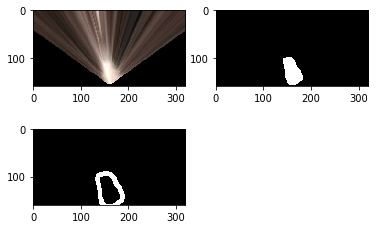

In [12]:
# Define function to pass stored images to reading rover position and yaw from csv
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    
    warped, mask = perspect_transform(img, source, destination)
   
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    threshed = color_thresh(warped)
    threshed,box = box_threshed(threshed)
    obs_map = create_obs_map(threshed)

    # 4) Convert thresholded image pixel values to rover-centric coords
    xpix, ypix = rover_coords(threshed)        # array of rover_xy values for nav map
    obs_xpix, obs_ypix = rover_coords(obs_map) # array of rover_xy values for obs map
    
    # 5) Convert rover-centric pixel values to world coords
    count = data.count            # current count/index position
    xpos = data.xpos[count]       # current x position
    ypos = data.ypos[count]       # current y position
    yaw  = data.yaw[count]        # current yaw angle
    scale = 10
    world_size = data.worldmap.shape[0] # 200 x 200
    
    # navigable xy-world coordinates
    xworld, yworld = \
    pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale)
    
    # obstacle xy-world coordinates
    obs_xworld, obs_yworld = \
    pix_to_world(obs_xpix, obs_ypix, xpos, ypos, yaw, world_size, scale)
#     print (obs_xworld.shape, obs_yworld.shape)

    # Detecting rocks in the map
    rock_map = detect_rocks(warped)
    if rock_map.sum() > 50 and data.rock_marked == 0:
#         print (rock_map.sum(), count)
        rock_xpix, rock_ypix = rover_coords(rock_map)
        rock_xworld, rock_yworld = pix_to_world(\
                                rock_xpix, rock_ypix, xpos, ypos, yaw, world_size, scale)
        rock_x_mean = np.mean(rock_xworld).astype(int)
        rock_y_mean = np.mean(rock_yworld).astype(int)

        data.worldmap[\
                rock_y_mean-2:rock_y_mean+2, \
                rock_x_mean-2:rock_x_mean+2, 1] = 255
        data.rock_marked = 1
    
    # Avoiding detection and coloring of the same rock for multiple frames
    if data.rock_marked == 1:
        data.till_next_rock += 1
        if data.till_next_rock >= 15:
#             print ("Changing rock status back to 0 after {} wait-frames."\
#                    .format(data.till_next_rock))
            data.rock_marked = 0
            data.till_next_rock = 0
        
#     6) Update worldmap (to be displayed on right side of screen)
    data.worldmap[obs_yworld, obs_xworld, 0] = 255 #setting obstacles to red
    data.worldmap[yworld, xworld, 2] = 255   #setting navigable terrain to blue

    nav_pix = data.worldmap[:,:,2] > 0
    data.worldmap[nav_pix, 0] = 0
    

    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)

    output_image[img.shape[0]:, img.shape[1]:data.worldmap.shape[1]+img.shape[1]] = np.flipud(data.worldmap)

        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    plt.subplot(221)
    plt.imshow(warped)                  

    plt.subplot(222)
    plt.imshow(threshed, cmap='gray')                  

    plt.subplot(223)
    plt.imshow(obs_map, cmap='gray')                  

   
    return output_image

k=process_image(image)

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


100%|██████████| 489/489 [00:06<00:00, 75.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

CPU times: user 6.34 s, sys: 120 ms, total: 6.46 s
Wall time: 6.62 s


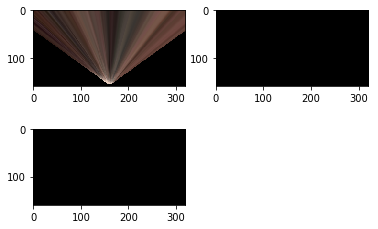

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip
# import numpy as np

# Define pathname to save the output video
output = '../output/test_mapping.mp4'

data = Databucket() # Re-initialize data in case you're running this cell multiple times

clip = ImageSequenceClip(data.images, fps=100) 
# Note: output video will be sped up because 
# recording rate in simulator is fps=25

new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [14]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [15]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))